# import + funcs

In [70]:
import pingouin as pg
import pandas as pd
import os
import numpy as np  
import matplotlib.pyplot as plt
import seaborn as sns
import json
import statsmodels.regression.linear_model as sm
import ast
import warnings
import shutil
import pickle
import scipy

def remove_last_folder(path: str) -> str:
    # 1. Normalize: collapse duplicate slashes, strip trailing ones
    normalized = os.path.normpath(path)
    # 2. dirname: drop the last component
    return os.path.dirname(normalized)

def SaveFig(file_name,figure_dir):
    if not os.path.isdir(figure_dir):
        os.makedirs(figure_dir)
    plt.savefig(figure_dir + file_name, bbox_inches='tight')
    plt.show()

# ignore only deprecation warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

def reactivation_per_minute(nrem_filtered_chunk_data, nrem_state_times):
    # save out data
    reactivations_found = len(nrem_filtered_chunk_data)

    if len(nrem_state_times) > 0:
        mins = np.diff(nrem_state_times)
    else:
        mins = 0
        
    # convert to mins            
    mins = mins/60

    if mins > 0:
        return reactivations_found/mins
    else:
        return np.nan
    
def define_spindle_linkage(spindle_start_events,spindle_end_events,replay_times):
    spindle_linkage_distance = []
    for event in replay_times:
        current_shortest_dist = 999999
        for i,spin_start in enumerate(spindle_start_events):
            s_distance = abs(spin_start - event)
            e_distance = abs(spindle_end_events[i] - event)
            if s_distance < abs(current_shortest_dist):
                current_shortest_dist = s_distance
            elif e_distance < abs(current_shortest_dist):
                current_shortest_dist = e_distance
        spindle_linkage_distance += [current_shortest_dist]
    return spindle_linkage_distance

def return_spindle_linkage_masks(file, filtered_chunk_data, spindle_events, time_spans, linkage_distance,non_linked_distance):

    chunk_number = int(file.split('_')[0][-1])
    chunk_start_offset = ([0]+list(np.cumsum(np.diff(time_spans))))[chunk_number-1]
    # make relative to start of chunk
    fs_event_times = filtered_chunk_data['first_spike_time'].values - chunk_start_offset
    # put these back in proper ephys time:
    fs_event_times = fs_event_times + time_spans[chunk_number-1][0]
    # get spindle times
    spindle_start_times = [event['start_time'] for event in spindle_events]
    spindle_end_times = [event['end_time'] for event in spindle_events]
    # spindle distances
    absolute_spindle_distances = abs(np.array(define_spindle_linkage(spindle_start_times,spindle_end_times,fs_event_times)))
    # get the linked and unlinked masks
    linked_mask = absolute_spindle_distances < 1.5
    not_linked_mask = absolute_spindle_distances > 2.5
    
    return linked_mask, not_linked_mask

def return_binned_replay_rate(file, filtered_chunk_data, time_spans, current_sleep_start):
    chunk_number = int(file.split('_')[0][-1])
    chunk_start_offset = ([0]+list(np.cumsum(np.diff(time_spans))))[chunk_number-1]
    # make relative to start of chunk
    fs_event_times = filtered_chunk_data['first_spike_time'].values - chunk_start_offset
    # put these back in proper ephys time:
    fs_event_times = fs_event_times + time_spans[chunk_number-1][0]
    # now make relative to sleep start time
    f_spike_times_relative_to_so = fs_event_times - current_sleep_start 
    # filter out anything that happened before sleep onset
    f_spike_times_relative_to_so = f_spike_times_relative_to_so[f_spike_times_relative_to_so > 0]

    ## calculate rate over time:
    time_data = pd.Series(f_spike_times_relative_to_so)
    if len(time_data) > 0:
        # Calculate the number of bins required # 20s bins
    #     num_bins = int((time_data.max() - time_data.min()) // 40 + 1)
        if time_data.max() - time_data.min() > 19:
            num_bins = int((time_data.max() - time_data.min())//20)
            # Create bins and count the occurrences in each bin
            chunk_event_rate, chunk_relative_time_bins = np.histogram(time_data, bins=num_bins)
            #remove extra final bin and convert to mins
            chunk_relative_time_bins = chunk_relative_time_bins[0:-1]/60
            
            binned_rate = [list((chunk_event_rate*3).astype(float))] # *3 because its per 20s so we want it per minute )
            bins_relative_so = [list(chunk_relative_time_bins.astype(float))]
            
            return binned_rate,bins_relative_so
        return np.nan, np.nan
    return np.nan, np.nan

def load_start_end_dfs(mouse,start_end_df,current_data_path_temporal_structre,chunk_number):
    try:
        ## start stop points
        df_load = pd.read_csv(current_data_path_temporal_structre+'start_end_df.csv',index_col=0)
        
        starts = df_load[df_load.group == 'starts'].reset_index(drop=True)
        ends = df_load[df_load.group == 'ends'].reset_index(drop=True)
        df_filtered = pd.concat([starts, ends], axis=0)
        df_filtered['mouse'] = [mouse]*len(df_filtered)
        df_filtered['chunk_number'] = [chunk_number]*len(df_filtered)
        start_end_df = pd.concat((start_end_df,df_filtered),axis =0)
        start_end_df.reset_index(drop = True)
    except:
        print('no start stops points available')
    return start_end_df

def cluster_events(start_times, end_times, threshold):
    clusters = []
    for i in range(len(start_times)):
        event_added = False
        for cluster in clusters:
            for index in cluster:
                if (start_times[i] <= end_times[index] + threshold and end_times[i] >= start_times[index] - threshold):
                    cluster.append(i)
                    event_added = True
                    break
            if event_added:
                break
        if not event_added:
            clusters.append([i])
    return clusters

def relative_dict(input_dict):
    total_sum = sum(input_dict.values())
    relative_dict = {key: value / total_sum for key, value in input_dict.items()}
    return relative_dict

def determine_relative_coactivity_per_chunk(filtered_chunk_data, event_proximity_filter, coactive_freqs_chunk):

    ### ignore the origonal clusterg rosp and remake them: 
    start_times = filtered_chunk_data.first_spike_time.values
    end_times = filtered_chunk_data.last_spike_time.values

    clustered_events = cluster_events(start_times, end_times,event_proximity_filter)

    cluster_group = np.zeros(len(filtered_chunk_data))
    for index,cluster in enumerate(clustered_events):
        for item in cluster:
            cluster_group[item] = int(index)
    filtered_chunk_data_coactive = filtered_chunk_data.copy()
    filtered_chunk_data_coactive['coactive_cluster_group'] = cluster_group

    # work out how mnay coacitve in chunk: 
    current_coactive_freqs_chunk = {}
    for cluster in filtered_chunk_data_coactive.coactive_cluster_group.unique():
        num = list(filtered_chunk_data_coactive.coactive_cluster_group.values).count(cluster)
        if num in current_coactive_freqs_chunk:
            current_coactive_freqs_chunk[num] += 1
        else:
            current_coactive_freqs_chunk[num] = 1

    avs =[]
    for item in current_coactive_freqs_chunk:
        avs += current_coactive_freqs_chunk[item] * [item]
    # av_coactive_len_per_chunk += [np.mean(avs)]

    # make it relative:
    current_coactive_freqs_chunk = relative_dict(current_coactive_freqs_chunk)
    coactive_freqs_keys = list(current_coactive_freqs_chunk.keys())
    rel_coactive_freqs = list(current_coactive_freqs_chunk.values())
    for index,item in enumerate(rel_coactive_freqs):
        num = int(coactive_freqs_keys[index])
        if num in coactive_freqs_chunk:
            coactive_freqs_chunk[num] += [item]
        else:
            coactive_freqs_chunk[num] = [item]
            
    return coactive_freqs_chunk,filtered_chunk_data_coactive


def create_multicluster_dataframe(filtered_chunk_data):
    meaned_order = []
    fs_order = []
    event_times = []
    count = 0
    for i,group in enumerate(filtered_chunk_data.coactive_cluster_group.unique()):
        group_mask = filtered_chunk_data.coactive_cluster_group == group
        current_cluster = filtered_chunk_data[group_mask].copy()
        if len(current_cluster) > 1:
            means = []
            event_types = []
            fs_orders = []
            for index,events in enumerate(current_cluster.cluster_spike_times):
                event_types += [current_cluster.cluster_seq_type.values[index]]
                # calculate event order based on spike time weighted mean
                means += [np.mean(ast.literal_eval(events))]
                # calculate order based on first spike time:
                fs_orders += [current_cluster.first_spike_time.values[index]]

            # order by mean time:    
            meaned_order += [list(np.array(event_types)[np.argsort(means)])]
            # order by first spike:
            fs_order += [list(np.array(event_types)[np.argsort(fs_orders)])]

            event_times += [fs_orders]

            current_cluster['new_cluster_group'] =  [count]*len(current_cluster)
            current_cluster['cluster_order_first_spike_defined'] =  list(np.argsort(np.argsort(fs_orders)))
            current_cluster['cluster_order_mean_weighted_spikes_defined'] =  list(np.argsort(np.argsort(means)))

            if count == 0:
                multi_cluster_df = current_cluster.copy()
            else:
                # Concatenate the DataFrames vertically (row-wise)
                multi_cluster_df = pd.concat([multi_cluster_df, current_cluster], axis=0)
                # Reset the index if needed
                multi_cluster_df = multi_cluster_df.reset_index(drop=True)

            count += 1
    return multi_cluster_df,meaned_order,fs_order

def logic_machine_for_pair_catagorisation(pair,dominant,other):
    # if first one in dominant check for ordering:
    if pair[0] in dominant and pair[-1] in dominant:
        if pair_in_sequence(pair,dominant):
            return('ordered')
        elif pair_in_sequence(pair,dominant[::-1]):
            return('reverse')
        elif pair[-1] == pair[0]:
            return('repeat')
        elif pair[-1] in dominant:
            return('misordered') 
    # if its not these  options then check if it could be in the extra task seqs
    elif pair[0] in  (dominant + other) and pair[-1] in  (dominant + other):
        for item in other:
            if pair[0] in  (dominant + [item]):
                if pair_in_sequence(pair,(dominant + [item])):
                    return('ordered')
                elif pair_in_sequence(pair,(dominant + [item])[::-1]):
                    return('reverse')
                elif pair[-1] == pair[0]:
                    return('repeat')
                # elif pair[-1] in (dominant + [item]):
                #     return('misordered')  
        # if not this then check if both are in the extra seqs (and are not a repeat):
        if pair[0] in other and pair[-1] in other:
            if not pair[-1] == pair[0]: 
                return('ordered')
    else:
        # if item 1 is in but item 2 isnt then task to other 
        if pair[0] in  (dominant + other):
            if not pair[-1] in  (dominant + other):
                return('task to other')
        # if item 2 is in but item 1 isnt then other to task 
        elif not pair[0] in  (dominant + other):
            if pair[-1] in  (dominant + other):
                return('other to task')
            else:
                return('other')
    return print('ERROR!')

def Clusters_to_process_bool(filtered_chunk_data):
    """
    Check if there are clusters with more than one event in the filtered chunk data.
    Returns True if there are such clusters, otherwise False.
    """
    # Check if any cluster has more than one event
    for i,group in enumerate(filtered_chunk_data.coactive_cluster_group.unique()):
        group_mask = filtered_chunk_data.coactive_cluster_group == group
        current_cluster = filtered_chunk_data[group_mask].copy()
        if len(current_cluster) > 1:
            return True
    return False

def pair_in_sequence(pair, sequence):
    for i in range(len(sequence) - 1):
        if sequence[i] == pair[0] and sequence[i + 1] == pair[1]:
            return True
        # because its ciruclar:
        elif sequence[-1] == pair[0] and sequence[0] == pair[1]:
            return True
    return False

def calculate_ordering_amounts(meaned_order,dominant,other_):
    ordered = 0
    misordered = 0
    other = 0
    for cluster in meaned_order:
        for ind,item in enumerate(cluster):
            if not ind == len(cluster)-1:
                pair = [item,cluster[ind+1]]
                outcome = logic_machine_for_pair_catagorisation(pair,dominant,other_)
                if outcome in ['ordered', 'repeat', 'reverse']:
                    ordered += 1
                elif outcome == 'misordered':
                    misordered += 1
                else:
                    other +=1
    return ordered,misordered,other

def calculate_ordering_proportions(filtered_chunk_data,mouse_file, sequence_order_df):

    # make multi cluster df
    if Clusters_to_process_bool(filtered_chunk_data):
        multi_cluster_df,meaned_order,fs_order = create_multicluster_dataframe(filtered_chunk_data)
    else:
        multi_cluster_df,meaned_order,fs_order = [],[],[]

    # pull out sequence order for current mouse
    seq_order= ast.literal_eval(sequence_order_df[sequence_order_df.mir == mouse_file].seq_order.values[0])
    # num_dominant_seqs = int(sequence_order_df[sequence_order_df.mir == mouse_file].dominant_task_seqs)
    num_dominant_seqs = int(sequence_order_df.loc[sequence_order_df.mir == mouse_file, "dominant_task_seqs"].iat[0])
    
    
    real_order = np.array(seq_order)+1

    #deal wih the fact that the way I order the sequence messes up the order a bit
    if not len(real_order) == num_dominant_seqs:
        dominant = list(real_order[0:num_dominant_seqs])
        other_ = list(real_order[num_dominant_seqs::])
    else:
        dominant = list(real_order)
        other_ = []
        
    # orderng amounts for mean ordering - this calculated for each pair in the chunk 
    ordered,misordered,other = calculate_ordering_amounts(meaned_order,dominant,other_)

    # i only care abot ordered and misordered here, so lets just take these out:
    if ordered+misordered > 0:
        # ordered_misordered_proportions = [ordered/(ordered+misordered),misordered/(ordered+misordered)]
        return ordered,misordered
    else:
        return [0,0]
    

def determine_task_related_events(sequential_data, sequence_order_df,mouse_file,real_order):

    task_related = 0
    non_task_related = 0
    for motif_type in sequential_data.cluster_seq_type:
        if motif_type in real_order:
            task_related += 1
        else:
            non_task_related += 1

    
    return [non_task_related, task_related]
    
def get_normalised_task_related_proportions(nrem_nontask_task_chunk,real_order):
    #flatten list
    if sum([item for sublist in nrem_nontask_task_chunk for item in sublist]) == 0:
        return [np.nan,np.nan]
    else:
        # normalise by number of each type: 
        task_related_normalised_total = sum([item[1] for item in nrem_nontask_task_chunk])/len(real_order)
        if (6-len(real_order)) == 0:
            non_task_related_normalised_total = sum([item[0] for item in nrem_nontask_task_chunk])
        else:
            non_task_related_normalised_total = sum([item[0] for item in nrem_nontask_task_chunk])/(6-len(real_order))
        normalised_total = task_related_normalised_total + non_task_related_normalised_total
        return [task_related_normalised_total/normalised_total,non_task_related_normalised_total/normalised_total]
    

def extract_sequence_events(df, sequence_type, groups, bin_size, seq_size_threshold):
    """
    Extracts spike events from continuous groups of time bins for a specific sequence type.
    """
    extracted = []

    for start, end in groups:
        group_start_time = (start * bin_size) - 0.5
        group_end_time = (end * bin_size) + 0.5

        time_mask = (df.timestamp > group_start_time) & (df.timestamp < group_end_time)
        group_spikes = df[time_mask]
        matching_seq = group_spikes[group_spikes.sequence_type_adjusted == sequence_type]

        if len(matching_seq) > seq_size_threshold:
            extracted.append(matching_seq)

    return extracted


def plot_sequence_summary(ax1,ax2,unmasked_spikes_df, awake_neuron_order, colors, seq_spike_count, groups, i, time_window, bin_size):
    """
    Plots spike raster and sequence histogram for a given sequence type.
    """
    # Filter spikes within the plotting window
    mask = (unmasked_spikes_df.timestamp > time_window[0]) & (unmasked_spikes_df.timestamp < time_window[1])
    visible_spikes = unmasked_spikes_df[mask]
    valid_seq_mask = visible_spikes.sequence_type_adjusted >= 0
    spike_colors = np.array(colors)[visible_spikes[valid_seq_mask].sequence_type_adjusted.values.astype(int)]

    # Spike raster
    ax1.scatter(
        visible_spikes[valid_seq_mask].timestamp,
        awake_neuron_order[mask][valid_seq_mask],
        marker='o', s=40, linewidth=0, color=spike_colors, alpha=1
    )

    # Histogram and detected groups
    ax2.plot(seq_spike_count, color=colors[i])
    for start, end in groups:
        ax2.plot([start, end], [-5, -5], color='red')

    ax1.set_xlim([time_window[0], time_window[-1]])
    ax2.set_xlim(time_window[0]/bin_size,time_window[-1] / bin_size)


def return_inds_for_seq_groups(lst):
    groups = []
    new = True
    for ind,item in enumerate(lst):
        if new:
            if item > 0:
                start = ind
                new = False
        else:
            if item == 0:
                end = ind-1
                groups.append((start, end))
                new = True
    return groups

def process_awake_data_return_seq_dfs(unmasked_spikes_df, chunk_time, awake_neuron_order, colors, plotting_limit,bin_size=0.2, seq_size_threshold=5):
    """
    Processes spike data to extract time-localized spike events for each sequence type (1–6).
    """
    seq_types = np.unique(unmasked_spikes_df.sequence_type_adjusted)

    # Gather spike timestamps by sequence type
    seq_spikes = [unmasked_spikes_df.timestamp[unmasked_spikes_df.sequence_type_adjusted == seq_type].values for seq_type in seq_types]

    # Compute binned spike histograms
    seq_spike_occurrence = [list(np.histogram(spikes, bins=np.arange(0, np.diff(chunk_time)[0], bin_size))[0]) for spikes in seq_spikes]

    seq_event_dfs = []
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 5))
    for i in range(1, 7):  # process sequence types 1–6
        print(f"Processing sequence type: {i}")
        seq_spike_count = seq_spike_occurrence[i]
        groups = return_inds_for_seq_groups(seq_spike_count)

        # Plot sequence summary (raster + histogram)
        plot_sequence_summary(ax1,ax2,unmasked_spikes_df, awake_neuron_order, colors, seq_spike_count, groups, i, plotting_limit,bin_size)

        # Extract sequence events as separate DataFrames
        seq_event_dfs.extend(
            extract_sequence_events(unmasked_spikes_df, i, groups, bin_size, seq_size_threshold)
        )

    return seq_event_dfs

def determine_awake_neuron_motif_involvements(unmasked_spikes_df, seq_event_dfs):

    seq_by_seq_awake_mean_neuron_motif_involvements = []
    ### determine which neurons are involved in awake seqs
    all_neurons_list = list(np.unique(unmasked_spikes_df.neuron))
    for seq_type in range(1,7):
        # print(seq_type)
        # Determine mean neuron involvements for awake
        neuron_motif_involvements = [[] for _ in range(len(all_neurons_list))]
        for awake_seq in seq_event_dfs:
            if awake_seq.sequence_type_adjusted.values[0] == seq_type:
                for id_, neuron_id in enumerate(all_neurons_list):
                    if neuron_id in awake_seq.neuron.values:
                        neuron_motif_involvements[id_].append(1)
                    else:
                        neuron_motif_involvements[id_].append(0)
        #find mean involvements:
        awake_mean_neuron_motif_involvements = []
        for item in neuron_motif_involvements:
            if len(item)>0:
                awake_mean_neuron_motif_involvements += [sum(item)/len(item)]
            else:
                awake_mean_neuron_motif_involvements += [0]
        seq_by_seq_awake_mean_neuron_motif_involvements += [awake_mean_neuron_motif_involvements]
    return seq_by_seq_awake_mean_neuron_motif_involvements

def find_awake_file_ppseq_path(mouse,ppseq_path):
    if any([mouse in file for file in os.listdir(ppseq_path + r'expert/awake//')]) == True:
        file_ind = np.where(np.array([mouse in file for file in os.listdir(ppseq_path + r'expert/awake//')]) == True)[0][0]
        awake_file_path = os.path.join(ppseq_path, r'expert/awake', os.listdir(ppseq_path + r'expert/awake//')[file_ind])
    elif any([mouse in file for file in os.listdir(ppseq_path + r'learning/awake//')]) == True:    
        file_ind = np.where(np.array([mouse in file for file in os.listdir(ppseq_path + r'learning/awake//')]) == True)[0][0]
        awake_file_path = os.path.join(ppseq_path, r'learning/awake', os.listdir(ppseq_path + r'learning/awake//')[file_ind])
    else:
        print('awake file not found for mouse: ' + mouse)
    return awake_file_path

def determine_sleep_neuron_motif_involvements(filtered_chunk_data,unmasked_spikes_df):

    per_seq_sleep_involvement = []
    for seq in range(1,7):
        current_seq_events = filtered_chunk_data[filtered_chunk_data.cluster_seq_type == seq]
        if len(current_seq_events) > 0:
            # loop across neurons
            per_neuron_sleep_involvement = []
            for neuron in unmasked_spikes_df.neuron.unique():
                involvement = []
                for event in current_seq_events.cluster_neurons.values:
                    event = ast.literal_eval(event)
                    if neuron in event:
                        involvement += [1]
                    else:
                        involvement += [0]
                per_neuron_sleep_involvement += [sum(involvement)/len(involvement)]
            per_seq_sleep_involvement += [per_neuron_sleep_involvement]
        else:
            per_seq_sleep_involvement += [[np.nan]*len(unmasked_spikes_df.neuron.unique())]
    return per_seq_sleep_involvement
                
            
def load_in_sleep_state_scoring(mouse):
    print('---------------------')
    print('searching for sleep state scoring')
    # determine organised data paths for the current mouse
    if mouse.split('_')[0].isdigit():
        org_dat_path = r"Z:\projects\sequence_squad\organised_data\animals\\"
        old_data = True
    else:
        org_dat_path = r"Z:\projects\sequence_squad\revision_data\organised_data\animals\\"
        old_data = False
    org_mouse_file = None
    for file in os.listdir(org_dat_path):
        if mouse.split('_')[0] in file:
            # if the implant = implant
            if mouse.split('_')[1] == file.split('_')[-1][-1]:
                print(f'1. mouse file found: \033[1m{file}\033[0m')
                org_mouse_file = os.path.join(org_dat_path,file)
    mouse_org_data_path = None
    for recording in os.listdir(org_mouse_file):
        if mouse.split('_')[-1] == recording.split('ing')[-1].split('_')[0]:
            print(f'2. recording found: \033[1m{recording}\033[0m')
            mouse_org_data_path = os.path.join(org_mouse_file,recording) + r'\\'

    # load in sleep scoring data 

    sleep_state_score_path = mouse_org_data_path + r"\ephys\LFP\\sleep_state_score\\"
    if not os.path.exists(sleep_state_score_path):
        sleep_state_score_path =  mouse_org_data_path + '/ephys/probeA/LFP/'

    if not os.path.exists(sleep_state_score_path):
        print(f"Sleep state score files not found for {mouse}.")
    else:
        nrem_start_ends = np.load(sleep_state_score_path + "nrem_start_ends.npy", allow_pickle=True)
        rem_start_ends = np.load(sleep_state_score_path + "rem_start_ends.npy", allow_pickle=True)
        print (f"\033[1mSuccess!\033[0m Loaded sleep state score files for mouse: {mouse}.")

    print('----------------------')
        
    return nrem_start_ends,rem_start_ends,mouse_org_data_path,old_data

def get_chunk_state_times(rem_start_ends,chunk_time):
    chunk_rem_times = []
    for start,end in rem_start_ends:
        if start >= chunk_time[0] and start <= chunk_time[1]:
            start_chunk_rebased = start - chunk_time[0]
            end_chunk_rebased = end - chunk_time[0]
            # expand by 10%
            start_chunk_rebased = start_chunk_rebased * 0.9
            end_chunk_rebased = end_chunk_rebased * 1.1
            # if the end stetches past the end of the chunk then just set it to the end of the chunk
            if end_chunk_rebased > np.diff(chunk_time)[0]:
                end_chunk_rebased = np.diff(chunk_time)[0]
            chunk_rem_times += [[start_chunk_rebased,end_chunk_rebased]]
    return chunk_rem_times

def calculate_ordered_proportion(nrem_chunk_ordered_misordered_proportions):
    ordered = [sublist[0] for sublist in nrem_chunk_ordered_misordered_proportions]
    misordered = [sublist[-1] for sublist in nrem_chunk_ordered_misordered_proportions]
    if  sum(misordered) + sum(ordered) > 0:
        return [sum(ordered)/ (sum(misordered) + sum(ordered)),sum(misordered)/ (sum(misordered) + sum(ordered))]
    else:
        return [np.nan,np.nan]

# Preprocessing

In [ ]:
# # dat path:
# # dat_path = r"Z:\projects\sequence_squad\organised_data\ppseq_data\output_data\striatum\New_Post_sleep\\"
# dat_path_presleep = r"Z:\projects\sequence_squad\revision_data\emmett_revisions\Reveiw_Pre_sleep\second_attempt\\"

dat_path_ap5 = r"Z:\projects\sequence_squad\revision_data\emmett_revisions\AP5_data\post_sleep\\"


# dat_path_learning = r"Z:\projects\sequence_squad\ppseq_finalised_publication_data\learning\postsleep\\"
# dat_path_hlesion = r"Z:\projects\sequence_squad\ppseq_finalised_publication_data\h_lesion\postsleep\\"


### CHOOSE!

dat_path = dat_path_ap5


----------
136_1_3_run_2908025_2041
0
136_1_3_run_2908025_2041
replay data path found: Z:\projects\sequence_squad\revision_data\emmett_revisions\Reveiw_Pre_sleep\second_attempt\\136_1_3_run_2908025_2041\_final_analysis_output
chunk1_100to800
---------------------
searching for sleep state scoring
1. mouse file found: EJT136_implant1
2. recording found: recording3_11-11-2021
Success! Loaded sleep state score files for mouse: 136_1_3.
----------------------
Processing sequence type: 1
Processing sequence type: 2
Processing sequence type: 3
Processing sequence type: 4
Processing sequence type: 5
Processing sequence type: 6
chunk2_2100to2400
---------------------
searching for sleep state scoring
1. mouse file found: EJT136_implant1
2. recording found: recording3_11-11-2021
Success! Loaded sleep state score files for mouse: 136_1_3.
----------------------
Processing sequence type: 1
Processing sequence type: 2
Processing sequence type: 3
Processing sequence type: 4
Processing sequence type

c:\miniconda\envs\analysis_main\lib\site-packages\numpy\_core\fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\miniconda\envs\analysis_main\lib\site-packages\numpy\_core\_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


----------
136_1_4_run_2808025_1803
1
136_1_4_run_2808025_1803
replay data path found: Z:\projects\sequence_squad\revision_data\emmett_revisions\Reveiw_Pre_sleep\second_attempt\\136_1_4_run_2808025_1803\_final_analysis_output
chunk1_50to250
---------------------
searching for sleep state scoring
1. mouse file found: EJT136_implant1
2. recording found: recording4_12-11-2021
Success! Loaded sleep state score files for mouse: 136_1_4.
----------------------
Processing sequence type: 1
Processing sequence type: 2
Processing sequence type: 3
Processing sequence type: 4
Processing sequence type: 5
Processing sequence type: 6
chunk2_550to1000
---------------------
searching for sleep state scoring
1. mouse file found: EJT136_implant1
2. recording found: recording4_12-11-2021
Success! Loaded sleep state score files for mouse: 136_1_4.
----------------------
Processing sequence type: 1
Processing sequence type: 2
Processing sequence type: 3
Processing sequence type: 4
Processing sequence type: 

c:\miniconda\envs\analysis_main\lib\site-packages\numpy\_core\fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\miniconda\envs\analysis_main\lib\site-packages\numpy\_core\_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


----------
149_1_1_run_0409025_1305
2
149_1_1_run_0409025_1305
replay data path found: Z:\projects\sequence_squad\revision_data\emmett_revisions\Reveiw_Pre_sleep\second_attempt\\149_1_1_run_0409025_1305\_final_analysis_output
chunk1_500to1000
---------------------
searching for sleep state scoring
1. mouse file found: EJT149_implant1
2. recording found: recording1_16-11-2021
Success! Loaded sleep state score files for mouse: 149_1_1.
----------------------
Processing sequence type: 1
Processing sequence type: 2
Processing sequence type: 3
Processing sequence type: 4
Processing sequence type: 5
Processing sequence type: 6
chunk2_1200to1600
---------------------
searching for sleep state scoring
1. mouse file found: EJT149_implant1
2. recording found: recording1_16-11-2021
Success! Loaded sleep state score files for mouse: 149_1_1.
----------------------
Processing sequence type: 1
Processing sequence type: 2
Processing sequence type: 3
Processing sequence type: 4
Processing sequence typ

c:\miniconda\envs\analysis_main\lib\site-packages\numpy\_core\fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\miniconda\envs\analysis_main\lib\site-packages\numpy\_core\_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


----------
178_1_4_run_2908025_0054
3
178_1_4_run_2908025_0054
replay data path found: Z:\projects\sequence_squad\revision_data\emmett_revisions\Reveiw_Pre_sleep\second_attempt\\178_1_4_run_2908025_0054\_final_analysis_output
chunk1_800to1300
---------------------
searching for sleep state scoring
1. mouse file found: EJT178_implant1
2. recording found: recording4_18-03-2022
Success! Loaded sleep state score files for mouse: 178_1_4.
----------------------
Processing sequence type: 1
Processing sequence type: 2
Processing sequence type: 3
Processing sequence type: 4
Processing sequence type: 5
Processing sequence type: 6
chunk2_1600to1800
---------------------
searching for sleep state scoring
1. mouse file found: EJT178_implant1
2. recording found: recording4_18-03-2022
Success! Loaded sleep state score files for mouse: 178_1_4.
----------------------
Processing sequence type: 1
Processing sequence type: 2
Processing sequence type: 3
Processing sequence type: 4
Processing sequence typ

c:\miniconda\envs\analysis_main\lib\site-packages\numpy\_core\fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\miniconda\envs\analysis_main\lib\site-packages\numpy\_core\_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


----------
178_1_6_run_2808025_2149
4
178_1_6_run_2808025_2149
replay data path found: Z:\projects\sequence_squad\revision_data\emmett_revisions\Reveiw_Pre_sleep\second_attempt\\178_1_6_run_2808025_2149\_final_analysis_output
chunk1_500to1200
---------------------
searching for sleep state scoring
1. mouse file found: EJT178_implant1
2. recording found: recording6_29-03-2022
Success! Loaded sleep state score files for mouse: 178_1_6.
----------------------
Processing sequence type: 1
Processing sequence type: 2
Processing sequence type: 3
Processing sequence type: 4
Processing sequence type: 5
Processing sequence type: 6
chunk2_2600to2800
---------------------
searching for sleep state scoring
1. mouse file found: EJT178_implant1
2. recording found: recording6_29-03-2022
Success! Loaded sleep state score files for mouse: 178_1_6.
----------------------
Processing sequence type: 1
Processing sequence type: 2
Processing sequence type: 3
Processing sequence type: 4
Processing sequence typ

c:\miniconda\envs\analysis_main\lib\site-packages\numpy\_core\fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\miniconda\envs\analysis_main\lib\site-packages\numpy\_core\_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


----------
178_1_7_run_2808025_1428
5
178_1_7_run_2808025_1428
replay data path found: Z:\projects\sequence_squad\revision_data\emmett_revisions\Reveiw_Pre_sleep\second_attempt\\178_1_7_run_2808025_1428\_final_analysis_output
chunk1_500to1200
---------------------
searching for sleep state scoring
1. mouse file found: EJT178_implant1
2. recording found: recording7_30-03-2022
Success! Loaded sleep state score files for mouse: 178_1_7.
----------------------
Processing sequence type: 1
Processing sequence type: 2
Processing sequence type: 3
Processing sequence type: 4
Processing sequence type: 5
Processing sequence type: 6
chunk2_2000to2200
---------------------
searching for sleep state scoring
1. mouse file found: EJT178_implant1
2. recording found: recording7_30-03-2022
Success! Loaded sleep state score files for mouse: 178_1_7.
----------------------
Processing sequence type: 1
Processing sequence type: 2
Processing sequence type: 3
Processing sequence type: 4
Processing sequence typ

c:\miniconda\envs\analysis_main\lib\site-packages\numpy\_core\fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\miniconda\envs\analysis_main\lib\site-packages\numpy\_core\_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


----------
178_1_8_run_2808025_1023
6
178_1_8_run_2808025_1023
replay data path found: Z:\projects\sequence_squad\revision_data\emmett_revisions\Reveiw_Pre_sleep\second_attempt\\178_1_8_run_2808025_1023\_final_analysis_output
chunk1_1000to1300
---------------------
searching for sleep state scoring
1. mouse file found: EJT178_implant1
2. recording found: recording8_31-03-2022
Success! Loaded sleep state score files for mouse: 178_1_8.
----------------------
Processing sequence type: 1
Processing sequence type: 2
Processing sequence type: 3
Processing sequence type: 4
Processing sequence type: 5
Processing sequence type: 6
chunk2_2000to2300
---------------------
searching for sleep state scoring
1. mouse file found: EJT178_implant1
2. recording found: recording8_31-03-2022
Success! Loaded sleep state score files for mouse: 178_1_8.
----------------------
Processing sequence type: 1
Processing sequence type: 2
Processing sequence type: 3
Processing sequence type: 4
Processing sequence ty

c:\miniconda\envs\analysis_main\lib\site-packages\numpy\_core\fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\miniconda\envs\analysis_main\lib\site-packages\numpy\_core\_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


----------
178_1_9_run_2808025_2053
7
178_1_9_run_2808025_2053
replay data path found: Z:\projects\sequence_squad\revision_data\emmett_revisions\Reveiw_Pre_sleep\second_attempt\\178_1_9_run_2808025_2053\_final_analysis_output
chunk1_100to300
---------------------
searching for sleep state scoring
1. mouse file found: EJT178_implant1
2. recording found: recording9_01-04-2022
Success! Loaded sleep state score files for mouse: 178_1_9.
----------------------
Processing sequence type: 1
Processing sequence type: 2
Processing sequence type: 3
Processing sequence type: 4
Processing sequence type: 5
Processing sequence type: 6
chunk2_2000to2600
---------------------
searching for sleep state scoring
1. mouse file found: EJT178_implant1
2. recording found: recording9_01-04-2022
Success! Loaded sleep state score files for mouse: 178_1_9.
----------------------
Processing sequence type: 1
Processing sequence type: 2
Processing sequence type: 3
Processing sequence type: 4
Processing sequence type

c:\miniconda\envs\analysis_main\lib\site-packages\numpy\_core\fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\miniconda\envs\analysis_main\lib\site-packages\numpy\_core\_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


----------
178_2_1_run_2908025_0336
8
178_2_1_run_2908025_0336
replay data path found: Z:\projects\sequence_squad\revision_data\emmett_revisions\Reveiw_Pre_sleep\second_attempt\\178_2_1_run_2908025_0336\_final_analysis_output
chunk1_1000to1400
---------------------
searching for sleep state scoring
1. mouse file found: EJT178_implant2
2. recording found: recording1_04-04-2022
Success! Loaded sleep state score files for mouse: 178_2_1.
----------------------
Processing sequence type: 1
Processing sequence type: 2
Processing sequence type: 3
Processing sequence type: 4
Processing sequence type: 5
Processing sequence type: 6
chunk2_2000to2200
---------------------
searching for sleep state scoring
1. mouse file found: EJT178_implant2
2. recording found: recording1_04-04-2022
Success! Loaded sleep state score files for mouse: 178_2_1.
----------------------


C:\Users\Emmett Thompson\AppData\Local\Temp\ipykernel_67684\1424177735.py:447: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 5))


Processing sequence type: 1
Processing sequence type: 2
Processing sequence type: 3
Processing sequence type: 4
Processing sequence type: 5
Processing sequence type: 6
chunk3_2400to2600
---------------------
searching for sleep state scoring
1. mouse file found: EJT178_implant2
2. recording found: recording1_04-04-2022
Success! Loaded sleep state score files for mouse: 178_2_1.
----------------------
Processing sequence type: 1
Processing sequence type: 2
Processing sequence type: 3
Processing sequence type: 4
Processing sequence type: 5
Processing sequence type: 6


c:\miniconda\envs\analysis_main\lib\site-packages\numpy\_core\fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\miniconda\envs\analysis_main\lib\site-packages\numpy\_core\_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


----------
178_2_2_run_2808025_2157
9
178_2_2_run_2808025_2157
replay data path found: Z:\projects\sequence_squad\revision_data\emmett_revisions\Reveiw_Pre_sleep\second_attempt\\178_2_2_run_2808025_2157\_final_analysis_output
chunk1_1000to1700
---------------------
searching for sleep state scoring
1. mouse file found: EJT178_implant2
2. recording found: recording2_05-04-2022
Success! Loaded sleep state score files for mouse: 178_2_2.
----------------------
Processing sequence type: 1
Processing sequence type: 2
Processing sequence type: 3
Processing sequence type: 4
Processing sequence type: 5
Processing sequence type: 6
chunk2_2600to2900
---------------------
searching for sleep state scoring
1. mouse file found: EJT178_implant2
2. recording found: recording2_05-04-2022
Success! Loaded sleep state score files for mouse: 178_2_2.
----------------------
Processing sequence type: 1
Processing sequence type: 2
Processing sequence type: 3
Processing sequence type: 4
Processing sequence ty

c:\miniconda\envs\analysis_main\lib\site-packages\numpy\_core\fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\miniconda\envs\analysis_main\lib\site-packages\numpy\_core\_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


----------
178_2_4_run_2808025_0800
10
178_2_4_run_2808025_0800
replay data path found: Z:\projects\sequence_squad\revision_data\emmett_revisions\Reveiw_Pre_sleep\second_attempt\\178_2_4_run_2808025_0800\_final_analysis_output
chunk1_1000to1500
---------------------
searching for sleep state scoring
1. mouse file found: EJT178_implant2
2. recording found: recording4_07-04-2022
Success! Loaded sleep state score files for mouse: 178_2_4.
----------------------
Processing sequence type: 1
Processing sequence type: 2
Processing sequence type: 3
Processing sequence type: 4
Processing sequence type: 5
Processing sequence type: 6
chunk2_3000to3300
---------------------
searching for sleep state scoring
1. mouse file found: EJT178_implant2
2. recording found: recording4_07-04-2022
Success! Loaded sleep state score files for mouse: 178_2_4.
----------------------


C:\Users\Emmett Thompson\AppData\Local\Temp\ipykernel_67684\739147720.py:141: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  regression_df = pd.concat((regression_df,df_load),axis =0)
C:\Users\Emmett Thompson\AppData\Local\Temp\ipykernel_67684\739147720.py:141: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  regression_df = pd.concat((regression_df,df_load),axis =0)


no start stops points available
Processing sequence type: 1
Processing sequence type: 2
Processing sequence type: 3
Processing sequence type: 4
Processing sequence type: 5
Processing sequence type: 6
chunk3_4000to4200
---------------------
searching for sleep state scoring
1. mouse file found: EJT178_implant2
2. recording found: recording4_07-04-2022
Success! Loaded sleep state score files for mouse: 178_2_4.
----------------------
Processing sequence type: 1
Processing sequence type: 2
Processing sequence type: 3
Processing sequence type: 4
Processing sequence type: 5
Processing sequence type: 6


c:\miniconda\envs\analysis_main\lib\site-packages\numpy\_core\fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\miniconda\envs\analysis_main\lib\site-packages\numpy\_core\_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


----------
269_1_1_run_2808025_2350
11
269_1_1_run_2808025_2350
replay data path found: Z:\projects\sequence_squad\revision_data\emmett_revisions\Reveiw_Pre_sleep\second_attempt\\269_1_1_run_2808025_2350\_final_analysis_output
chunk1_600to1200
---------------------
searching for sleep state scoring
1. mouse file found: EJT269_implant1
2. recording found: recording1_13-05-2023
Success! Loaded sleep state score files for mouse: 269_1_1.
----------------------
Processing sequence type: 1
Processing sequence type: 2
Processing sequence type: 3
Processing sequence type: 4
Processing sequence type: 5
Processing sequence type: 6
chunk2_2000to2400
---------------------
searching for sleep state scoring
1. mouse file found: EJT269_implant1
2. recording found: recording1_13-05-2023
Success! Loaded sleep state score files for mouse: 269_1_1.
----------------------
Processing sequence type: 1
Processing sequence type: 2
Processing sequence type: 3
Processing sequence type: 4
Processing sequence ty

c:\miniconda\envs\analysis_main\lib\site-packages\numpy\_core\fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\miniconda\envs\analysis_main\lib\site-packages\numpy\_core\_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


----------
269_1_3_run_2808025_0810
12
269_1_3_run_2808025_0810
replay data path found: Z:\projects\sequence_squad\revision_data\emmett_revisions\Reveiw_Pre_sleep\second_attempt\\269_1_3_run_2808025_0810\_final_analysis_output
chunk1_1200to1800
---------------------
searching for sleep state scoring
1. mouse file found: EJT269_implant1
2. recording found: recording3_16-05-2023
Success! Loaded sleep state score files for mouse: 269_1_3.
----------------------
Processing sequence type: 1
Processing sequence type: 2
Processing sequence type: 3
Processing sequence type: 4
Processing sequence type: 5
Processing sequence type: 6
chunk2_2200to2500
---------------------
searching for sleep state scoring
1. mouse file found: EJT269_implant1
2. recording found: recording3_16-05-2023
Success! Loaded sleep state score files for mouse: 269_1_3.
----------------------
Processing sequence type: 1
Processing sequence type: 2
Processing sequence type: 3
Processing sequence type: 4
Processing sequence t

c:\miniconda\envs\analysis_main\lib\site-packages\numpy\_core\fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\miniconda\envs\analysis_main\lib\site-packages\numpy\_core\_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


----------
269_1_4_run_2808025_0856
13
269_1_4_run_2808025_0856
replay data path found: Z:\projects\sequence_squad\revision_data\emmett_revisions\Reveiw_Pre_sleep\second_attempt\\269_1_4_run_2808025_0856\_final_analysis_output
chunk1_1300to2000
---------------------
searching for sleep state scoring
1. mouse file found: EJT269_implant1
2. recording found: recording4_18-05-2023
Success! Loaded sleep state score files for mouse: 269_1_4.
----------------------
Processing sequence type: 1
Processing sequence type: 2
Processing sequence type: 3
Processing sequence type: 4
Processing sequence type: 5
Processing sequence type: 6
chunk2_2300to2600
---------------------
searching for sleep state scoring
1. mouse file found: EJT269_implant1
2. recording found: recording4_18-05-2023
Success! Loaded sleep state score files for mouse: 269_1_4.
----------------------
Processing sequence type: 1
Processing sequence type: 2
Processing sequence type: 3
Processing sequence type: 4
Processing sequence t

c:\miniconda\envs\analysis_main\lib\site-packages\numpy\_core\fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\miniconda\envs\analysis_main\lib\site-packages\numpy\_core\_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


----------
269_1_7_run_2808025_0052
14
269_1_7_run_2808025_0052
replay data path found: Z:\projects\sequence_squad\revision_data\emmett_revisions\Reveiw_Pre_sleep\second_attempt\\269_1_7_run_2808025_0052\_final_analysis_output
chunk1_100to800
---------------------
searching for sleep state scoring
1. mouse file found: EJT269_implant1
2. recording found: recording7_23-05-2023
Success! Loaded sleep state score files for mouse: 269_1_7.
----------------------
Processing sequence type: 1
Processing sequence type: 2
Processing sequence type: 3
Processing sequence type: 4
Processing sequence type: 5
Processing sequence type: 6
chunk2_2500to2700
---------------------
searching for sleep state scoring
1. mouse file found: EJT269_implant1
2. recording found: recording7_23-05-2023
Success! Loaded sleep state score files for mouse: 269_1_7.
----------------------
Processing sequence type: 1
Processing sequence type: 2
Processing sequence type: 3
Processing sequence type: 4
Processing sequence typ

c:\miniconda\envs\analysis_main\lib\site-packages\numpy\_core\fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\miniconda\envs\analysis_main\lib\site-packages\numpy\_core\_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


----------
270_1_3_run_2808025_0357
15
270_1_3_run_2808025_0357
replay data path found: Z:\projects\sequence_squad\revision_data\emmett_revisions\Reveiw_Pre_sleep\second_attempt\\270_1_3_run_2808025_0357\_final_analysis_output
chunk1_700to1500
---------------------
searching for sleep state scoring
1. mouse file found: EJT270_implant1
2. recording found: recording3_14-05-2023
Success! Loaded sleep state score files for mouse: 270_1_3.
----------------------
Processing sequence type: 1
Processing sequence type: 2
Processing sequence type: 3
Processing sequence type: 4
Processing sequence type: 5
Processing sequence type: 6
chunk2_1800to2000
---------------------
searching for sleep state scoring
1. mouse file found: EJT270_implant1
2. recording found: recording3_14-05-2023
Success! Loaded sleep state score files for mouse: 270_1_3.
----------------------


C:\Users\Emmett Thompson\AppData\Local\Temp\ipykernel_67684\739147720.py:141: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  regression_df = pd.concat((regression_df,df_load),axis =0)
C:\Users\Emmett Thompson\AppData\Local\Temp\ipykernel_67684\739147720.py:141: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  regression_df = pd.concat((regression_df,df_load),axis =0)


no start stops points available
Processing sequence type: 1
Processing sequence type: 2
Processing sequence type: 3
Processing sequence type: 4
Processing sequence type: 5
Processing sequence type: 6


c:\miniconda\envs\analysis_main\lib\site-packages\numpy\_core\fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\miniconda\envs\analysis_main\lib\site-packages\numpy\_core\_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


----------
270_1_5_run_2808025_0224
16
270_1_5_run_2808025_0224
replay data path found: Z:\projects\sequence_squad\revision_data\emmett_revisions\Reveiw_Pre_sleep\second_attempt\\270_1_5_run_2808025_0224\_final_analysis_output
chunk1_900to1500
---------------------
searching for sleep state scoring
1. mouse file found: EJT270_implant1
2. recording found: recording5_17-05-2023
Success! Loaded sleep state score files for mouse: 270_1_5.
----------------------
Processing sequence type: 1
Processing sequence type: 2
Processing sequence type: 3
Processing sequence type: 4
Processing sequence type: 5
Processing sequence type: 6
chunk2_2800to3100
---------------------
searching for sleep state scoring
1. mouse file found: EJT270_implant1
2. recording found: recording5_17-05-2023
Success! Loaded sleep state score files for mouse: 270_1_5.
----------------------
Processing sequence type: 1
Processing sequence type: 2
Processing sequence type: 3
Processing sequence type: 4
Processing sequence ty

c:\miniconda\envs\analysis_main\lib\site-packages\numpy\_core\fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\miniconda\envs\analysis_main\lib\site-packages\numpy\_core\_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


----------
270_1_6_run_2808025_0307
17
270_1_6_run_2808025_0307
replay data path found: Z:\projects\sequence_squad\revision_data\emmett_revisions\Reveiw_Pre_sleep\second_attempt\\270_1_6_run_2808025_0307\_final_analysis_output
chunk1_350to800
---------------------
searching for sleep state scoring
1. mouse file found: EJT270_implant1
2. recording found: recording6_19-05-2023
Success! Loaded sleep state score files for mouse: 270_1_6.
----------------------
Processing sequence type: 1
Processing sequence type: 2
Processing sequence type: 3
Processing sequence type: 4
Processing sequence type: 5
Processing sequence type: 6
chunk2_1500to1700
---------------------
searching for sleep state scoring
1. mouse file found: EJT270_implant1
2. recording found: recording6_19-05-2023
Success! Loaded sleep state score files for mouse: 270_1_6.
----------------------


C:\Users\Emmett Thompson\AppData\Local\Temp\ipykernel_67684\739147720.py:141: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  regression_df = pd.concat((regression_df,df_load),axis =0)
C:\Users\Emmett Thompson\AppData\Local\Temp\ipykernel_67684\739147720.py:141: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  regression_df = pd.concat((regression_df,df_load),axis =0)


no start stops points available
Processing sequence type: 1
Processing sequence type: 2
Processing sequence type: 3
Processing sequence type: 4
Processing sequence type: 5
Processing sequence type: 6
chunk3_2500to2700
---------------------
searching for sleep state scoring
1. mouse file found: EJT270_implant1
2. recording found: recording6_19-05-2023
Success! Loaded sleep state score files for mouse: 270_1_6.
----------------------


C:\Users\Emmett Thompson\AppData\Local\Temp\ipykernel_67684\739147720.py:141: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  regression_df = pd.concat((regression_df,df_load),axis =0)
C:\Users\Emmett Thompson\AppData\Local\Temp\ipykernel_67684\739147720.py:141: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  regression_df = pd.concat((regression_df,df_load),axis =0)


no start stops points available
Processing sequence type: 1
Processing sequence type: 2
Processing sequence type: 3
Processing sequence type: 4
Processing sequence type: 5
Processing sequence type: 6


c:\miniconda\envs\analysis_main\lib\site-packages\numpy\_core\fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\miniconda\envs\analysis_main\lib\site-packages\numpy\_core\_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


----------
seq006_1_11_run_0909025_1032
19
seq006_1_11_run_0909025_1032
replay data path found: Z:\projects\sequence_squad\revision_data\emmett_revisions\Reveiw_Pre_sleep\second_attempt\\seq006_1_11_run_0909025_1032\_final_analysis_output
chunk1_950to2950
---------------------
searching for sleep state scoring
1. mouse file found: seq006_implant1
2. recording found: recording11_28-11-2024
Success! Loaded sleep state score files for mouse: seq006_1_11.
----------------------


IndexError: index 0 is out of bounds for axis 0 with size 0

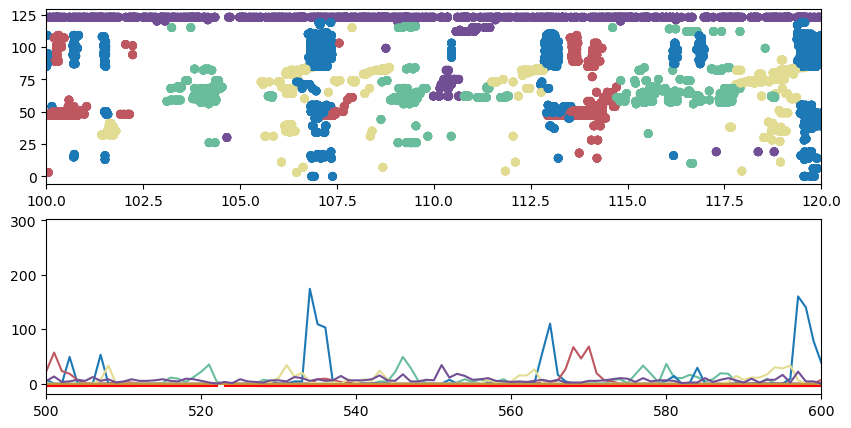

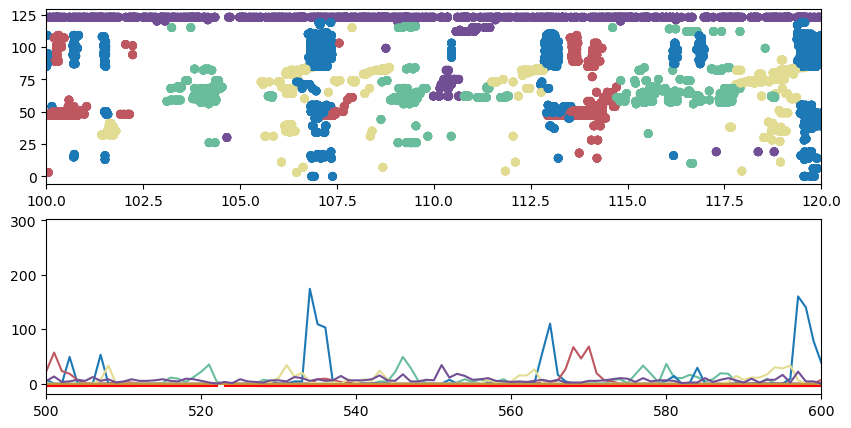

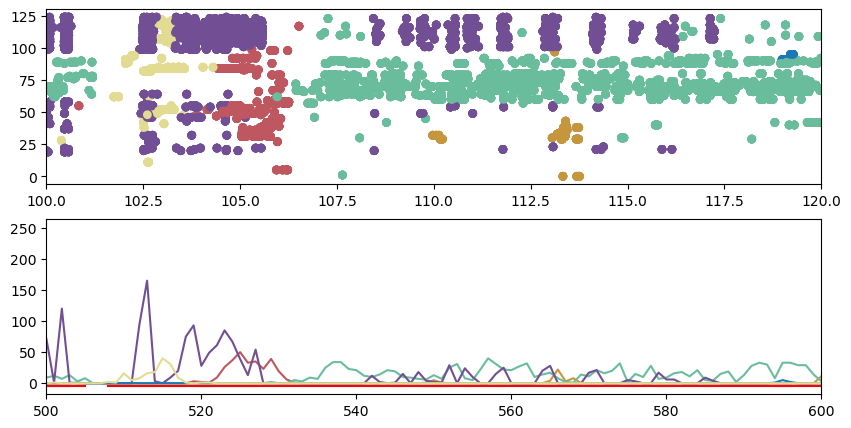

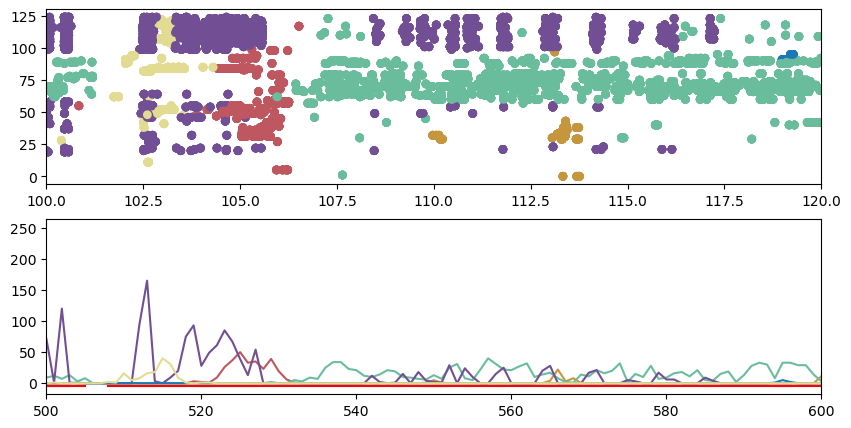

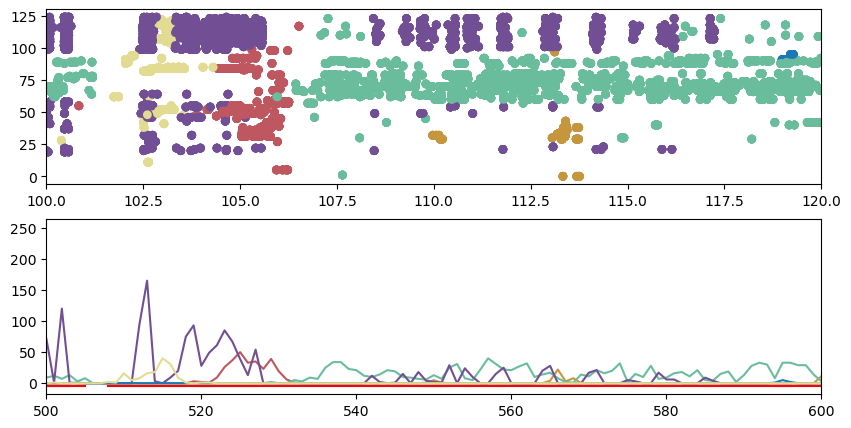

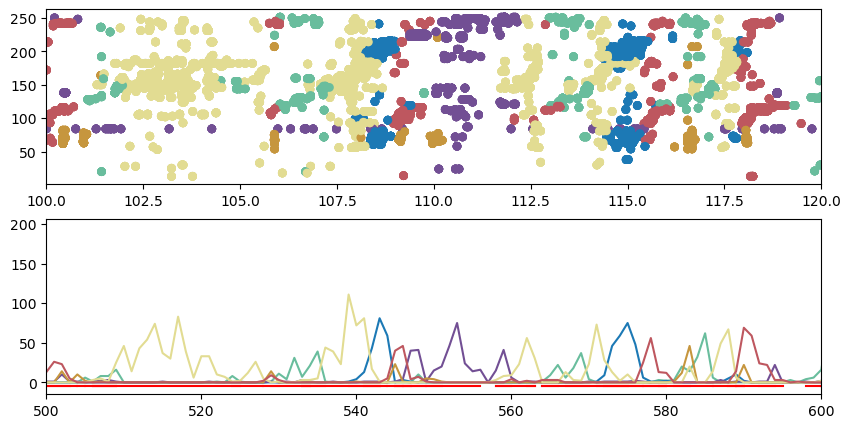

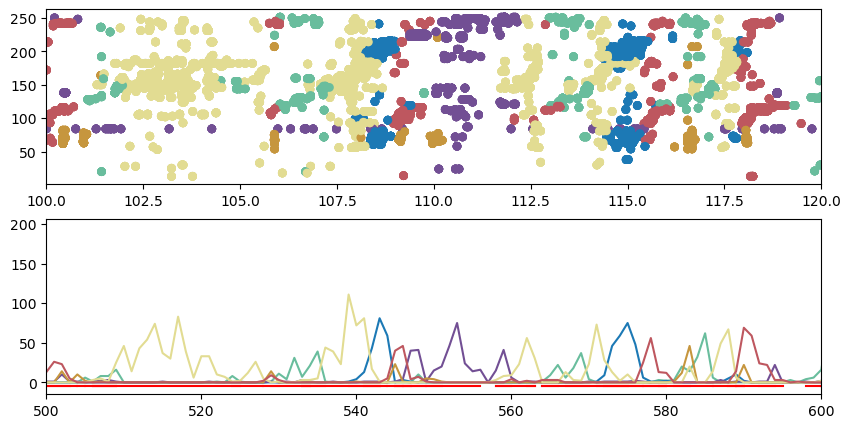

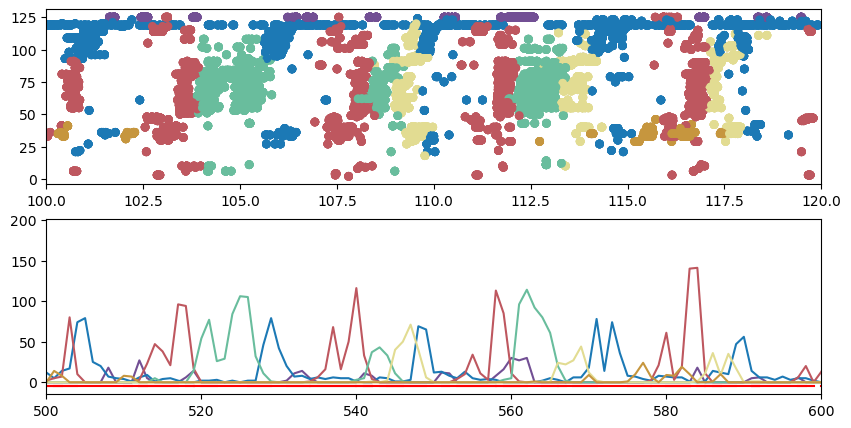

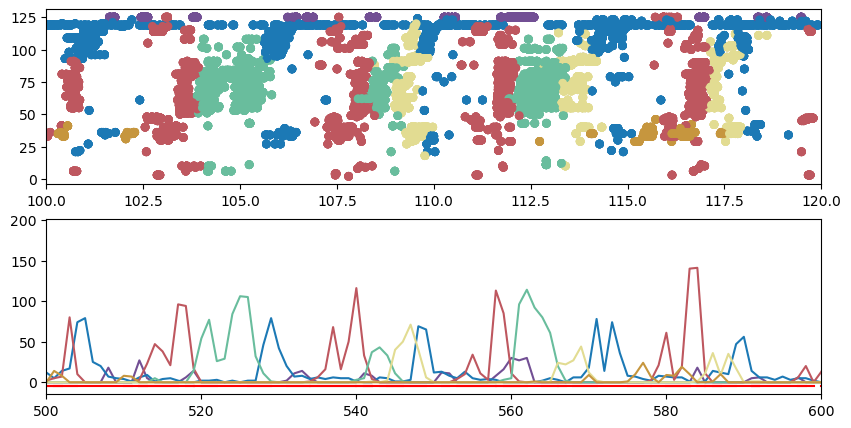

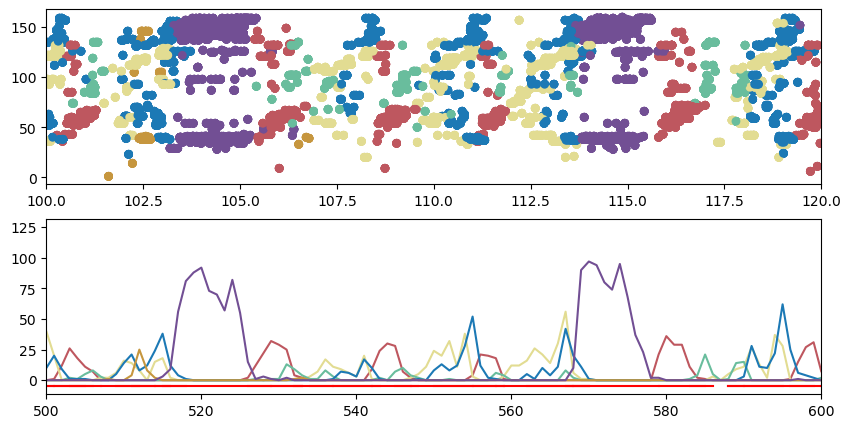

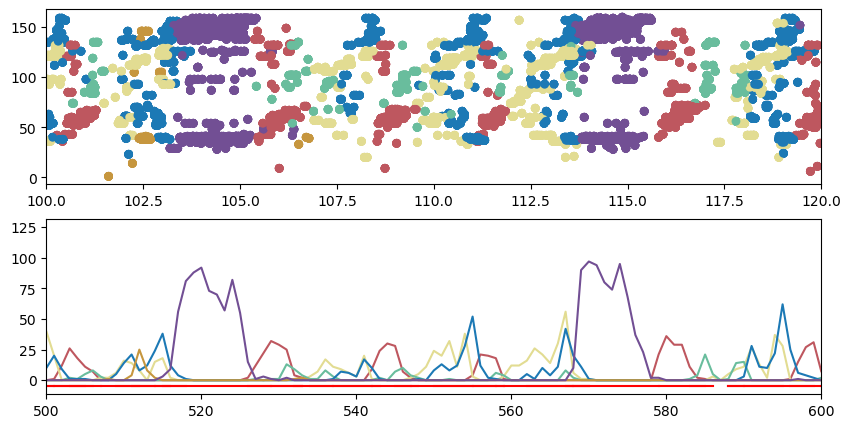

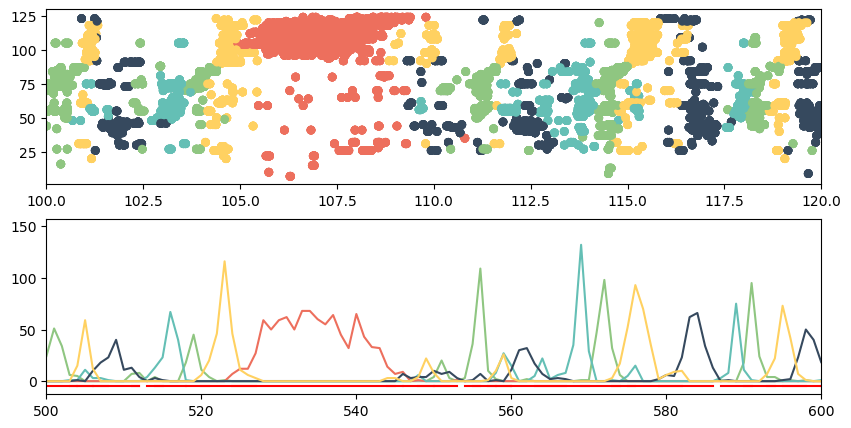

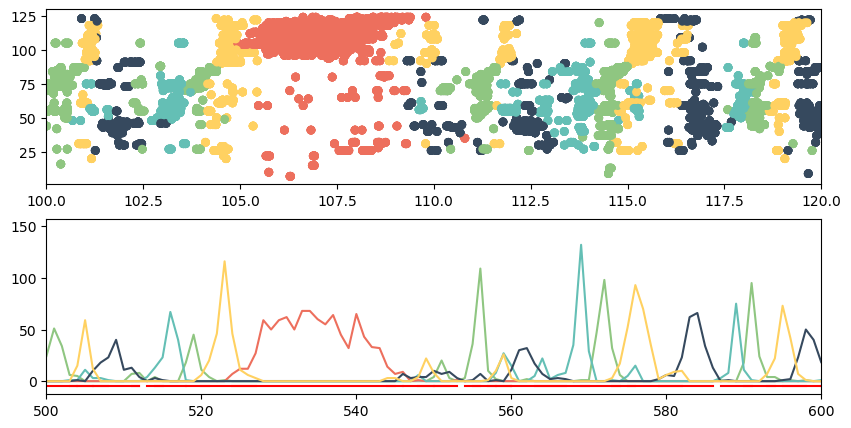

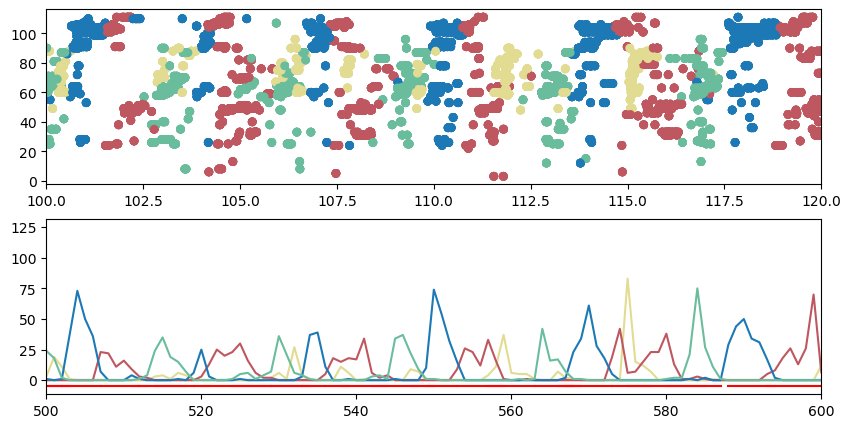

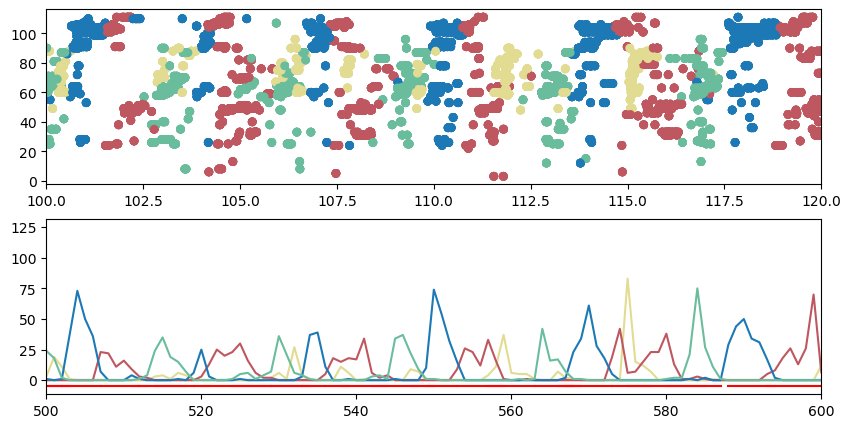

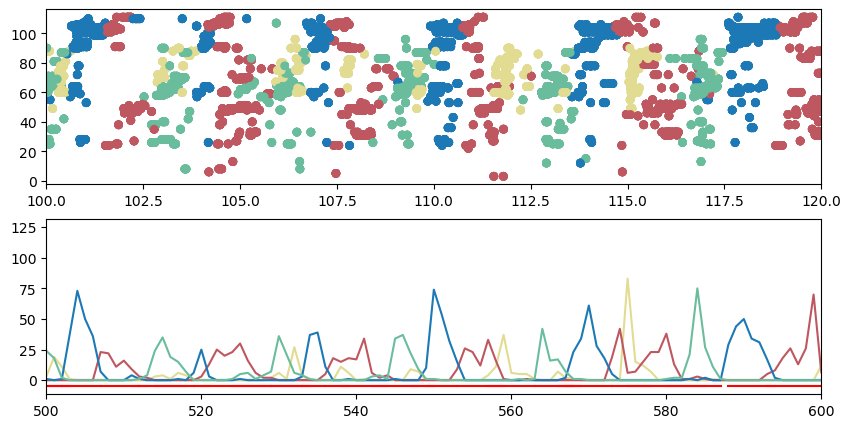

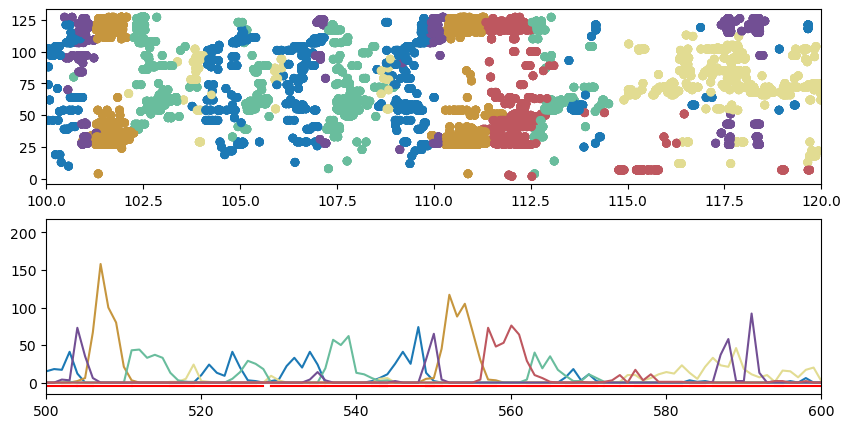

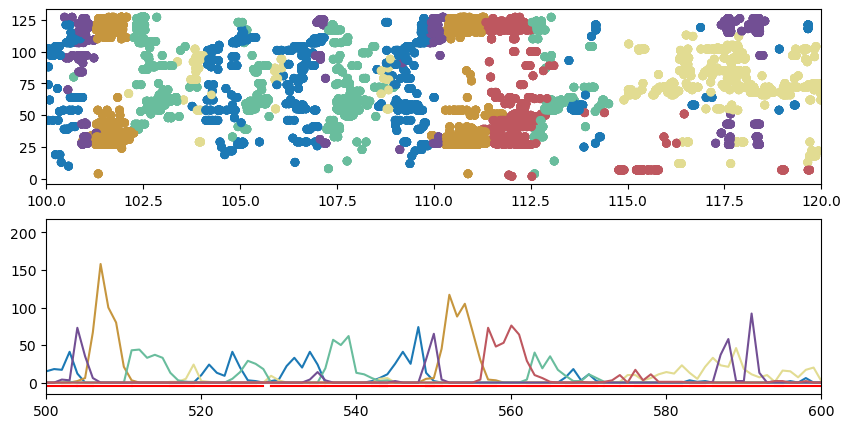

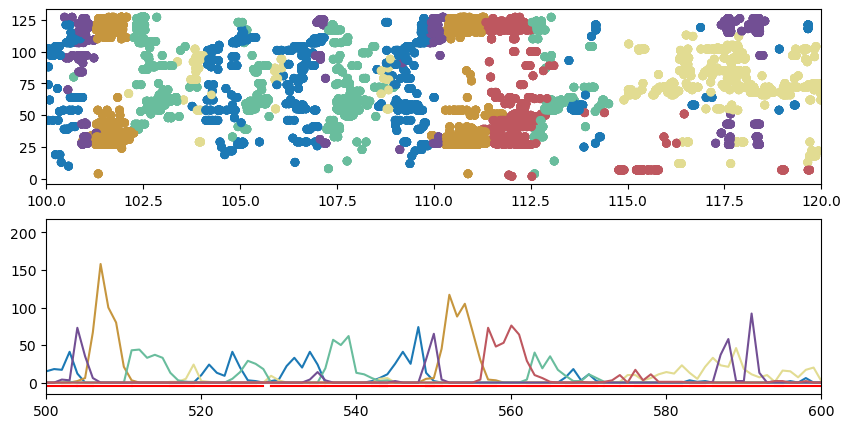

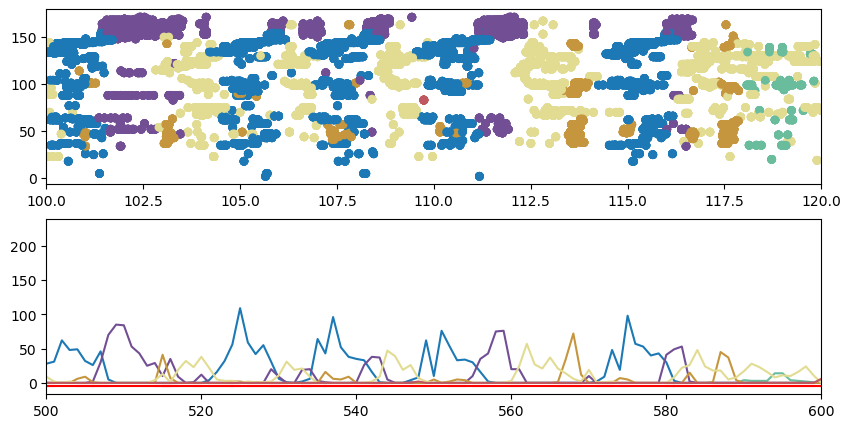

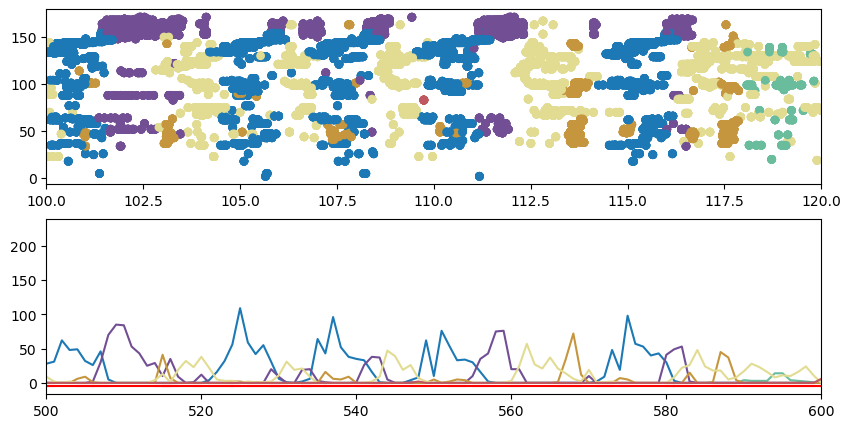

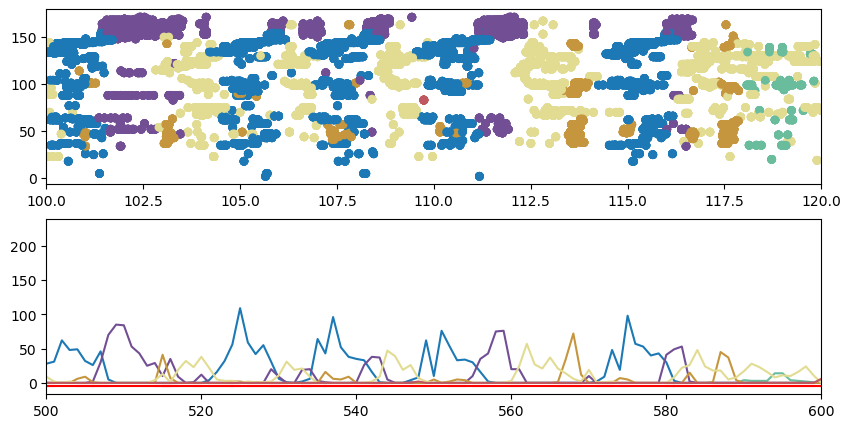

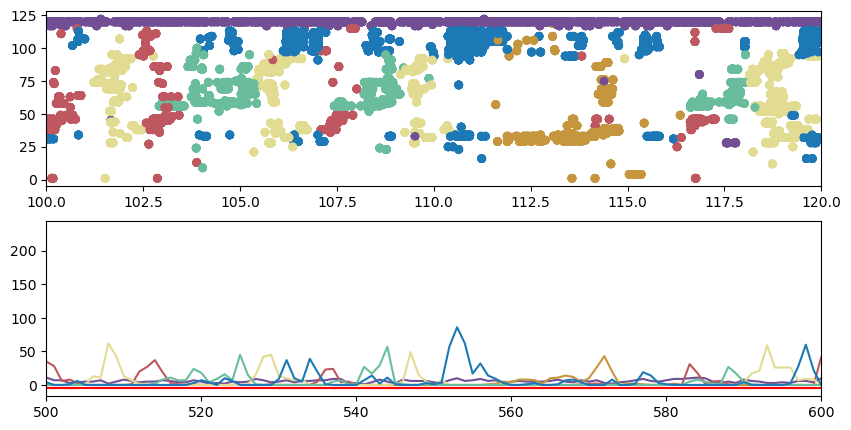

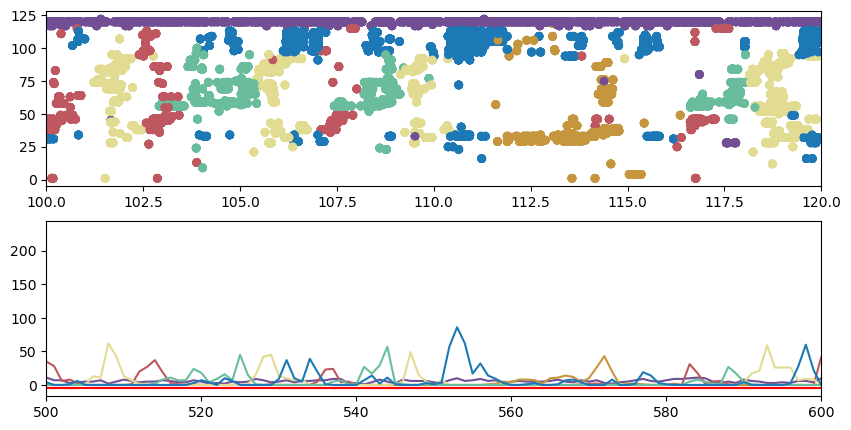

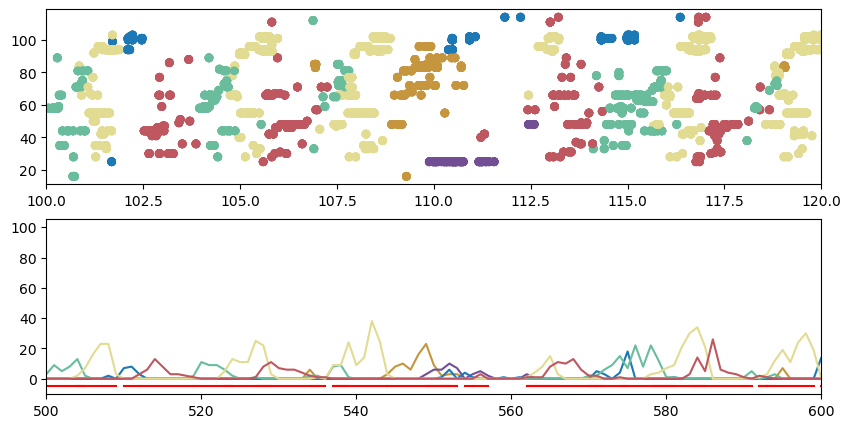

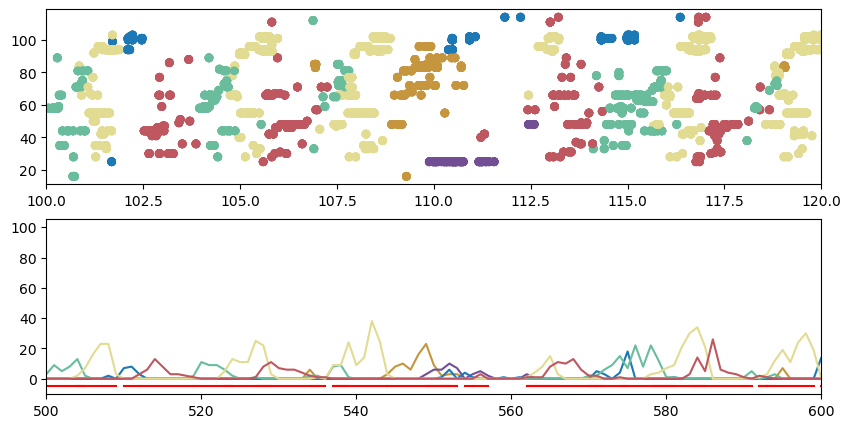

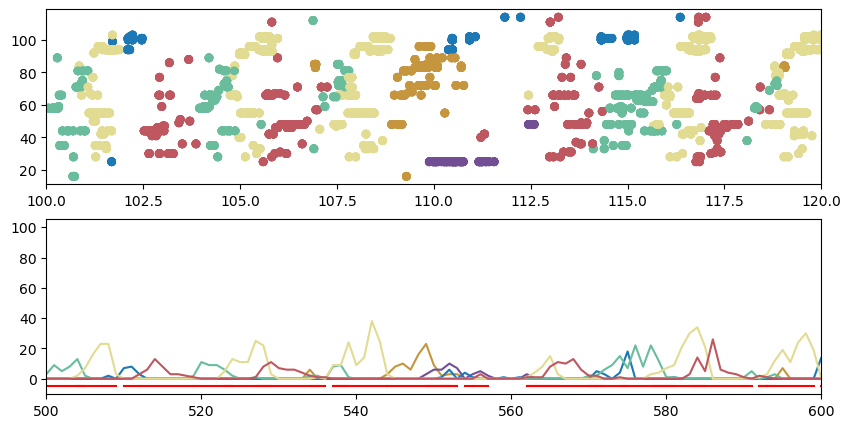

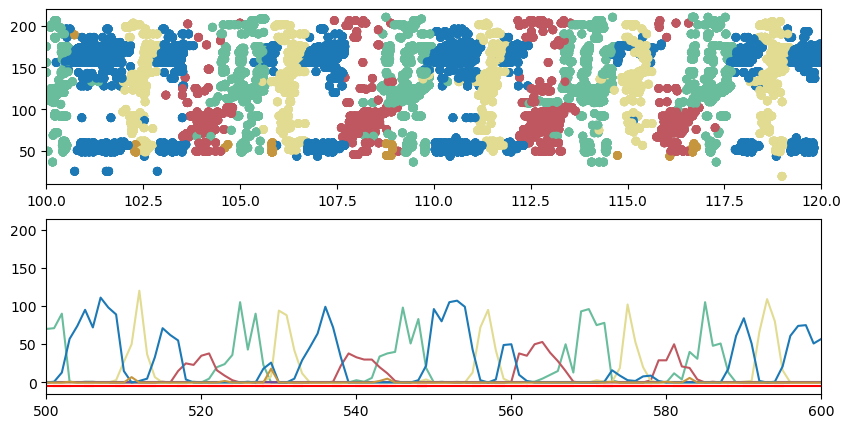

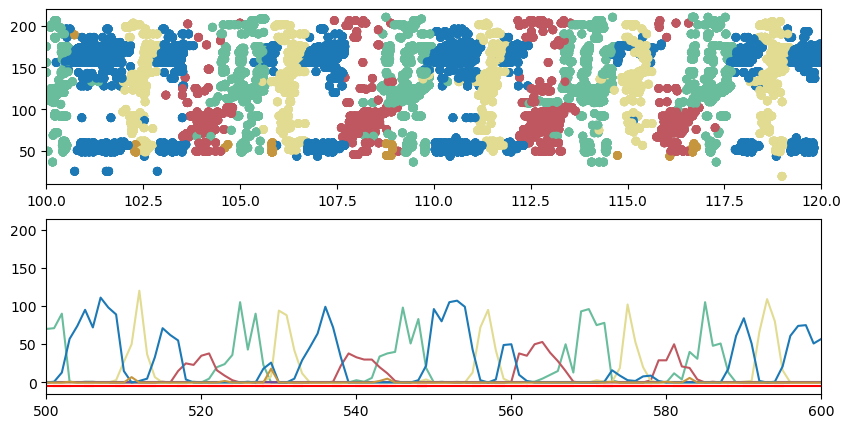

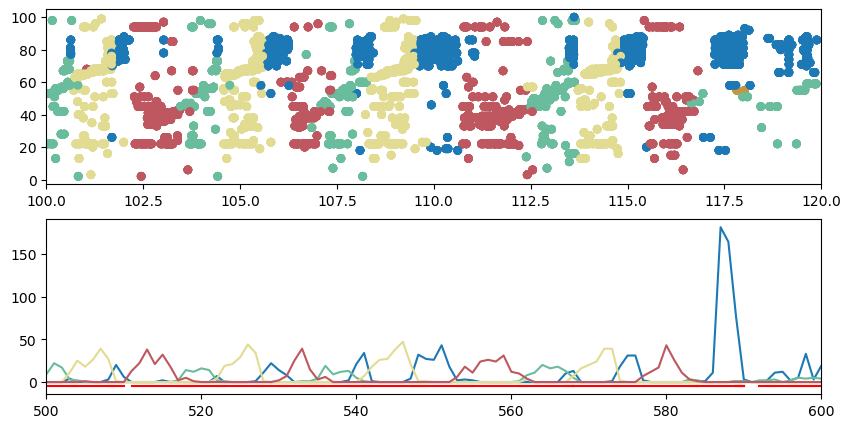

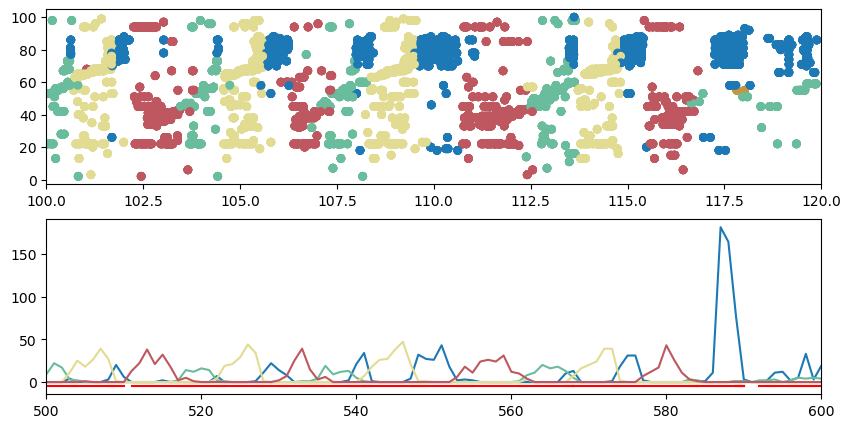

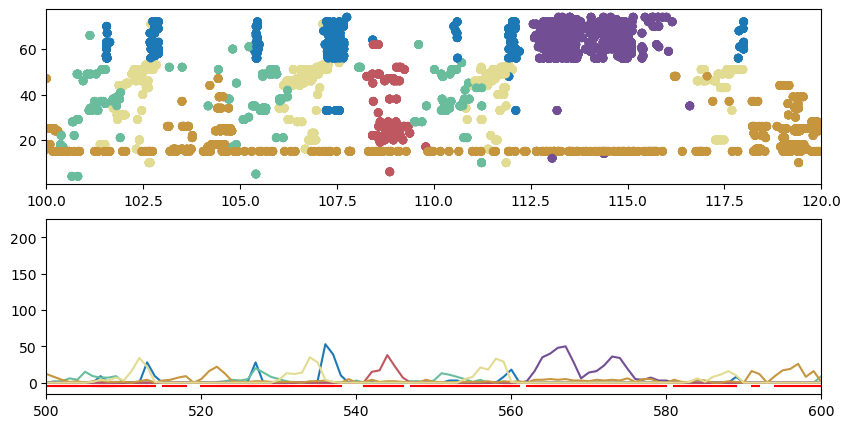

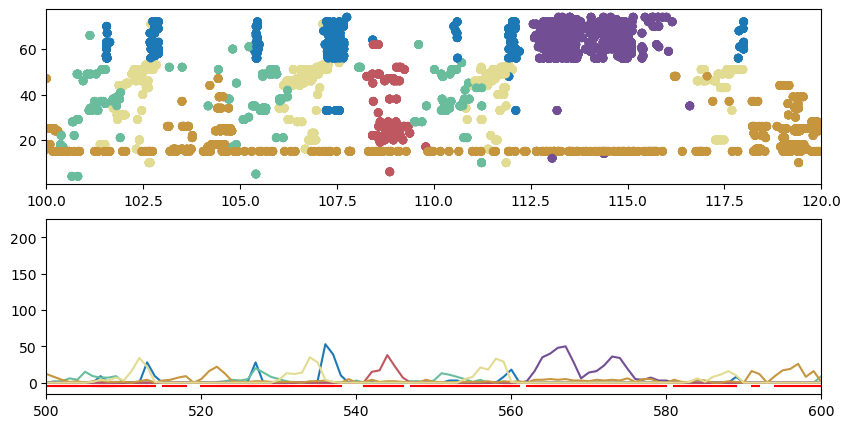

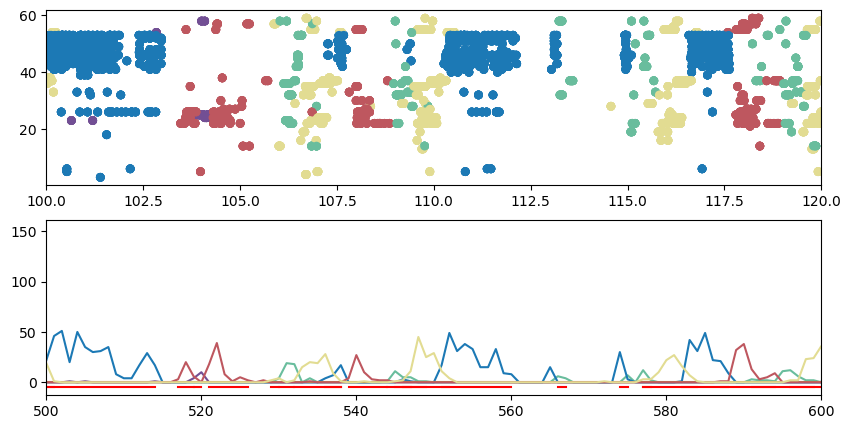

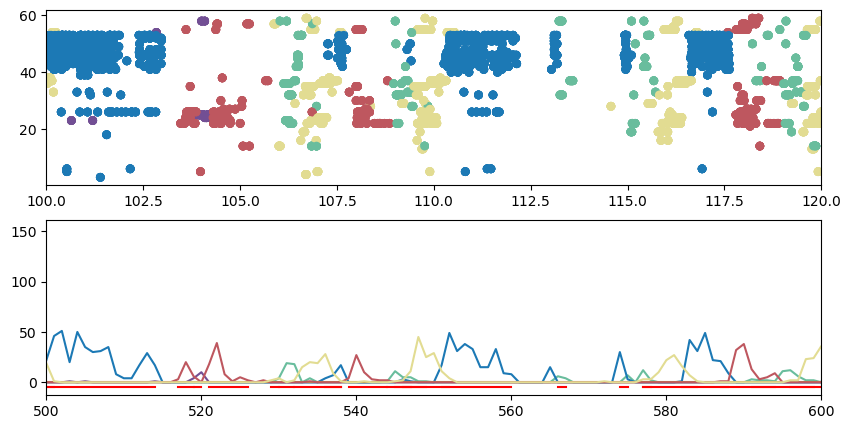

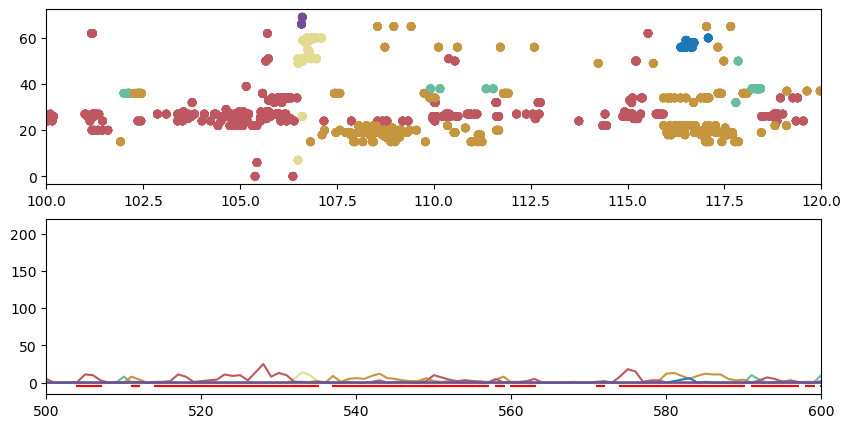

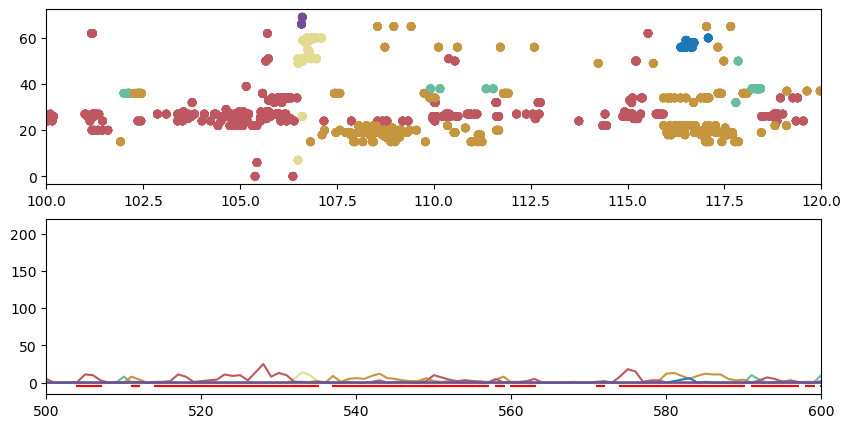

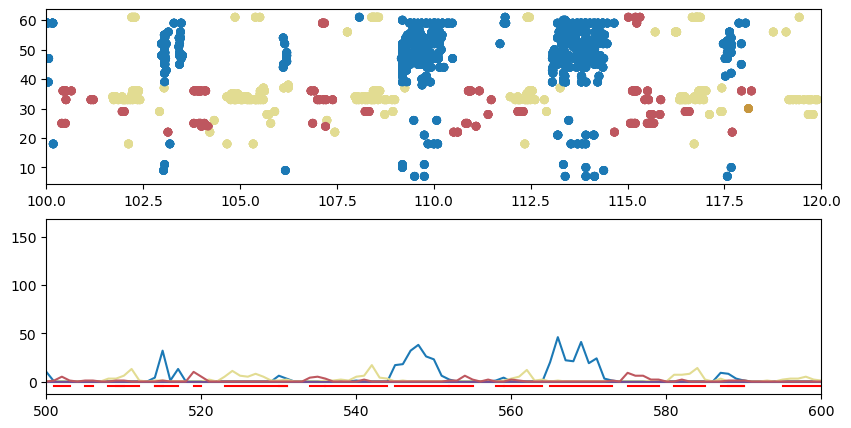

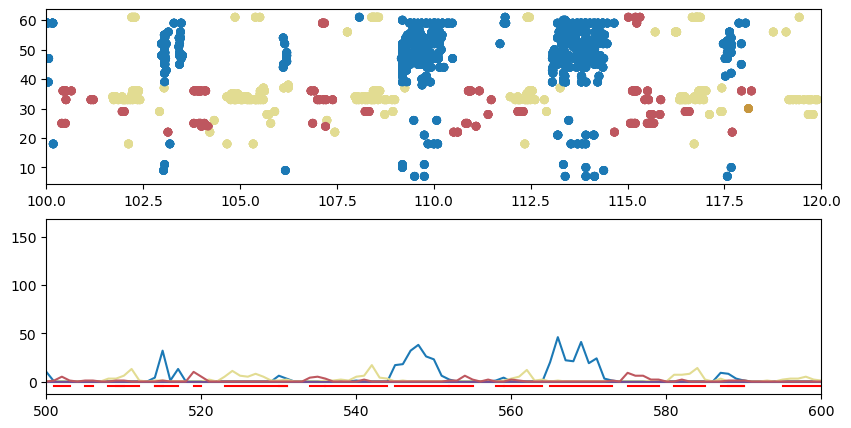

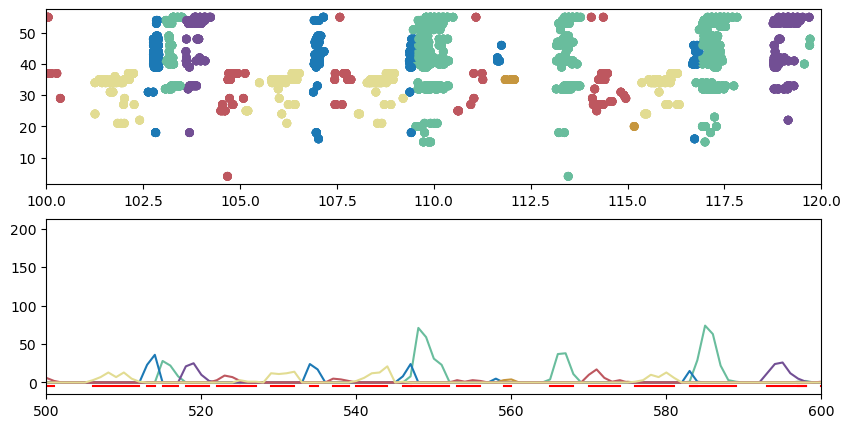

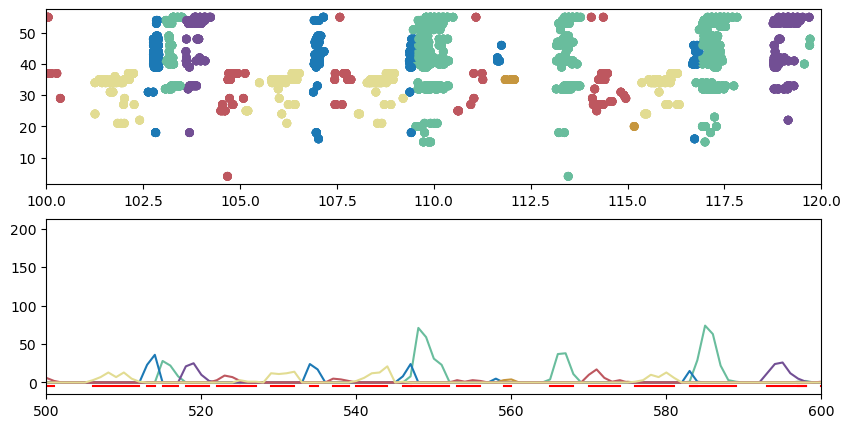

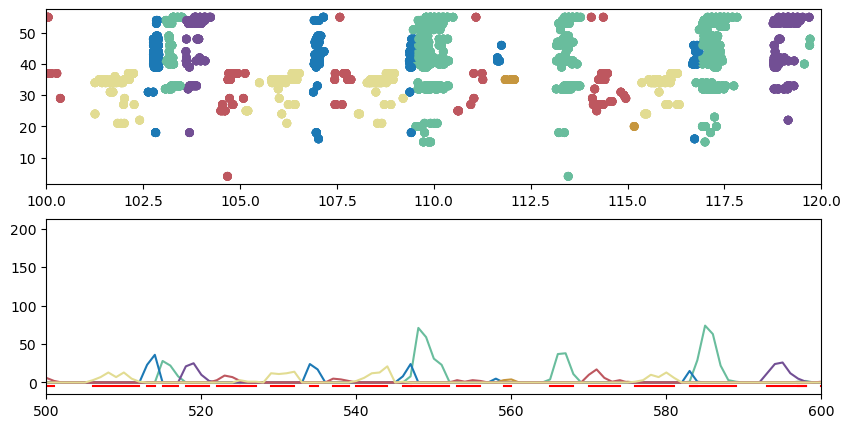

In [ ]:
all_animals = ['seq052_1_1','seq052_1_2','seq052_1_3','seq052_1_4','seq052_1_5','seq052_1_6','seq054_1_2','seq059_1_1','seq059_1_2','seq059_1_3','seq059_1_4','seq059_1_5','seq059_1_6']
group = ['saline','ap5','saline','ap5','saline','ap5','ap5','saline','ap5','saline','ap5','saline','ap5']


# initialize lists to hold data across animals 
animals = []
#1
reactivations_per_min = []
#2
event_lens = []
#3
regression_df= pd.DataFrame({'seq_type':[],'regression_line':[],'filt_rel_spike_times':[],'slope':[],'reactivation_ID':[],'warp_factor':[],'mouse':[]})
#4
binned_rate,bins_relative_so = [],[]
#5
start_end_df = pd.DataFrame({})
#6
AP5_coactive_freqs = {}
Saline_coactive_freqs = {}
# 7
ordered_misordered = []
# 8 
task_nontask = []
#9
Saline_awake_seqbyseq_neuron_involvements= [[]]*6
Saline_sleep_seqbyseq_neuron_involvements= [[]]*6
AP5_awake_seqbyseq_neuron_involvements= [[]]*6
AP5_sleep_seqbyseq_neuron_involvements= [[]]*6
# 10 
neuron_rel_awake_positions_reverse = []
neuron_rel_reverse_replay_positions = []
neuron_rel_awake_positions_forwards = []
neuron_rel_forward_replay_positions = []

# load in sleep time points

sleep_start = {}
if 'Pre_sleep' in dat_path:
    for mouse_file in os.listdir(dat_path):
        mouse = mouse_file.split('_run')[0] 
        sleep_start[mouse] = 0
else: 
    sleep_time_point_df = pd.read_csv(dat_path + 'sleep_time_points.csv')
    # decide when sleep started
    sleep_start = {}
    for index,value in enumerate(sleep_time_point_df.approx_sleep_start.values):
        mouse = sleep_time_point_df.mir.values[index]
        sleep_start[mouse] = value

for index, mouse_file in enumerate(os.listdir(dat_path)):
    if not 'run' in mouse_file:
        continue
    replay_data_found = False
    print('----------')
    print(mouse_file)
    mouse = '_'.join(mouse_file.split('_')[0:3])
    animals += [mouse]
    print(index)
    current_mouse_p = os.path.join(dat_path, mouse_file)
    if '_final_analysis_output' in os.listdir(current_mouse_p):

        # load in replay data 
        for run_index,pp_file in enumerate(os.listdir(dat_path)):
            if mouse_file in pp_file:
                print(mouse_file)
                # set path to processed files 
                current_mouse_path = dat_path + pp_file + '\\_final_analysis_output'
                print('replay data path found: ' + current_mouse_path)
                replay_data_found = True
                
                # load in sleep start time 
                current_sleep_start = sleep_start[mouse]
                params_file = dat_path + pp_file + r'\trainingData\\' + 'params_' + mouse + '.json'
                with open(params_file, 'r') as file:
                    params = json.load(file)
                time_spans = params['time_span']
                            
                break

    if not replay_data_found:
        print('No replay data found for ' + mouse_file)
        continue
    
    # rpm
    chunk_rpm= []
    # event lengths
    chunk_event_lens = []
    # decay 
    chunk_binned_rate,chunk_bins_relative_so = [],[]
    # coactive freqs
    coactive_freqs_chunk  = {}
    # ordered vs misordered
    chunk_ordered_misordered_proportions = []
    # task vs non task related events
    nontask_task_chunk = []
    # awake seq by seq neuron involvements
    chunk_mouse_neuron_rel_awake_positions_reverse = []
    chunk_mouse_neuron_rel_reverse_replay_positions = []
    chunk_mouse_neuron_rel_awake_positions_forwards = []
    chunk_mouse_neuron_rel_forward_replay_positions = []
    
    ## loop across all chunk files ################################
    for chunk_number,file in enumerate(os.listdir(current_mouse_path)):
        if 'chunk' in file:
            print(file)
            current_data_path = current_mouse_path + '\\' + file + '\\'
            chunk_time = np.load(current_data_path + 'chunk_time_interval.npy')
            data = pd.read_csv(current_data_path + 'filtered_replay_clusters_df.csv')
            
            ###### FILTERING AND MASKING ##################################################################''
            ## filter this data for sequential ordering
            sequential_condition = data.ordering_classification == 'sequential'
            # filter is set up so that any true will carry forward 
            filtered_chunk_data = data[sequential_condition].reset_index()
            
            
            ## REM / NREM times only
            # load in sleep state scoring
            nrem_start_ends,rem_start_ends,mouse_org_data_path,old_data = load_in_sleep_state_scoring(mouse)
            # get relevant rem/nrem times for chunk
            chunk_nrem_times = get_chunk_state_times(nrem_start_ends,chunk_time)
            chunk_rem_times = get_chunk_state_times(rem_start_ends,chunk_time) 
            # get spike times relative to chunk:
            chunk_number = int(file.split('_')[0][-1])
            chunk_start_offset = ([0]+list(np.cumsum(np.diff(time_spans))))[chunk_number-1]
            # make relative to start of chunk
            fs_event_times = filtered_chunk_data['first_spike_time'].values - chunk_start_offset
            # find inds of spike times that are in nrem and rem periods:
            idx  = []
            for start,end in chunk_nrem_times + chunk_rem_times:
                idx += list(np.where((fs_event_times >= start) & (fs_event_times <= end))[0])
            # filter the data frame, only keeping the rows in idx
            filtered_chunk_data = filtered_chunk_data.iloc[idx]
            filtered_chunk_data = filtered_chunk_data.reset_index(drop=True)
            
            # 1. REACTIVATION PER MINUTE: #######################################################################
            interval = float(sum([np.diff(item) for item in chunk_nrem_times]) + sum([sum(item) for item in chunk_rem_times]))
            mins = interval/60
            if mins > 0:
                chunk_rpm += [len(filtered_chunk_data)/mins]
            else:
                chunk_rpm += [np.nan]
              
            # 2. REACTIVATION EVENT LENGTH #######################################################################
            chunk_event_lens += list(filtered_chunk_data.event_length.values)
            
            #3. WARP #######################################################################
            current_data_path_temporal_structre = current_data_path + 'temporal_structure_analysis\\'
            # load in regression dfs
            df_load = pd.read_csv(current_data_path_temporal_structre+'regression_df.csv',index_col=0)
            df_load['mouse'] = [mouse]*len(df_load)
            #concat:
            regression_df = pd.concat((regression_df,df_load),axis =0)
            
            #4 DECAY FROM SLEEP ONSET #######################################################################
            if len(filtered_chunk_data) > 0:
                binned_rate_current,bins_relative_so_current = return_binned_replay_rate(file, filtered_chunk_data, time_spans, current_sleep_start)
                if not binned_rate == 'nan':
                    chunk_binned_rate += [binned_rate_current]
                    chunk_bins_relative_so += [bins_relative_so_current]
                    
            #5.START - END POINTS ################################################
            start_end_df = load_start_end_dfs(mouse,start_end_df,current_data_path_temporal_structre,chunk_number)
            
            # 6. COACTIVE FREQUENCY ################################################
            event_proximity_filter= 0.3
            coactive_freqs_chunk,filtered_chunk_data_coactive = determine_relative_coactivity_per_chunk(filtered_chunk_data, event_proximity_filter, coactive_freqs_chunk)
           
            # 7. ORDERING PROPORTIONS ################################################
            ##Load in seq order data
            if 'Pre_sleep' in dat_path:
                sequence_order_df = pd.read_csv("Z:\projects\sequence_squad\ppseq_finalised_publication_data\sequence_order.csv")
            else:
                sequence_order_df = pd.read_csv(remove_last_folder(dat_path)+"//sequence_order.csv")
            # calculate ordering proportions for each chunk
            chunk_ordered_misordered_proportions += [calculate_ordering_proportions(filtered_chunk_data_coactive,mouse,sequence_order_df)]
            
            # 8. TASK RELATED EVENTS ################################################
            # pull out sequence order for current mouse
            seq_order= ast.literal_eval(sequence_order_df[sequence_order_df.mir == mouse].seq_order.values[0])
            num_dominant_seqs = int(sequence_order_df.loc[sequence_order_df.mir == mouse, "dominant_task_seqs"].iat[0])
            real_order = np.array(seq_order)+1
            # get taks and non task related stuff from each chunk
            nontask_task_chunk += [determine_task_related_events(filtered_chunk_data, sequence_order_df,mouse,real_order)]
            
            
            ## 9. NEURON INVOLVEMENT ANALYSIS
            if 'Pre_sleep' in dat_path:
                awake_PP_path = r"Z:\projects\sequence_squad\ppseq_finalised_publication_data\expert\awake\\"
            else:
                awake_PP_path = os.path.join(remove_last_folder(dat_path),'awake\\')
            awake_PP_path_base = os.path.join(awake_PP_path,[file for file in os.listdir(awake_PP_path) if mouse in file][0]) + '\\'
    
            ######### load awake stuff ############
            ### load in awake ppseq data for mouse
            with open(awake_PP_path_base + r'analysis_output\\' + 'spikes_seq_type_adjusted.pickle', 'rb') as handle:
                unmasked_spikes_df = pickle.load(handle)

            with open(awake_PP_path_base + r'analysis_output\reordered_recolored\\' + 'neuron_order', 'rb') as handle:
                awake_neuron_order = pickle.load(handle)

            colors = pd.read_pickle(awake_PP_path_base + r"analysis_output\reordered_recolored\\" + 'colors')

            #load json
            import json
            params = None
            for file in os.listdir(awake_PP_path_base + r'\trainingData\\'):
                if 'json' in file:
                    param_path = os.path.join(awake_PP_path_base + r'\trainingData\\', file)
                    with open(param_path,'r') as f:
                        params = json.load(f)
                    awake_time_span = params['time_span'][0]
                    
            ##### get awake seq neuron involvement 
            # cluster the awake spikes into individual sequence events
            seq_event_dfs = process_awake_data_return_seq_dfs(unmasked_spikes_df,awake_time_span,awake_neuron_order,colors,[100,120])
            # get awake neuron involevements
            seq_by_seq_awake_mean_neuron_motif_involvements = determine_awake_neuron_motif_involvements(unmasked_spikes_df, seq_event_dfs)
            # add to save out array:
            
            if mouse in np.array(all_animals)[np.array(group) == 'saline']:
                for i,item in enumerate(seq_by_seq_awake_mean_neuron_motif_involvements):
                    Saline_awake_seqbyseq_neuron_involvements[i] += [item]
                # same for sleep
                seq_by_seq_sleep_mean_neuron_motif_involvements = determine_sleep_neuron_motif_involvements(filtered_chunk_data,unmasked_spikes_df)
                for i,item in enumerate(seq_by_seq_sleep_mean_neuron_motif_involvements):
                    Saline_sleep_seqbyseq_neuron_involvements[i] += [item]
            elif mouse in np.array(all_animals)[np.array(group) == 'ap5']:
                for i,item in enumerate(seq_by_seq_awake_mean_neuron_motif_involvements):
                    AP5_awake_seqbyseq_neuron_involvements[i] += [item]
                # same for sleep
                seq_by_seq_sleep_mean_neuron_motif_involvements = determine_sleep_neuron_motif_involvements(filtered_chunk_data,unmasked_spikes_df)
                for i,item in enumerate(seq_by_seq_sleep_mean_neuron_motif_involvements):
                    AP5_sleep_seqbyseq_neuron_involvements[i] += [item]
            
            # 10 awake vs sleep, neuron position in sequences
            chunk_mouse_neuron_rel_awake_positions_reverse += list(np.load(current_data_path_temporal_structre + 'neuron_rel_awake_positions_reverse.npy'))
            chunk_mouse_neuron_rel_reverse_replay_positions += list(np.load(current_data_path_temporal_structre + 'neuron_rel_reverse_replay_positions.npy'))
            chunk_mouse_neuron_rel_awake_positions_forwards += list(np.load(current_data_path_temporal_structre + 'neuron_rel_awake_positions_forwards.npy'))
            chunk_mouse_neuron_rel_forward_replay_positions += list(np.load(current_data_path_temporal_structre + 'neuron_rel_forward_replay_positions.npy'))

    # outside of chunk loop ################################################
    ### add to animal vars      
    # 1 rpm   
    reactivations_per_min += [np.nanmean(chunk_rpm)]
    #2 event lengths
    event_lens += [np.mean(chunk_event_lens)]
    # 4 decay 
    binned_rate += [chunk_binned_rate]
    bins_relative_so += [chunk_bins_relative_so]
    #6 coactive 
    

    if mouse in np.array(all_animals)[np.array(group) == 'saline']:
        
        for key in coactive_freqs_chunk:
            if key in AP5_coactive_freqs:
                AP5_coactive_freqs[key] += [np.mean(coactive_freqs_chunk[key])]
            else:
                AP5_coactive_freqs[key] = [np.mean(coactive_freqs_chunk[key])]
                
    elif mouse in np.array(all_animals)[np.array(group) == 'ap5']:
            
        for key in coactive_freqs_chunk:
            if key in Saline_coactive_freqs:
                Saline_coactive_freqs[key] += [np.mean(coactive_freqs_chunk[key])]
            else:
                Saline_coactive_freqs[key] = [np.mean(coactive_freqs_chunk[key])]
                

    #7. ordered misordered
    # ordered_misordered += [[np.nanmean([item[0] for item in chunk_ordered_misordered_proportions]),np.nanmean([item[1] for item in chunk_ordered_misordered_proportions])]]
    
    ordered_misordered += [calculate_ordered_proportion(chunk_ordered_misordered_proportions)]

    
    # 8. task related events
    task_nontask += [get_normalised_task_related_proportions(nontask_task_chunk,real_order)]
    # 10 awake seq by seq neuron involvements
    neuron_rel_awake_positions_reverse += [chunk_mouse_neuron_rel_awake_positions_reverse]
    neuron_rel_reverse_replay_positions += [chunk_mouse_neuron_rel_reverse_replay_positions]
    neuron_rel_awake_positions_forwards += [chunk_mouse_neuron_rel_awake_positions_forwards]
    neuron_rel_forward_replay_positions += [chunk_mouse_neuron_rel_forward_replay_positions]
    

#################################################################################################################
# save all this data out as a big dictionary, json pickle or something  

# 1) Convert DataFrames to dicts (list-of-records)
regression_records = regression_df.to_dict(orient='records')
start_end_records  = start_end_df.to_dict(orient='records')

# 2) If you have any NumPy arrays, do arr.tolist() here:
# e.g. 
# some_np_array = np.array([...])
# some_list = some_np_array.tolist()

# 3) Build the master dict
master = {
    "animals": animals,
    "reactivations_per_min": reactivations_per_min,
    "event_lens": event_lens,
    "regression": regression_records,
    "binned_rate": binned_rate,
    "bins_relative_so": bins_relative_so,
    "start_end": start_end_records,
    "ordered_misordered": ordered_misordered,
    "AP5_coactive_freqs" : AP5_coactive_freqs,
    "Saline_coactive_freqs":Saline_coactive_freqs,
    "task_nontask": task_nontask,
    "Saline_awake_seqbyseq_neuron_involvements":Saline_awake_seqbyseq_neuron_involvements,
    "Saline_sleep_seqbyseq_neuron_involvements":Saline_sleep_seqbyseq_neuron_involvements,
    "AP5_awake_seqbyseq_neuron_involvements":AP5_awake_seqbyseq_neuron_involvements,
    "AP5_sleep_seqbyseq_neuron_involvements":AP5_sleep_seqbyseq_neuron_involvements,
    "neuron_rel_awake_positions_reverse": neuron_rel_awake_positions_reverse,
    "neuron_rel_reverse_replay_positions": neuron_rel_reverse_replay_positions,
    "neuron_rel_awake_positions_forwards": neuron_rel_awake_positions_forwards,
    "neuron_rel_forward_replay_positions": neuron_rel_forward_replay_positions,
}

out_path = r"Z:\projects\sequence_squad\revision_data\emmett_revisions\AP5_data\processed\\"

#if this folder does not exist, make it, if it already exists delete it and remake it
if os.path.exists(out_path):
    shutil.rmtree(out_path)
os.makedirs(out_path)

with open(out_path + "//processed_replay_data.pkl", "wb") as f:
    pickle.dump(master, f)


'seq006_1_11'

array(['seq052_1_1', 'seq052_1_3', 'seq052_1_5', 'seq059_1_1',
       'seq059_1_3', 'seq059_1_5'], dtype='<U10')

In [167]:
np.array(animals)[np.array(group) == 'ap5']

array(['seq052_1_2', 'seq052_1_4', 'seq052_1_6', 'seq054_1_2',
       'seq059_1_2', 'seq059_1_4', 'seq059_1_6'], dtype='<U10')

In [38]:
mouse

'seq006_1_11'

# reload the data 

In [202]:
#Load the pickled files

with open(r"Z:\projects\sequence_squad\revision_data\emmett_revisions\AP5_data\processed\\" + "processed_replay_data.pkl", 'rb') as f:
    AP5_master = pickle.load(f)

animals = ['seq052_1_1','seq052_1_2','seq052_1_3','seq052_1_4','seq052_1_5','seq052_1_6','seq054_1_2','seq059_1_1','seq059_1_2','seq059_1_3','seq059_1_4','seq059_1_5','seq059_1_6']
group = ['saline','ap5','saline','ap5','saline','ap5','ap5','saline','ap5','saline','ap5','saline','ap5']


ap5_mask = np.array(group) == 'ap5'
saline_mask = np.array(group) == 'saline'

def split_dict_by_mask(data: dict, mask: list[bool]):
    dict_true = {k: [v for v, m in zip(vals, mask) if m] for k, vals in data.items()}
    dict_false = {k: [v for v, m in zip(vals, mask) if not m] for k, vals in data.items()}
    return dict_true, dict_false

ap5_mask = np.array(group) == 'ap5'
AP5_dict, Saline_dict = split_dict_by_mask(AP5_master,ap5_mask)

In [ ]:
#AP5: n = 3 mice, 7 different implants (shanks), 7 sessions 
#SALINE: n = 2 mice, 6 different implants (shanks), 6 sessions 

# plotting functions

In [154]:

from scipy import stats
import pingouin as pg

def effect_size(x=None, y=None, test='ttest', dv=None, between=None, data=None,
                dm=None, grouping=None, popmean=None, permutations=999):
    """
    Calculate effect sizes for parametric, non-parametric, regression, and PERMANOVA.

    Parameters
    ----------
    x : array-like
        First sample (or single sample for one-sample t-test)
    y : array-like, optional
        Second sample (if applicable)
    test : str
        One of ['ttest', 'paired_ttest', 'one_sample_ttest', 'anova',
                'mannwhitney', 'wilcoxon', 'kruskal', 'correlation', 'permanova']
    dv, between, data : for ANOVA/Kruskal (pingouin syntax)
    dm : DistanceMatrix for PERMANOVA
    grouping : array-like of group labels for PERMANOVA
    popmean : population mean for one-sample t-test
    permutations : number of permutations for PERMANOVA
    """
    # Convert to numpy arrays if needed
    x = np.array(x) if x is not None else None
    y = np.array(y) if y is not None else None

    if test == 'ttest':  # independent
        t, p = stats.ttest_ind(x, y)
        pooled_std = np.sqrt(((len(x)-1)*x.std(ddof=1)**2 + (len(y)-1)*y.std(ddof=1)**2) / (len(x)+len(y)-2))
        d = (x.mean() - y.mean()) / pooled_std
        return {"cohens_d": d}

    elif test == 'paired_ttest':
        t, p = stats.ttest_rel(x, y)
        d = (x - y).mean() / (x - y).std(ddof=1)
        return {"cohens_d": d}

    elif test == 'one_sample_ttest':
        if popmean is None:
            raise ValueError("popmean must be provided for one-sample t-test")
        t, p = stats.ttest_1samp(x, popmean)
        d = (x.mean() - popmean) / x.std(ddof=1)
        return {"cohens_d": d}

    elif test == 'anova':
        res = pg.anova(dv=dv, between=between, data=data, detailed=True)
        return res[['Source', 'F', 'p-unc', 'eta-square', 'partial_eta-square']]

    elif test == 'mannwhitney':
        res = pg.mwu(x, y, alternative='two-sided')
        return {"test": "Mann-Whitney U", "U": res['U-val'][0], "p": res['p-val'][0], "rank_biserial_r": res['RBC'][0]}

    elif test == 'wilcoxon':
        res = pg.wilcoxon(x, y, alternative='two-sided')
        return {"test": "Wilcoxon signed-rank", "W": res['W-val'][0], "p": res['p-val'][0], "rank_biserial_r": res['RBC'][0]}

    elif test == 'kruskal':
        res = pg.kruskal(data=data, dv=dv, between=between)
        return res[['H', 'p-unc', 'eta-square', 'eps-square']]

    elif test == 'correlation':
        r, p = stats.pearsonr(x, y)
        return {"test": "Pearson correlation", "r": r, "p": p}

    else:
        raise ValueError(f"Unsupported test type: {test}")

    
# Parametric Tests

# Independent t-test	Cohen’s d
# Paired t-test	Cohen’s d (for paired samples)
# One-way ANOVA/MANOVA	Eta squared (η²), Partial eta squared
# Repeated-measures ANOVA	Partial eta squared
# Correlation (Pearson)	r (correlation coefficient itself is the effect size)
# one sides t test = cohens d 


# Non-parametric Tests

# Mann–Whitney U	Rank biserial correlation (r)
# Wilcoxon signed-rank	Rank biserial correlation (r)
# Kruskal–Wallis	Epsilon squared (ε²), sometimes Eta squared (η²)
# Correlation (Spearman / Kendall)	ρ (Spearman’s rho) or τ (Kendall’s tau) (the coefficients themselves are effect sizes)
# PERMANOVA - R2 statistic 

import statsmodels.api as sm
from statsmodels.multivariate.manova import MANOVA
from scipy.stats import shapiro, normaltest
from scipy.spatial.distance import pdist, squareform
from skbio.stats.distance import permanova, DistanceMatrix

def test_univariate_normality(x, y, alpha=0.05):
    """
    Performs Shapiro-Wilk and D'Agostino's tests on each axis.
    Prints p-values and a simple verdict.
    """
    for name, data in (('x', x), ('y', y)):
        W, p_sw = shapiro(data)
        K2, p_k2 = normaltest(data)
        print(f"--- {name}-axis ---")
        print(f" Shapiro–Wilk:    W={W:.3f}, p={p_sw:.3f} -> {'non-normal' if p_sw<alpha else 'normal'}")
        print(f" D’Agostino K²: K²={K2:.3f}, p={p_k2:.3f} -> {'non-normal' if p_k2<alpha else 'normal'}\n")


def print_manova_for_awake_sleep_neuron_positions(x,y,x2,y2):

    A = pd.DataFrame({'x': x,
                    'y': y})
    B = pd.DataFrame({'x': x2,
                    'y': y2})
    # Combine the data into one DataFrame
    data = pd.concat([A, B], axis=0)

    # Create a grouping variable
    groups = np.array(['A'] * len(x) + ['B'] * len(x2))

    # Perform MANOVA
    manova = MANOVA.from_formula('x + y ~ groups', data=data)

    # Print the MANOVA results
    # print(manova.mv_test())
    # print the p val 
    p_val = manova.mv_test().results['groups']['stat']['Pr > F'].values[0]
    print(f"pval = {p_val}")
    


import numpy as np
from scipy.spatial.distance import pdist, squareform
from skbio.stats.distance import DistanceMatrix, permanova

def print_permanova_for_awake_sleep_neuron_positions(x, y, x2, y2, permutations=999):
    """
    Perform PERMANOVA (adonis) on two groups of 2D points using scikit-bio.
    Prints the pseudo-F, p-value, and effect size R².

    Requires: pip install scikit-bio
    """
    # 1) Stack coordinates
    coords = np.vstack([
        np.column_stack([x, y]),
        np.column_stack([x2, y2])
    ])

    # 2) Compute the Euclidean distance matrix
    dist_array = squareform(pdist(coords, metric='euclidean'))

    # 3) Create sample IDs and grouping vector
    ids = [f"A{i+1}" for i in range(len(x))] + [f"B{i+1}" for i in range(len(x2))]
    grouping = ['A'] * len(x) + ['B'] * len(x2)

    # 4) Build a scikit-bio DistanceMatrix
    dm = DistanceMatrix(dist_array, ids)

    # 5) Run PERMANOVA
    result = permanova(distance_matrix=dm,
                       grouping=grouping,
                       permutations=permutations)

    # 6) Compute R² manually (effect size)
    # ss_total = sum of squared distances / n
    D = dm.data        # <-- this is the fix
    n = len(grouping)
    ss_total = np.sum(D**2) / n

    # ss_between: sum of squared group means
    group_labels = np.array(grouping)
    unique_groups = np.unique(group_labels)
    ss_between = 0
    for g in unique_groups:
        idx = np.where(group_labels == g)[0]
        Di = D[np.ix_(idx, idx)]
        ss_between += len(idx) * (Di.mean() ** 2)

    r2 = ss_between / ss_total

    print('***************************************************')
    print(result)
    # 7) Print summary
    print(f"PERMANOVA pseudo-F: {result['test statistic']:.5f}")
    print(f"PERMANOVA p-value: {result['p-value']:.5f}")
    print(f"PERMANOVA effect size R²: {r2:.5f}")



def plot_sleep_awake_spike_position(ax,x,y,color_):
    # Create a pandas DataFrame
    df = pd.DataFrame({'x': x, 'y': y})

    # Define bin edges for y-values
    bin_edges = np.linspace(0, 1, num=15)  # 5 bins from 0 to 1

    # Bin the data based on y-values
    df['bin'] = pd.cut(df['y'], bins=bin_edges)

    # Calculate the middle points of the bins
    bin_midpoints = (bin_edges[:-1] + bin_edges[1:]) / 2

    # Calculate the mean and standard deviation of each bin
    bin_means = df.groupby('bin')['x'].mean()
    bin_std = df.groupby('bin')['x'].std()

    # Plot

    ax.plot(bin_midpoints,bin_means,'o-', c = color_, markersize = 8)
    # plt.plot(bin_midpoints, bin_means, width=0.1, align='center', label='Mean')

    # Fill between mean line +- standard deviation
    plt.fill_between(bin_midpoints, bin_means - bin_std, bin_means + bin_std, color=color_, alpha=0.3)
    
    return bin_means.values,bin_midpoints

import scipy

def conactinate_nth_items(startlist):
    concatinated_column_vectors = []
    for c in range(len(max(startlist, key=len))):
        column = []
        for t in range(len(startlist)):
            if c <= len(startlist[t])-1:
                column = column + [startlist[t][c]]
        concatinated_column_vectors.append(column)
    return concatinated_column_vectors

def find_closest_example(numbers, examples):
    # Initialize dictionaries to store the closest example and example totals
    closest_examples = {}
    example_totals = {example: 0 for example in examples}

    # Iterate over each number in the list
    for number in numbers:
        # Initialize a variable to keep track of the closest example
        closest_example = None
        min_distance = float('inf')  # Initialize the minimum distance to infinity

        # Compare the number with each example
        for example in examples:
            # Calculate the absolute difference between the number and example
            distance = abs(number - example)

            # Check if the current example is closer than the previous closest example
            if distance < min_distance:
                min_distance = distance
                closest_example = example

        # Update the closest example for the current number in the dictionary
        closest_examples[number] = closest_example

        # Increment the total count for the closest example
        example_totals[closest_example] += 1

    return closest_examples, example_totals

def relative_warp_values(e_f_warp_factors):
    rels = []
    for item in e_f_warp_factors:
        if sum(item) > 0:
            # normalize the warp factors to sum to 1
            rels += [list(np.array(item)/sum(item))]
    return rels



bins_ = [0.1, 0.2, 1,2, 5, 10,20,40]

def extract_mean_warps(regression_df, bins_):

    f_warp_factors = []
    r_warp_factors = []

    forward = []
    reverse = []
    
    forward_total = []
    reverse_total = []

    for mouse, group in regression_df.groupby('mouse'):
        #forward:
        data = list(group.warp_factor.values[group.warp_factor.values > 0])
        forward_total += [len(data)]
        closest_examples,example_totals = find_closest_example(data,bins_)
        f_warp_factors +=[list(example_totals.values())]
        forward += [sum(example_totals.values())]
        #reverse:
        data = list(abs(group.warp_factor.values[group.warp_factor.values < 0]))
        reverse_total += [len(data)]
        closest_examples,example_totals = find_closest_example(data,bins_)
        r_warp_factors +=[list(example_totals.values())]
        reverse += [sum(example_totals.values())]

            
    f_warp_factors = relative_warp_values(f_warp_factors)
    r_warp_factors = relative_warp_values(r_warp_factors)
    
    return f_warp_factors, r_warp_factors, forward_total, reverse_total

def plot_warp_factors(ax, f_warp_factors, r_warp_factors, bins_, color_):

    bin_labels = [item + 'x' for item in np.array(bins_).astype(str)]

    means = []
    sems = []
    for item in conactinate_nth_items(f_warp_factors):
        means += [np.mean(item)]
        sems += [scipy.stats.sem(item)]
    ax.plot(means,'-->', color = color_, markersize = 8, label = 'forward')
    upper = np.array(means)+ sems
    lower = np.array(means)- sems
    ax.fill_between((range(len(bin_labels))),(lower),(upper),
        alpha=0.2, edgecolor='None', facecolor=color_,
        linewidth=1, linestyle='dashdot', antialiased=True)

    means = []
    sems = []
    for item in conactinate_nth_items(r_warp_factors):
        means += [np.mean(item)]
        sems += [scipy.stats.sem(item)]
    ax.plot(means,'--<', color = color_, markersize = 8,label = 'reverse')
    upper = np.array(means)+ sems
    lower = np.array(means)- sems
    ax.fill_between((range(len(bin_labels))),(lower),(upper),
        alpha=0.2, edgecolor='None', facecolor=color_,
        linewidth=1, linestyle='dashdot', antialiased=True)
    # ax.set_ylim(0,0.4)

# PERMANOVA forward vs reverse diff
from skbio.stats.distance import permanova, DistanceMatrix
from scipy.spatial.distance import pdist, squareform

def permanova_forward_vs_reverse(f_warp_factors, r_warp_factors):
    grouping = ['control_forwards']*len(np.vstack(f_warp_factors)) + ['control_reverse']*len(np.vstack(r_warp_factors))

    pairwise_distances = pdist(np.asarray(f_warp_factors+r_warp_factors), metric='euclidean')
    distance_matrix = squareform(pairwise_distances)
    dm = DistanceMatrix(distance_matrix)

    # Perform PERMANOVA
    results = permanova(dm, grouping, permutations=10000)
    print(results)
    
    
    #Compute R² manually (effect size)
    # ss_total = sum of squared distances / n
    D = dm.data        # <-- this is the fix
    n = len(grouping)
    ss_total = np.sum(D**2) / n

    # ss_between: sum of squared group means
    group_labels = np.array(grouping)
    unique_groups = np.unique(group_labels)
    ss_between = 0
    for g in unique_groups:
        idx = np.where(group_labels == g)[0]
        Di = D[np.ix_(idx, idx)]
        ss_between += len(idx) * (Di.mean() ** 2)

    r2 = ss_between / ss_total
    print(f"PERMANOVA effect size R²: {r2:.5f}")
    
def group_difference_permanova(f_warp_factors, r_warp_factors, learning_f_warp_factors, learning_r_warp_factors):

    # grouping = ['control_forwards']*len(np.vstack(e_f_warp_factors)) + ['control_reverse']*len(np.vstack(e_r_warp_factors)) + ['lesion_forwards']*len(np.vstack(hl_f_warp_factors)) + ['lesion_reverse']*len(np.vstack(hl_r_warp_factors))
    grouping = ['control']*len(np.vstack(f_warp_factors)) + ['control']*len(np.vstack(r_warp_factors)) + ['test']*len(np.vstack(learning_f_warp_factors)) + ['test']*len(np.vstack(learning_r_warp_factors))
    # data is stacked so that each row is a sample (animal) and each colum is a variable/test

    pairwise_distances = pdist(np.asarray(f_warp_factors+r_warp_factors+learning_f_warp_factors+learning_r_warp_factors), metric='euclidean')

    distance_matrix = squareform(pairwise_distances)
    dm = DistanceMatrix(distance_matrix)

    # Perform PERMANOVA
    results = permanova(dm, grouping, permutations=10000)
    print(results)
    
    #Compute R² manually (effect size)
    # ss_total = sum of squared distances / n
    D = dm.data        # <-- this is the fix
    n = len(grouping)
    ss_total = np.sum(D**2) / n

    # ss_between: sum of squared group means
    group_labels = np.array(grouping)
    unique_groups = np.unique(group_labels)
    ss_between = 0
    for g in unique_groups:
        idx = np.where(group_labels == g)[0]
        Di = D[np.ix_(idx, idx)]
        ss_between += len(idx) * (Di.mean() ** 2)

    r2 = ss_between / ss_total
    print(f"PERMANOVA effect size R²: {r2:.5f}")
    
    return grouping

def plot_decay(nrem_binned_rate,nrem_bins_relative_so,rem_binned_rate,rem_bins_relative_so,color_1, color_2, title_):
    fig,ax = plt.subplots(1, 1,figsize=(10, 5))
    AA_rate = []
    AA_post_so_time = []
    times = []
    rates = []
    for i,item in enumerate(nrem_binned_rate):
        across_chunks_x = []
        across_chunks_y = []
        for e,chunk_item in enumerate(item):
            #mean for each time series across chunks
            across_chunks_x += [np.mean(nrem_bins_relative_so[i][e])]
            across_chunks_y += [np.mean(chunk_item)]
        AA_rate+=[across_chunks_y]
        AA_post_so_time+=[across_chunks_x]
        ax.plot(across_chunks_x,across_chunks_y, '-o',c = color_1, markersize = 10, markeredgewidth = 0, alpha = 0.8)
        # save out stuff for plot 2
        rate_change_per_min = np.diff(across_chunks_y)/np.diff(across_chunks_x)
        times += across_chunks_y[0:-1]
        rates += list(rate_change_per_min)
        
    AA_rate = []
    AA_post_so_time = []
    times_2 = []
    rates_2 = []
    for i,item in enumerate(rem_binned_rate):
        across_chunks_x = []
        across_chunks_y = []
        for e,chunk_item in enumerate(item):
            #mean for each time series across chunks
            across_chunks_x += [np.mean(rem_bins_relative_so[i][e])]
            across_chunks_y += [np.mean(chunk_item)]
        AA_rate+=[across_chunks_y]
        AA_post_so_time+=[across_chunks_x]
        ax.plot(across_chunks_x,across_chunks_y, '-o',c = color_2, alpha = 1, markersize = 10, markeredgewidth = 0)
        # save out stuff for plot 2
        rate_change_per_min = np.diff(across_chunks_y)/np.diff(across_chunks_x)
        times_2 += across_chunks_y[0:-1]
        rates_2 += list(rate_change_per_min)
        
    ax.set_title(title_)
    ax.set_xlabel('time after sleep onset (mins)')
    
    SaveFig(title_+'decay.pdf',r'C:\Users\Emmett Thompson\Documents\plots\\')

    fig,ax = plt.subplots(1, 1,figsize=(5, 5))                
    sns.regplot(x=times, y=rates, ax = ax, color = color_1,scatter_kws={'s': 160, 'alpha': 0.3,'linewidths': 0})
    sns.regplot(x=times_2, y=rates_2, ax = ax, color = color_2,scatter_kws={'s': 160, 'alpha': 0.3,'linewidths': 0})
    ax.set_xlabel('starting rate')
    ax.set_ylabel('rate change per minute')
    ax.axhline(0,0,ls ='--')
    
    group1_data = {'x': times, 'y': rates}
    group2_data = {'x': times_2, 'y': rates_2}
    SaveFig(title_+'decay_regression.pdf',r'C:\Users\Emmett Thompson\Documents\plots\\')
    return group1_data, group2_data

def extract_start_end_points(start_end_df):
    all_chunk_forward_start_mean = []
    all_chunk_forward_end_mean = []
    all_chunk_reverse_start_mean = []
    all_chunk_reverse_end_mean = []

    # s_o_d = []
    for mouse,group in start_end_df.groupby('mouse'):
        chunk_forward_start_mean = []
        chunk_forward_end_mean = []
        chunk_reverse_start_mean = []
        chunk_reverse_end_mean = []
        for diff, chunk in group.groupby('chunk_number'):
            forward_chunk = chunk[chunk.label == 'forward']
            chunk_forward_start_mean += [np.mean(forward_chunk[forward_chunk.group == 'starts']['distances (%)'].values)]
            chunk_forward_end_mean += [np.mean(forward_chunk[forward_chunk.group == 'ends']['distances (%)'].values)]

            reverse_chunk = chunk[chunk.label == 'reverse']
            chunk_reverse_start_mean += [np.mean(reverse_chunk[reverse_chunk.group == 'starts']['distances (%)'].values)]
            chunk_reverse_end_mean += [np.mean(reverse_chunk[reverse_chunk.group == 'ends']['distances (%)'].values)]

        all_chunk_forward_start_mean += [np.mean(chunk_forward_start_mean)]
        all_chunk_forward_end_mean += [np.mean(chunk_forward_end_mean)]
        all_chunk_reverse_start_mean += [np.mean(chunk_reverse_start_mean)]
        all_chunk_reverse_end_mean += [np.mean(chunk_reverse_end_mean)]
        
    return all_chunk_reverse_start_mean, all_chunk_forward_start_mean, all_chunk_reverse_end_mean, all_chunk_forward_end_mean


def plot_start_end_times(e_all_chunk_reverse_start_mean,e_all_chunk_forward_start_mean,e_all_chunk_reverse_end_mean,e_all_chunk_forward_end_mean,ax,ax2,var_str, color_):
        
    ## plot forward start and ends

    ax.plot(np.array(e_all_chunk_reverse_start_mean),np.ones(len(e_all_chunk_reverse_start_mean))*0.3,'o', color = color_, alpha = 0.5,markeredgewidth = 0, markersize = 9)

    ax.plot(np.array(e_all_chunk_reverse_end_mean),np.ones(len(e_all_chunk_reverse_end_mean))*0.7,'o', color = color_, alpha = 0.5,markeredgewidth = 0, markersize = 9)


    groups =  ['starts'] * len(e_all_chunk_reverse_start_mean) + (['ends'] * len(e_all_chunk_reverse_end_mean)) 
    data =  e_all_chunk_reverse_start_mean +e_all_chunk_reverse_end_mean

    if len(data) > 0:
        forward_plt_df = pd.DataFrame({'group':groups,'distances (%)': data })
        ax=sns.boxplot( x = 'distances (%)', y = 'group', data = forward_plt_df, color = color_, width = .2, zorder = 10,\
                    showcaps = True, boxprops = {'facecolor':'none', "zorder":10},\
                    showfliers=False, whiskerprops = {'linewidth':2, "zorder":10},\
                       saturation = 1, orient = 'h',ax = ax)
        ax.set_xlabel('realtive start point')
        ax.set_title(var_str + '    reverse')

    ax.set_xlim(0,100)

    ###########

    ax2.plot(np.array(e_all_chunk_forward_start_mean),np.ones(len(e_all_chunk_forward_start_mean))*0.3,'o', color = color_, alpha = 0.5,markeredgewidth = 0, markersize = 9)

    ax2.plot(np.array(e_all_chunk_forward_end_mean),np.ones(len(e_all_chunk_forward_end_mean))*0.7,'o', color = color_, alpha = 0.5,markeredgewidth = 0, markersize = 9)


    groups =  ['starts'] * len(e_all_chunk_forward_start_mean) + (['ends'] * len(e_all_chunk_forward_end_mean)) 
    data =  e_all_chunk_forward_start_mean +e_all_chunk_forward_end_mean

    if len(data) > 0:
        forward_plt_df = pd.DataFrame({'group':groups,'distances (%)': data })
        ax=sns.boxplot( x = 'distances (%)', y = 'group', data = forward_plt_df, color = 'blue', width = .2, zorder = 10,\
                    showcaps = True, boxprops = {'facecolor':'none', "zorder":10},\
                    showfliers=False, whiskerprops = {'linewidth':2, "zorder":10},\
                       saturation = 1, orient = 'h',ax = ax2)


        ax2.set_xlabel('realtive start point')
        ax2.set_title(var_str + '    forward')


    ax2.set_xlim(0,100)
    

# plot frequency of coactive events (1,2,3,4,etc.)

def plot_coactive_single(nrem_coactive_freqs_chunk, color_,var_string):   
    fig, ax= plt.subplots(1, 1,figsize=(3, 5))
    means = []
    stds = []
    x_ = []
    for item in nrem_coactive_freqs_chunk:
        ax.plot(np.ones(len(nrem_coactive_freqs_chunk[1]))*(1),nrem_coactive_freqs_chunk[1],'o', c = color_, alpha = 0.5, markeredgewidth = 0, markersize = 9)
        x_ += [item]
        means += [np.median(nrem_coactive_freqs_chunk[1])]
        stds += [np.std(nrem_coactive_freqs_chunk[1])]
        break 
    means = np.array(means)[np.argsort(x_)]
    stds = np.array(stds)[np.argsort(x_)]
    x_ = np.array(x_)[np.argsort(x_)]
    ax.plot(1.2,means[0],'<', color = color_,alpha = 0.7, markeredgewidth = 0, markersize = 9)
    ax.set_xlim(0,2)
    ax.set_ylabel('frequency')
    ax.set_title(var_string + ' coactive frequency')
    ax.set_ylim(0,1)


def plot_coactive_two_plus(nrem_coactive_freqs_chunk, color_,var_string): 
    max_keys = 6
    nrem_coactive_freqs_chunk_collapsed = collapse_above_keys(nrem_coactive_freqs_chunk,max_keys)   

    fig, ax= plt.subplots(1, 1,figsize=(7, 5))
    means = []
    stds = []
    x_ = []
    for item in nrem_coactive_freqs_chunk_collapsed:
        if not item == 1:
            ax.plot(np.ones(len(nrem_coactive_freqs_chunk_collapsed[item]))*(item-0.1),nrem_coactive_freqs_chunk_collapsed[item],'o', c = color_, alpha = 0.5, markeredgewidth = 0, markersize = 9)
            x_ += [item]
            means += [np.mean(nrem_coactive_freqs_chunk_collapsed[item])]
            stds += [np.std(nrem_coactive_freqs_chunk_collapsed[item])]
    means = np.array(means)[np.argsort(x_)]
    stds = np.array(stds)[np.argsort(x_)]
    x_ = np.array(x_)[np.argsort(x_)]

    ax.plot(x_,means,'<', color = color_,alpha = 0.7, markeredgewidth = 0, markersize = 8)
    ax.set_title(var_string + ' coactive frequency')
    ax.set_xlabel('number of coactive events')
    # SET THE X MARKERS 
    ax.set_xticks(np.arange(0, max_keys+2, 1))
    ax.set_xticklabels(['_','_','2','3','4','5','6+','_'])
    ax.set_ylim(0,0.4)
    
    return nrem_coactive_freqs_chunk_collapsed
    
# get a reference to the original dict
def collapse_above_keys(freqs,max_key):

    # prepare a new dict and a placeholder for the merged value
    new_freqs = {}
    merged = []

    for k, v in freqs.items():
        if k < max_key:
            # keep all keys < max_key unchanged
            new_freqs[k] = v
        else:
            # collect everything with key >= max_key
            merged.append(v)

    # now combine the collected values into one entry "6+"
    # — if your values are numbers, you can sum them:
    if not len(merged) == 0:
        try:
            new_freqs[6] = sum(merged)
        except TypeError:
            # otherwise assume they’re sequences (lists, arrays…) and flatten:
            import itertools
            new_freqs[6] = list(itertools.chain.from_iterable(merged))

    # replace in your master dict
    return new_freqs


# awake / sleep spike positions

C:\Users\Emmett Thompson\AppData\Local\Temp\ipykernel_67684\2910934412.py:202: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bin_means = df.groupby('bin')['x'].mean()
C:\Users\Emmett Thompson\AppData\Local\Temp\ipykernel_67684\2910934412.py:203: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bin_std = df.groupby('bin')['x'].std()
C:\Users\Emmett Thompson\AppData\Local\Temp\ipykernel_67684\2910934412.py:202: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future defa

--- x-axis ---
 Shapiro–Wilk:    W=0.963, p=0.000 -> non-normal
 D’Agostino K²: K²=286.866, p=0.000 -> non-normal

--- y-axis ---
 Shapiro–Wilk:    W=0.959, p=0.000 -> non-normal
 D’Agostino K²: K²=731.643, p=0.000 -> non-normal

--- x-axis ---
 Shapiro–Wilk:    W=0.974, p=0.000 -> non-normal
 D’Agostino K²: K²=235.167, p=0.000 -> non-normal

--- y-axis ---
 Shapiro–Wilk:    W=0.982, p=0.000 -> non-normal
 D’Agostino K²: K²=201.601, p=0.000 -> non-normal

data isnt normal so permanova for forward late vs early
***************************************************
method name               PERMANOVA
test statistic name        pseudo-F
sample size                      28
number of groups                  2
test statistic             0.002134
p-value                       0.985
number of permutations          999
Name: PERMANOVA results, dtype: object
PERMANOVA pseudo-F: 0.00213
PERMANOVA p-value: 0.98500
PERMANOVA effect size R²: 0.66559


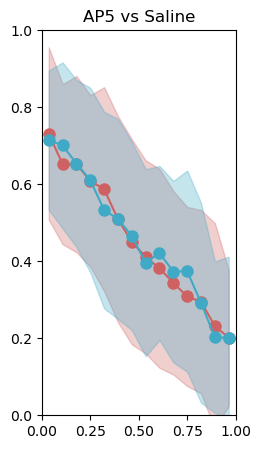

In [ ]:

fig, ax = plt.subplots(1, 1,figsize=(2.5, 5))
x = AP5_dict['neuron_rel_reverse_replay_positions']
x = [item for sublist in x for item in sublist]
y = AP5_dict['neuron_rel_awake_positions_reverse']
y = [item for sublist in y for item in sublist]
a,b = plot_sleep_awake_spike_position(ax,x,y, "#CE6262")
test_univariate_normality(x, y, alpha=0.05)
ax.set_xlim([0, 1])
ax.set_ylim([0, 1])

x1 = Saline_dict['neuron_rel_reverse_replay_positions']
x1 = [item for sublist in x1 for item in sublist]
y1 = Saline_dict['neuron_rel_awake_positions_reverse']
y1 = [item for sublist in y1 for item in sublist]
c,d= plot_sleep_awake_spike_position(ax,x1,y1, "#40A9C6")
test_univariate_normality(x1, y1, alpha=0.05)

ax.set_title('AP5 vs Saline')
print('data isnt normal so permanova for forward late vs early')

print_permanova_for_awake_sleep_neuron_positions(a,b,c,d)

# SaveFig('expert_learning_reverse_spike_positions.pdf',r'C:\Users\Emmett Thompson\Documents\plots\\')


forward 

C:\Users\Emmett Thompson\AppData\Local\Temp\ipykernel_67684\2910934412.py:202: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bin_means = df.groupby('bin')['x'].mean()
C:\Users\Emmett Thompson\AppData\Local\Temp\ipykernel_67684\2910934412.py:203: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bin_std = df.groupby('bin')['x'].std()
C:\Users\Emmett Thompson\AppData\Local\Temp\ipykernel_67684\2910934412.py:202: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future defa

--- x-axis ---
 Shapiro–Wilk:    W=0.961, p=0.000 -> non-normal
 D’Agostino K²: K²=202.186, p=0.000 -> non-normal

--- y-axis ---
 Shapiro–Wilk:    W=0.961, p=0.000 -> non-normal
 D’Agostino K²: K²=946.566, p=0.000 -> non-normal

--- x-axis ---
 Shapiro–Wilk:    W=0.975, p=0.000 -> non-normal
 D’Agostino K²: K²=153.820, p=0.000 -> non-normal

--- y-axis ---
 Shapiro–Wilk:    W=0.981, p=0.000 -> non-normal
 D’Agostino K²: K²=300.873, p=0.000 -> non-normal

data isnt normal so permanova for forward late vs early
***************************************************
method name               PERMANOVA
test statistic name        pseudo-F
sample size                      28
number of groups                  2
test statistic             0.027796
p-value                       0.877
number of permutations          999
Name: PERMANOVA results, dtype: object
PERMANOVA pseudo-F: 0.02780
PERMANOVA p-value: 0.87700
PERMANOVA effect size R²: 0.66487


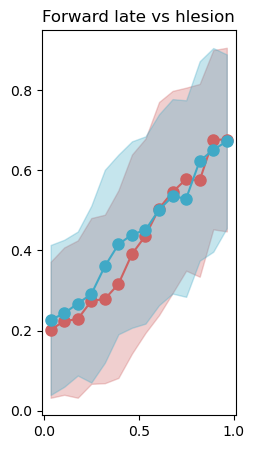

In [ ]:
fig, ax = plt.subplots(1, 1,figsize=(2.5, 5))
x = AP5_dict['neuron_rel_forward_replay_positions']
x = [item for sublist in x for item in sublist]
y = AP5_dict['neuron_rel_awake_positions_forwards']
y = [item for sublist in y for item in sublist]
a,b = plot_sleep_awake_spike_position(ax,x,y, '#CE6262')
test_univariate_normality(x, y, alpha=0.05)

x1 = Saline_dict['neuron_rel_forward_replay_positions']
x1 = [item for sublist in x1 for item in sublist]
y1 = Saline_dict['neuron_rel_awake_positions_forwards']
y1 = [item for sublist in y1 for item in sublist]
c,d= plot_sleep_awake_spike_position(ax,x1,y1, '#40A9C6')
test_univariate_normality(x1, y1, alpha=0.05)

ax.set_title('Forward late vs hlesion')
print('data isnt normal so permanova for forward late vs early')

print_permanova_for_awake_sleep_neuron_positions(a,b,c,d)

# SaveFig('expert_hlesion_forward_spike_positions.pdf',r'C:\Users\Emmett Thompson\Documents\plots\\')

# reactivations per minute 

ShapiroResult(statistic=np.float64(0.8955538345994339), pvalue=np.float64(0.30490352982384916))
ShapiroResult(statistic=np.float64(0.812793915619965), pvalue=np.float64(0.07636804354169993))
TtestResult(statistic=np.float64(-1.2515079253762442), pvalue=np.float64(0.23670957041985283), df=np.float64(11.0))
{'cohens_d': np.float64(0.6962747325629268)}
-------------------


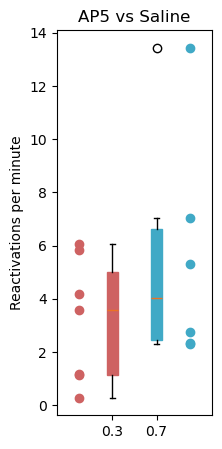

In [73]:
AP5_reactivations_per_min = AP5_dict['reactivations_per_min']
SALINE_reactivations_per_min = Saline_dict['reactivations_per_min']
# replace nan values with 0
AP5_reactivations_per_min = [0 if np.isnan(item) else item for item in AP5_reactivations_per_min]
SALINE_reactivations_per_min = [0 if np.isnan(item) else item for item in SALINE_reactivations_per_min]

########################################

fig, ax = plt.subplots(figsize=(2, 5))

ax.plot(np.zeros(len(AP5_reactivations_per_min)), AP5_reactivations_per_min, 'o', color = '#CE6262')
ax.boxplot(AP5_reactivations_per_min, positions=[0.3], widths=0.1, patch_artist=True, boxprops=dict(facecolor='#CE6262', color='#CE6262'), medianprops=dict(color='#EB7224'))

ax.plot(np.ones(len(SALINE_reactivations_per_min)), SALINE_reactivations_per_min, 'o', color = '#40A9C6')
ax.boxplot(SALINE_reactivations_per_min, positions=[0.7], widths=0.1, patch_artist=True, boxprops=dict(facecolor='#40A9C6', color='#40A9C6'), medianprops=dict(color='#EB7224'))

ax.set_ylabel('Reactivations per minute')

ax.set_title('AP5 vs Saline')
# SaveFig('expert_learning_rpm.pdf',r'C:\Users\Emmett Thompson\Documents\plots\\')

########################################
print(scipy.stats.shapiro(AP5_reactivations_per_min))
print(scipy.stats.shapiro(SALINE_reactivations_per_min))

# p is greater than 0.05 for both, so we fail to reject the null hypothesis that the data is normally distributed
print(scipy.stats.ttest_ind(AP5_reactivations_per_min,SALINE_reactivations_per_min))
print(effect_size(y=AP5_reactivations_per_min, x=SALINE_reactivations_per_min, test='ttest'))
print('-------------------')

# event lengths

ShapiroResult(statistic=np.float64(0.9373427833854837), pvalue=np.float64(0.614915138309025))
ShapiroResult(statistic=np.float64(0.9458411617874753), pvalue=np.float64(0.7065194174913694))
TtestResult(statistic=np.float64(-0.12108994795612883), pvalue=np.float64(0.9058034118357433), df=np.float64(11.0))
{'cohens_d': np.float64(0.06736822789505341)}


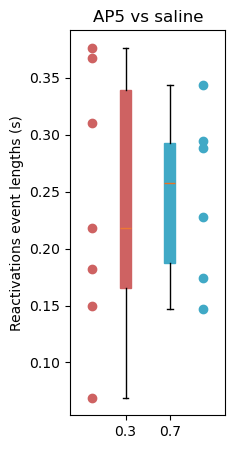

In [203]:

AP5_event_lens = AP5_dict['event_lens']
Saline_event_lens = Saline_dict['event_lens']

fig, ax = plt.subplots(figsize=(2, 5))
ax.plot(np.zeros(len(AP5_event_lens)), AP5_event_lens, 'o', color = '#CE6262')
ax.boxplot(AP5_event_lens, positions=[0.3], widths=0.1, patch_artist=True, boxprops=dict(facecolor='#CE6262', color='#CE6262'), medianprops=dict(color='#EE7832'))

ax.plot(np.ones(len(Saline_event_lens)), Saline_event_lens, 'o', color = '#40A9C6')
ax.boxplot([x for x in Saline_event_lens if not np.isnan(x)], positions=[0.7], widths=0.1, patch_artist=True, boxprops=dict(facecolor='#40A9C6', color='#40A9C6'), medianprops=dict(color='#EB7224'))

ax.set_ylabel('Reactivations event lengths (s)')
ax.set_title('AP5 vs saline')

#### STATS 
a = [x for x in AP5_event_lens if not np.isnan(x)]
b = [x for x in Saline_event_lens if not np.isnan(x)]

print(scipy.stats.shapiro(a))
print(scipy.stats.shapiro(b))
# p is greater than 0.05 for both, so we fail to reject the null hypothesis that the data is normally distributed
print(scipy.stats.ttest_ind(a,b))
print(effect_size(x=b, y=a, test='ttest'))


# warp 

---------------
forward vs reverse AP5
ShapiroResult(statistic=np.float64(0.7790661888131074), pvalue=np.float64(9.036919943587725e-08))
ShapiroResult(statistic=np.float64(0.7960682848628895), pvalue=np.float64(2.253240341095083e-07))
method name               PERMANOVA
test statistic name        pseudo-F
sample size                      14
number of groups                  2
test statistic             0.602599
p-value                    0.637236
number of permutations        10000
Name: PERMANOVA results, dtype: object
PERMANOVA effect size R²: 0.64141
---------------
forward vs reverse Saline
ShapiroResult(statistic=np.float64(0.8270249107251685), pvalue=np.float64(5.633109618821063e-06))
ShapiroResult(statistic=np.float64(0.8333743741678873), pvalue=np.float64(8.097990109548323e-06))
method name               PERMANOVA
test statistic name        pseudo-F
sample size                      12
number of groups                  2
test statistic             0.544449
p-value               

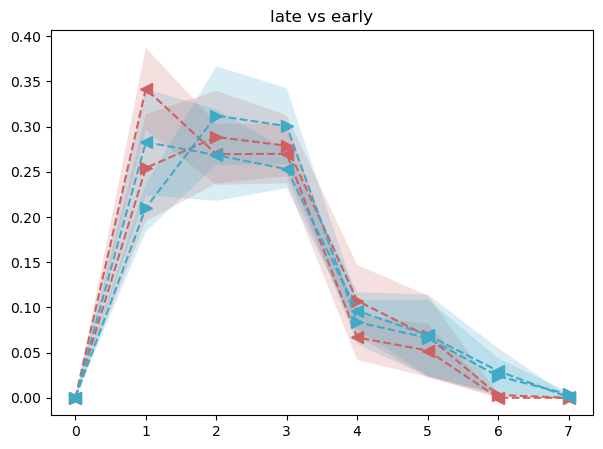

In [106]:
saline_regression = []
ap5_regression = []
for item in AP5_master['regression']:
    index = np.where(np.array(animals) == item['mouse'])[0][0]
    if group[index] == 'saline':
        saline_regression+=[item]
    else:
        ap5_regression+=[item]
    
bins_ = [0.1, 0.2, 1,2, 5, 10,20,40]

f_warp_factors, r_warp_factors, forward_total, reverse_total = extract_mean_warps(pd.DataFrame(ap5_regression), bins_)
color_ = '#CE6262'
fig,ax = plt.subplots(1, 1,figsize=(7, 5))
plot_warp_factors(ax, f_warp_factors, r_warp_factors, bins_, color_)

saline_f_warp_factors, saline_r_warp_factors,  saline_forward_total, saline_reverse_total= extract_mean_warps(pd.DataFrame(saline_regression), bins_)
color_ = '#40A9C6'
plot_warp_factors(ax, saline_f_warp_factors, saline_r_warp_factors, bins_, color_)
ax.set_title('late vs early')

# SaveFig('expert_learning_warpz.pdf',r'C:\Users\Emmett Thompson\Documents\plots\\')

print('---------------')
print('forward vs reverse AP5' )
print(scipy.stats.shapiro([item for sublist in f_warp_factors for item in sublist]))
print(scipy.stats.shapiro([item for sublist in r_warp_factors for item in sublist]))
permanova_forward_vs_reverse(f_warp_factors, r_warp_factors)
print('---------------')
print('forward vs reverse Saline' )
print(scipy.stats.shapiro([item for sublist in saline_f_warp_factors for item in sublist]))
print(scipy.stats.shapiro([item for sublist in saline_r_warp_factors for item in sublist]))
permanova_forward_vs_reverse(saline_f_warp_factors, saline_r_warp_factors)
print('---------------')
print('AP5 vs Saline' )
el_grouping = group_difference_permanova(f_warp_factors, r_warp_factors, saline_f_warp_factors, saline_r_warp_factors)



inset 

AP5 ------------------------
Test statistic: 1.2953381715894683
P-value: 0.24280647218034584
{'cohens_d': np.float64(0.48959180939354935)}
Saline ------------------------
Test statistic: 1.6395688187928723
P-value: 0.16201967216297278
{'cohens_d': np.float64(0.6693511673700453)}
AP5 vs Saline ------------------------
ShapiroResult(statistic=np.float64(0.8986568461025489), pvalue=np.float64(0.3229253886254482))
ShapiroResult(statistic=np.float64(0.7725845368855444), pvalue=np.float64(0.03284118980765976))
MannwhitneyuResult(statistic=np.float64(22.0), pvalue=np.float64(0.9452214452214451))
{'test': 'Mann-Whitney U', 'U': np.float64(22.0), 'p': np.float64(0.9452214452214451), 'rank_biserial_r': np.float64(0.04761904761904767)}
------------------------


C:\Users\Emmett Thompson\AppData\Local\Temp\ipykernel_67684\694385096.py:52: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return {"test": "Mann-Whitney U", "U": res['U-val'][0], "p": res['p-val'][0], "rank_biserial_r": res['RBC'][0]}


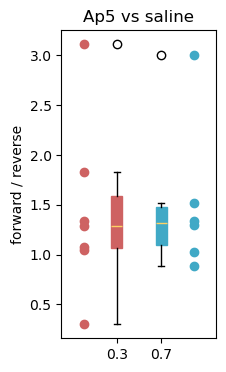

In [130]:
fig, ax = plt.subplots(figsize=(2, 4))
proportion_forward_v_reverse = np.array(forward_total)/np.array(reverse_total)
ax.plot(np.zeros(len(proportion_forward_v_reverse)),proportion_forward_v_reverse,'o', color = '#CE6262')
ax.boxplot([x for x in proportion_forward_v_reverse if not np.isnan(x)], positions=[0.3], widths=0.1, patch_artist=True, boxprops=dict(facecolor='#CE6262', color='#CE6262'), medianprops=dict(color='#FED163'))

saline_proportion_forward_v_reverse = np.array(saline_forward_total)/np.array(saline_reverse_total)
ax.plot(np.ones(len(saline_proportion_forward_v_reverse)),saline_proportion_forward_v_reverse,'o', color = '#40A9C6')
ax.boxplot([x for x in saline_proportion_forward_v_reverse if not np.isnan(x)], positions=[0.7], widths=0.1, patch_artist=True, boxprops=dict(facecolor='#40A9C6', color='#40A9C6'), medianprops=dict(color='#FED163'))
ax.set_title('Ap5 vs saline')
ax.set_ylabel('forward / reverse')

# SaveFig('expert_hlesion_warp_forward_vs_reverse.pdf',r'C:\Users\Emmett Thompson\Documents\plots\\')

#stats 

from scipy.stats import shapiro
from scipy.stats import ttest_1samp

print('AP5 ------------------------')
# Perform one-sample t-test
statistic, p_value = ttest_1samp(proportion_forward_v_reverse, 1.0)
# Print the test statistic and p-value
print("Test statistic:", statistic)
print("P-value:", p_value)
print(effect_size(x=proportion_forward_v_reverse,test='one_sample_ttest',popmean = 1))
print('Saline ------------------------')
# Perform one-sample t-test
statistic, p_value = ttest_1samp(saline_proportion_forward_v_reverse, 1.0)
# Print the test statistic and p-value
print("Test statistic:", statistic)
print("P-value:", p_value)
print(effect_size(x=saline_proportion_forward_v_reverse,test='one_sample_ttest',popmean = 1))
print('AP5 vs Saline ------------------------')
from scipy.stats import mannwhitneyu
print(scipy.stats.shapiro(proportion_forward_v_reverse))
print(scipy.stats.shapiro(saline_proportion_forward_v_reverse))
# Mann-Whitney U test (two-sided by default in SciPy ≥ 1.7.0)
print(mannwhitneyu(saline_proportion_forward_v_reverse, proportion_forward_v_reverse, alternative='two-sided'))
print(effect_size(x=saline_proportion_forward_v_reverse, y=proportion_forward_v_reverse, test='mannwhitney'))
print('------------------------')

post-hoc comparisions

In [136]:
# import numpy as np
# from itertools import combinations
# from skbio import DistanceMatrix
# from skbio.stats.distance import permanova
# from statsmodels.stats.multitest import multipletests
# from scipy.spatial.distance import pdist, squareform

# def pairwise_permanova_by_feature(data, group_labels, method='bonferroni', permutations=10000):
#     """
#     Perform pairwise PERMANOVA on each feature column, correcting p-values
#     across all feature×pairwise tests. For any pair where the feature is
#     constant, record statistic=0, p_value=1 instead of running PERMANOVA.
#     Returns a list of dicts:
#       feature, group1, group2, test_stat, p_value, permutations
#     """
#     unique_groups = np.unique(group_labels)
#     pairwise_combinations = list(combinations(unique_groups, 2))

#     results = []
#     all_pvals = []

#     n_features = data.shape[1]

#     for feat_idx in range(n_features):
#         feat = data[:, feat_idx]

#         for g1, g2 in pairwise_combinations:
#             mask = np.isin(group_labels, [g1, g2])
#             sub_feat = feat[mask]
#             sub_labels = group_labels[mask]

#             # If the feature is constant across these two groups, skip PERMANOVA:
#             if np.unique(sub_feat).size == 1:
#                 stat, pval = 0.0, 1.0
#                 r2 = 0
#             else:
#                 # Compute distances and run PERMANOVA
#                 dist_mat = squareform(pdist(sub_feat[:, None], metric='euclidean'))
#                 dist_mat = np.ascontiguousarray(dist_mat)
#                 ids = [str(i) for i in range(len(sub_labels))]
#                 dm = DistanceMatrix(dist_mat, ids)
#                 res = permanova(dm, sub_labels, permutations=permutations)
#                 stat, pval = res["test statistic"], res["p-value"]
                
#                     #Compute R² manually (effect size)
#                 # ss_total = sum of squared distances / n
#                 D = dm.data        # <-- this is the fix
#                 n = len(sub_labels)
#                 ss_total = np.sum(D**2) / n

#                 # ss_between: sum of squared group means
#                 group_labels = np.array(sub_labels)
#                 unique_groups = np.unique(group_labels)
#                 ss_between = 0
#                 for g in unique_groups:
#                     idx = np.where(group_labels == g)[0]
#                     Di = D[np.ix_(idx, idx)]
#                     ss_between += len(idx) * (Di.mean() ** 2)

#                 r2 = ss_between / ss_total
                
#             results.append({
#                 "feature": feat_idx,
#                 "group1": g1,
#                 "group2": g2,
#                 "test_stat": stat,
#                 "p_value": pval,
#                 "permutations": permutations,
#                 "R2": r2
#             })
#             all_pvals.append(pval)

#     # Multiple testing correction
#     corrected = multipletests(all_pvals, method=method)[1]
#     for i, cp in enumerate(corrected):
#         results[i]["p_value"] = cp

#     return results

# ####################################################################################

# # late vs early learning

# # Combine them correctly:
# combined_data = np.vstack([
#     np.asarray(f_warp_factors),
#     np.asarray(r_warp_factors),
#     np.asarray(learning_f_warp_factors),
#     np.asarray(learning_r_warp_factors)
# ])
# combined_labels = np.array(el_grouping)

# feature_results = pairwise_permanova_by_feature(
#     combined_data,
#     combined_labels,
#     method='bonferroni',
#     permutations=10000
# )

# print("Significant feature-wise pairwise PERMANOVA results (α=0.05):")
# for res in feature_results:
#     p = res["p_value"]
#     if p < 0.05:
#         stars = '***' if p < 0.001 else '**' if p < 0.01 else '*'
#         print(f"Feature {res['feature']}: {res['group1']} vs {res['group2']}")
#         print(f"  statistic = {res['test_stat']:.4f}, p (corr.) = {p:.4g} {stars}, R2: {res['R2']:.4f}")
#         print("---")
        
# print('_-_-_-__-_-_-__-_-_-__-_-_-__-_-_-__-_-_-__-_-_-_')  

# #### late vs hlesion

# # Combine them correctly:
# combined_data = np.vstack([
#     np.asarray(f_warp_factors),
#     np.asarray(r_warp_factors),
#     np.asarray(hlesion_f_warp_factors),
#     np.asarray(hlesion_r_warp_factors)
# ])
# combined_labels = np.array(eh_grouping)

# feature_results = pairwise_permanova_by_feature(
#     combined_data,
#     combined_labels,
#     method='bonferroni',
#     permutations=10000
# )

# print("Significant feature-wise pairwise PERMANOVA results (α=0.05):")
# for res in feature_results:
#     p = res["p_value"]
#     if p < 0.05:
#         stars = '***' if p < 0.001 else '**' if p < 0.01 else '*'
#         print(f"Feature {res['feature']}: {res['group1']} vs {res['group2']}")
#         print(f"  statistic = {res['test_stat']:.4f}, p (corr.) = {p:.4g} {stars}, R2: {res['R2']:.4f}")
#         print("---")
        

# reactivation rate vs time 

late vs early 

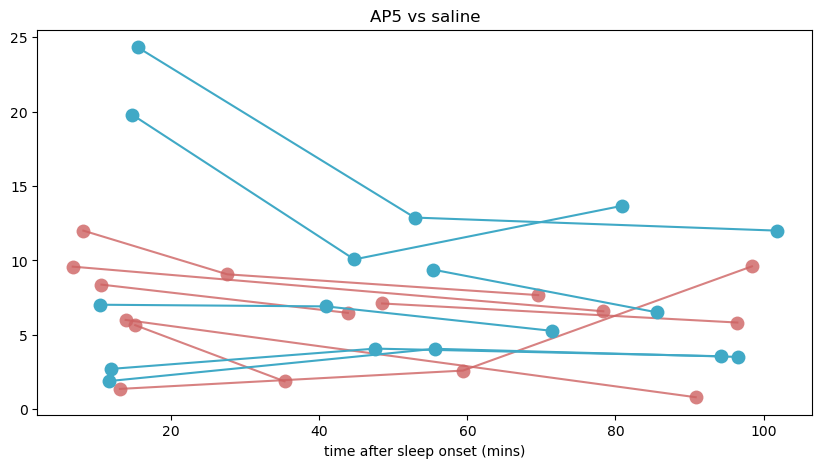

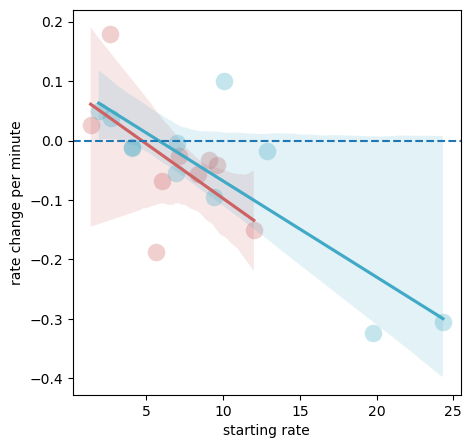

PLOT 2:
Group 1 (NREM):
model p value (f statistic) = 
0.09208158520249934
r2 = 
0.35215004169212927
Group 2 (REM):
model p value (f statistic) = 
0.0010634875015417928
r2 = 
0.7137277344405479


In [137]:
group1_data, group2_data = plot_decay(AP5_dict['binned_rate']  ,AP5_dict['bins_relative_so'],Saline_dict['binned_rate']  ,Saline_dict['bins_relative_so'], '#CE6262','#40A9C6','AP5 vs saline')

###################### STATS
df1 = pd.DataFrame(group1_data)
df2 = pd.DataFrame(group2_data)
# Fit linear regression for Group 1
model_group1 = sm.OLS.from_formula('y ~ x', data=df1).fit()
model_group2 = sm.OLS.from_formula('y ~ x', data=df2).fit()

print('PLOT 2:')
# Print the summary of each model
print("Group 1 (NREM):")
# print(model_group1.summary())
print('model p value (f statistic) = ')
print(model_group1.f_pvalue)
print('r2 = ')
print(model_group1.rsquared)

print("Group 2 (REM):")
# print(model_group1.summary())
print('model p value (f statistic) = ')
print(model_group2.f_pvalue)
print('r2 = ')
print(model_group2.rsquared)



In [142]:
####
import statsmodels.api as sm
print('AP5 -------------------------------------------')
# Add a constant term to the independent variable
# data = sm.add_constant(df1)
data = sm.add_constant(df1)
# Fit the regression model
model = sm.OLS(data['y'], data[['const', 'x']],missing='drop').fit()
# Print the summary statistics
print(model.summary())
r = np.sign(model.params['x']) * np.sqrt(model.rsquared)
print(r)
print(model.rsquared)
print(model.pvalues['x'])
print('Saline -------------------------------------------')
data = sm.add_constant(df2)
# Fit the regression model
model = sm.OLS(data['y'], data[['const', 'x']],missing='drop').fit()
# Print the summary statistics
print(model.summary())
r = np.sign(model.params['x']) * np.sqrt(model.rsquared)
print(r)
print(model.rsquared)
print(model.pvalues['x'])


print('AP5 vs Saline -------------------------------------------')
### between groups
import statsmodels.api as sm
from statsmodels.multivariate.manova import MANOVA
# Function to compute partial eta-squared from Wilks' Lambda
def compute_partial_eta_squared(manova_results):
    eta_dict = {}
    for effect, stats in manova_results.results.items():
        # Use the current effect, not always 'group'
        wilks_lambda = stats['stat'].loc["Wilks' lambda", 'Value']
        eta_p2 = 1 - wilks_lambda
        eta_dict[effect] = eta_p2
    return eta_dict

# Combine the data into one DataFrame
data = pd.concat([df1, df2], axis=0)
# Create a grouping variable
groups = np.array(['ap5'] * len(df1) + ['saline'] * len(df2))
# Perform MANOVA
manova = MANOVA.from_formula('x + y ~ groups', data=data)
# Print the MANOVA results
print(manova.mv_test())
# Compute partial eta-squared
eta_squared = compute_partial_eta_squared(manova.mv_test())
print("Partial eta-squared for each effect:", eta_squared)

AP5 -------------------------------------------
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.352
Model:                            OLS   Adj. R-squared:                  0.260
Method:                 Least Squares   F-statistic:                     3.805
Date:                Wed, 10 Sep 2025   Prob (F-statistic):             0.0921
Time:                        18:32:39   Log-Likelihood:                 10.018
No. Observations:                   9   AIC:                            -16.04
Df Residuals:                       7   BIC:                            -15.64
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
cons

c:\miniconda\envs\analysis_main\lib\site-packages\scipy\stats\_axis_nan_policy.py:430: UserWarning: `kurtosistest` p-value may be inaccurate with fewer than 20 observations; only n=9 observations were given.
  return hypotest_fun_in(*args, **kwds)
c:\miniconda\envs\analysis_main\lib\site-packages\scipy\stats\_axis_nan_policy.py:430: UserWarning: `kurtosistest` p-value may be inaccurate with fewer than 20 observations; only n=11 observations were given.
  return hypotest_fun_in(*args, **kwds)


# relative position

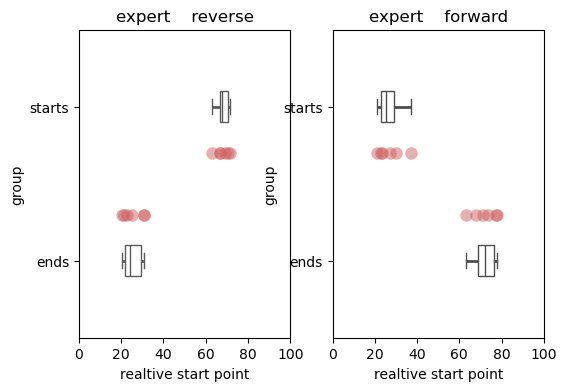

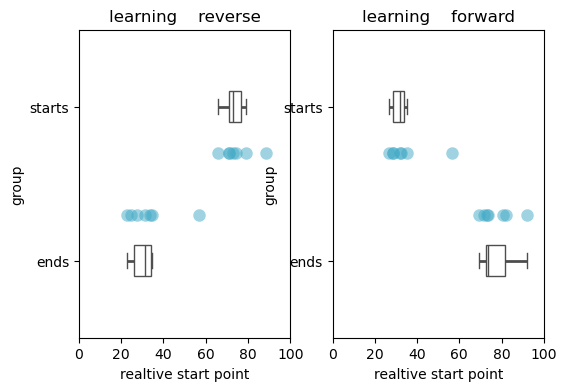

In [150]:
saline_start_end = []
ap5_start_end = []
for item in AP5_master['start_end']:
    index = np.where(np.array(animals) == item['mouse'])[0][0]
    if group[index] == 'saline':
        saline_start_end+=[item]
    else:
        ap5_start_end+=[item]
        
fig,[ax,ax2] = plt.subplots(1, 2,figsize=(6, 4)) 
all_chunk_reverse_start_mean, all_chunk_forward_start_mean, all_chunk_reverse_end_mean, all_chunk_forward_end_mean = extract_start_end_points(pd.DataFrame(saline_start_end))
plot_start_end_times(all_chunk_reverse_start_mean,all_chunk_forward_start_mean,all_chunk_reverse_end_mean,all_chunk_forward_end_mean,ax,ax2,'expert','#CE6262')
SaveFig('expert_start_ends.pdf',r'C:\Users\Emmett Thompson\Documents\plots\\')

fig,[ax,ax2] = plt.subplots(1, 2,figsize=(6, 4))
saline_all_chunk_reverse_start_mean, saline_all_chunk_forward_start_mean, saline_all_chunk_reverse_end_mean, saline_all_chunk_forward_end_mean = extract_start_end_points(pd.DataFrame(ap5_start_end))
plot_start_end_times(saline_all_chunk_reverse_start_mean,saline_all_chunk_forward_start_mean,saline_all_chunk_reverse_end_mean,saline_all_chunk_forward_end_mean,ax,ax2,'learning','#40A9C6')
SaveFig('learning_ends.pdf',r'C:\Users\Emmett Thompson\Documents\plots\\')



stats

In [ ]:

# Function to compute partial eta-squared from Wilks' Lambda
def compute_partial_eta_squared(manova_results):
    eta_dict = {}
    for effect, stats in manova_results.results.items():
        # Use the current effect, not always 'group'
        wilks_lambda = stats['stat'].loc["Wilks' lambda", 'Value']
        eta_p2 = 1 - wilks_lambda
        eta_dict[effect] = eta_p2
    return eta_dict


group1 = [x for x in all_chunk_forward_start_mean if not np.isnan(x)] 
group2 = [x for x in all_chunk_forward_end_mean if not np.isnan(x)] 
group3 = [x for x in all_chunk_reverse_start_mean if not np.isnan(x)] 
group4 = [x for x in all_chunk_reverse_end_mean if not np.isnan(x)] 
group5 = [x for x in saline_all_chunk_forward_start_mean if not np.isnan(x)] 
group6 = [x for x in saline_all_chunk_forward_end_mean if not np.isnan(x)] 
group7 = [x for x in saline_all_chunk_reverse_start_mean if not np.isnan(x)] 
group8 = [x for x in saline_all_chunk_reverse_end_mean if not np.isnan(x)] 


for group in [group1, group2, group3, group4, group5, group6, group7, group8]:
    print(scipy.stats.shapiro(group))

## all are normal so use MANOVA

df_ap5 = pd.DataFrame({
    'group':       ['late'] * len(all_chunk_forward_start_mean),
    'forward_start': all_chunk_forward_start_mean,
    'forward_end':   all_chunk_forward_end_mean,
    'reverse_start': all_chunk_reverse_start_mean,
    'reverse_end':   all_chunk_reverse_end_mean,
})


df_saline = pd.DataFrame({
    'group':       ['early'] * len(saline_all_chunk_forward_start_mean),
    'forward_start': saline_all_chunk_forward_start_mean,
    'forward_end':   saline_all_chunk_forward_end_mean,
    'reverse_start': saline_all_chunk_reverse_start_mean,
    'reverse_end':   saline_all_chunk_reverse_end_mean,
})

print('________________________________________________________________________')

# Concatenate them:
df = pd.concat([df_ap5, df_saline], ignore_index=True)
#  MANOVA
manova = MANOVA.from_formula('forward_start + forward_end +reverse_start +reverse_end  ~ group', data=df)
print(manova.mv_test())

# Compute partial eta-squared
eta_squared = compute_partial_eta_squared(manova.mv_test())
print("Partial eta-squared for each effect:", eta_squared)




ShapiroResult(statistic=np.float64(0.9106760206628688), pvalue=np.float64(0.44085870963092066))
ShapiroResult(statistic=np.float64(0.9370575600379474), pvalue=np.float64(0.6355916031463117))
ShapiroResult(statistic=np.float64(0.942392929375745), pvalue=np.float64(0.6785336527113555))
ShapiroResult(statistic=np.float64(0.8563711630343445), pvalue=np.float64(0.17705978890834595))
ShapiroResult(statistic=np.float64(0.7086781223743368), pvalue=np.float64(0.004607379720315552))
ShapiroResult(statistic=np.float64(0.8890857549603568), pvalue=np.float64(0.26992845617818295))
ShapiroResult(statistic=np.float64(0.9118337173288763), pvalue=np.float64(0.40871707724048884))
ShapiroResult(statistic=np.float64(0.8151555096076497), pvalue=np.float64(0.057657105081847335))
________________________________________________________________________
                  Multivariate linear model
                                                              
-----------------------------------------------------

# coactive frequency 

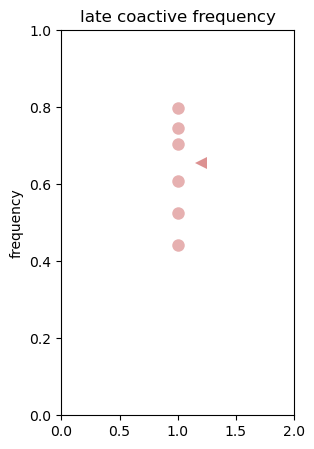

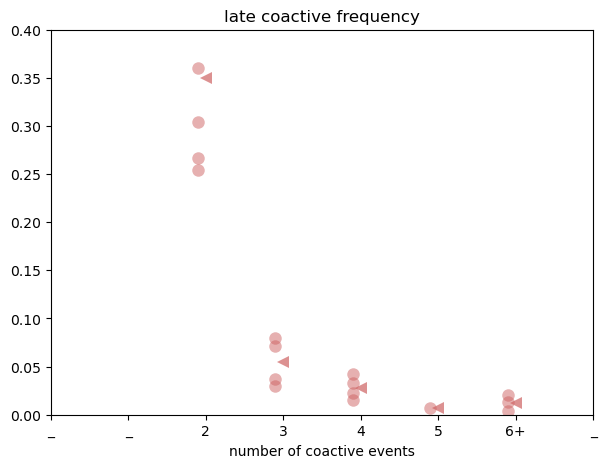

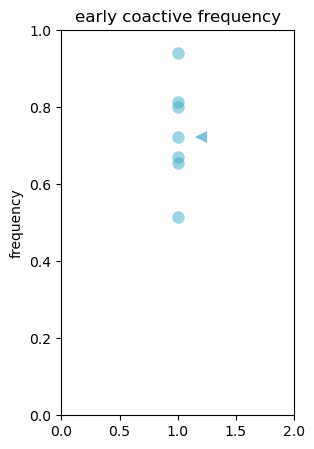

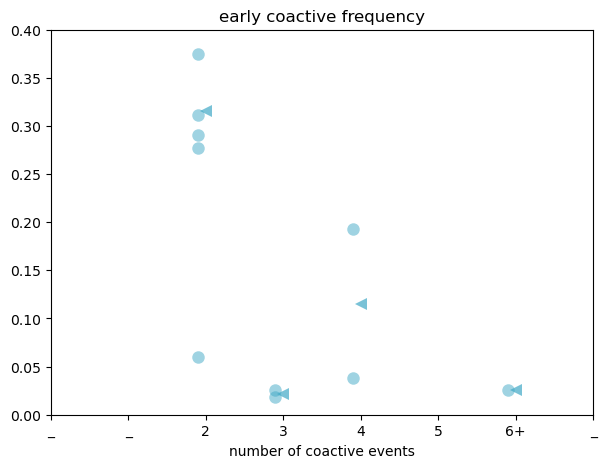

In [190]:



plot_coactive_single(AP5_master['AP5_coactive_freqs'], '#CE6262','late')
SaveFig('late_coactive_single.pdf',r'C:\Users\Emmett Thompson\Documents\plots\\')
expert_coactive_freqs_collapsed = plot_coactive_two_plus(AP5_master['AP5_coactive_freqs'], '#CE6262','late')
SaveFig('late_coactive.pdf',r'C:\Users\Emmett Thompson\Documents\plots\\')

plot_coactive_single(AP5_master['Saline_coactive_freqs'], '#40A9C6','early')
SaveFig('early_coactive_single.pdf',r'C:\Users\Emmett Thompson\Documents\plots\\')
_ = plot_coactive_two_plus(AP5_master['Saline_coactive_freqs'], '#40A9C6','early')
SaveFig('early_coactive.pdf',r'C:\Users\Emmett Thompson\Documents\plots\\')



stats for expert only plot 


In [63]:
import math 

def poisson_probability(rate, k):
    """Calculate Poisson probability of k events occurring given the rate."""
    return math.exp(-rate) * (rate ** k) / math.factorial(k)

def calculate_probabilities(rate_per_second, event_length_s):
    # Convert event length from milliseconds to seconds
    
    # Calculate the rate per 0.3 seconds considering event length
    rate_per_0p3_seconds = rate_per_second *(0.3 + event_length_s)
    
    results = {}
    total_probability = 0  # Variable to store the total probability
    
    for k in range(1, 7):  # Include probabilities for 1 to 6 events
        probability = poisson_probability(rate_per_0p3_seconds, k)
        results[k] = probability
        total_probability += probability  # Add probability to the total
    
    # Calculate percentages
    percentages = {k: (probability / total_probability) * 100 for k, probability in results.items()}
    
    return rate_per_0p3_seconds, results, percentages


## stats

# Input parameters
rate_per_second = np.mean(expert_master['reactivations_per_min'])/60
event_length_s = np.nanmean(expert_master['event_lens'])

# Calculate probabilities and percentages
rate_per_0p3_seconds, results, percentages = calculate_probabilities(rate_per_second, event_length_s)

# Display results
print(f"Using a rate of {rate_per_0p3_seconds:.6f} events per 0.3 seconds.")
print("Probability of events co-occurring within 0.3 + mean event length:")
for k, probability in results.items():
    print(f"{k} events co-occurring: Probability {probability:.6f}, Percentage {percentages[k]:.2f}%")
    
    
# test each one for significance from expected

from scipy.stats import shapiro
from scipy.stats import ttest_1samp

expect_percentages= [0.95,0.04,0.011,0,0,0]
for i,key in enumerate(expert_coactive_freqs_collapsed):
    data = np.array(expert_coactive_freqs_collapsed[key])
    
    print('-------')
    print(key)

    ### all normal so use t test 
    
    # Hypothesized value (e.g., population mean or constant)
    hypothesized_value = expect_percentages[i]

    # Perform one-sample t-test
    statistic, p_value = ttest_1samp(data, hypothesized_value)

    # Print the test statistic and p-value
    print("Test statistic:", statistic)
    print("P-value:", p_value)
    
    print('cohens d')
    print(effect_size(x=data, test='one_sample_ttest',popmean=hypothesized_value))


Using a rate of 0.083287 events per 0.3 seconds.
Probability of events co-occurring within 0.3 + mean event length:
1 events co-occurring: Probability 0.076631, Percentage 95.89%
2 events co-occurring: Probability 0.003191, Percentage 3.99%
3 events co-occurring: Probability 0.000089, Percentage 0.11%
4 events co-occurring: Probability 0.000002, Percentage 0.00%
5 events co-occurring: Probability 0.000000, Percentage 0.00%
6 events co-occurring: Probability 0.000000, Percentage 0.00%
-------
1
Test statistic: -10.811060125223838
P-value: 8.392844914474116e-10
cohens d
{'cohens_d': np.float64(-2.35916673174081)}
-------
2
Test statistic: 13.911314911292985
P-value: 9.575349766013606e-12
cohens d
{'cohens_d': np.float64(3.0356977903508566)}
-------
3
Test statistic: 2.181275848746699
P-value: 0.04442858080287187
cohens d
{'cohens_d': np.float64(0.5290371013524383)}
-------
4
Test statistic: 5.963697087429965
P-value: 3.464717069681714e-05
cohens d
{'cohens_d': np.float64(1.53981996676279

stats


In [88]:
from skbio.stats.distance import permanova, DistanceMatrix
from skbio import DistanceMatrix
from scipy.spatial.distance import pdist, squareform
from skbio.stats.distance import DistanceMatrix
from skbio.stats.distance import permanova

def permanova_coactive_freqs(dat1, dat2):
    df = pd.DataFrame()
    df['groups'] = ['control']*len(dat1[1])  + ['lesion']*len(dat2[1])

    for key in dat1:
        current_var = dat1[key]
        while len(current_var)<len(dat1[1]):
            current_var +=[0]
        
        try:
            dat2[key]
            current_var_l = dat2[key]
            while len(current_var_l)<len(dat2[1]):
                current_var_l +=[0]
        except:
            current_var_l = [0]*len(dat2[1])
            
            
        df[str(key)] = current_var + current_var_l
        

    # Calculate the Euclidean distance matrix
    values = df[['1', '2', '3', '4', '5', '6']].values
    grouping = df['groups'].values

    pairwise_distances = pdist(values, metric='euclidean')
    distance_matrix = squareform(pairwise_distances)
    dm = DistanceMatrix(distance_matrix)

    # Perform PERMANOVA
    results = permanova(dm, grouping, permutations=10000)
    print(results)

    #Compute R² manually (effect size)
    # ss_total = sum of squared distances / n
    D = dm.data        # <-- this is the fix
    n = len(grouping)
    ss_total = np.sum(D**2) / n

    # ss_between: sum of squared group means
    group_labels = np.array(grouping)
    unique_groups = np.unique(group_labels)
    ss_between = 0
    for g in unique_groups:
        idx = np.where(group_labels == g)[0]
        Di = D[np.ix_(idx, idx)]
        ss_between += len(idx) * (Di.mean() ** 2)

    r2 = ss_between / ss_total

    print('***************************************************')
    print(f"PERMANOVA effect size R²: {r2:.5f}")

permanova_coactive_freqs(expert_master['coactive_freqs'], learning_master['coactive_freqs'])
print('__________________')
permanova_coactive_freqs(expert_master['coactive_freqs'], hlesion_master['coactive_freqs'])

method name               PERMANOVA
test statistic name        pseudo-F
sample size                      35
number of groups                  2
test statistic             2.318469
p-value                    0.081992
number of permutations        10000
Name: PERMANOVA results, dtype: object
***************************************************
PERMANOVA effect size R²: 0.62969
__________________
method name               PERMANOVA
test statistic name        pseudo-F
sample size                      30
number of groups                  2
test statistic             1.929107
p-value                    0.136486
number of permutations        10000
Name: PERMANOVA results, dtype: object
***************************************************
PERMANOVA effect size R²: 0.62409


# ordered v disordered 

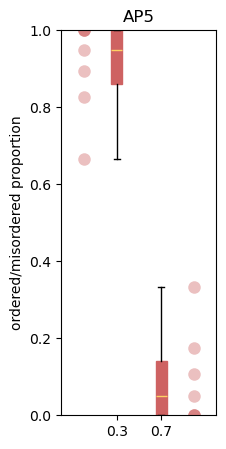

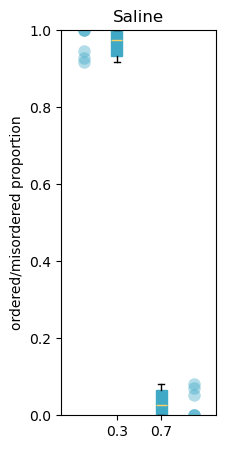

In [204]:

def plot_ordered_misrodered(nrem_ordered_misordered,var_string,var_string2, color_):

    ordered = [item[0] for item in nrem_ordered_misordered]
    misordered = [item[1] for item in nrem_ordered_misordered]

    fig, ax = plt.subplots(figsize=(2, 5))

    ax.plot(np.zeros(len(ordered)), ordered, 'o', color = color_,alpha = 0.4, markeredgewidth = 0, markersize = 9)
    ax.boxplot([x for x in ordered if not np.isnan(x)], positions=[0.3], widths=0.1, patch_artist=True, boxprops=dict(facecolor=color_, color=color_), medianprops=dict(color='#FED163'))
    ax.plot(np.ones(len(misordered)), misordered, 'o', color = color_,alpha = 0.4, markeredgewidth = 0, markersize = 9)
    ax.boxplot([x for x in misordered if not np.isnan(x)], positions=[0.7], widths=0.1, patch_artist=True, boxprops=dict(facecolor=color_, color=color_), medianprops=dict(color='#FED163'))

    ax.set_ylabel(var_string2)
    
    ax.set_title(var_string)
    ax.set_ylim(0, 1)
    
# '#69BD45'
# '#32495C'



plot_ordered_misrodered(AP5_dict['ordered_misordered'],'AP5','ordered/misordered proportion', '#CE6262')
# SaveFig('expert_ordered_misordered.pdf',r'C:\Users\Emmett Thompson\Documents\plots\\')
plot_ordered_misrodered(Saline_dict['ordered_misordered'],'Saline','ordered/misordered proportion','#40A9C6')
# SaveFig('learning_ordered_misordered.pdf',r'C:\Users\Emmett Thompson\Documents\plots\\')



stats - ordered vs disovered

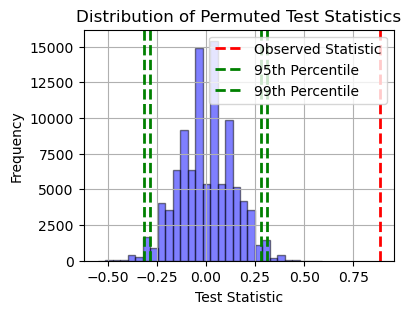

- p-value: 0.0
- 99th percentile of permuted statistics: 0.31221594183837026
- Observed Test Statistic: 0.8835621876858357
cohens d = 14.344563129258281
------------------


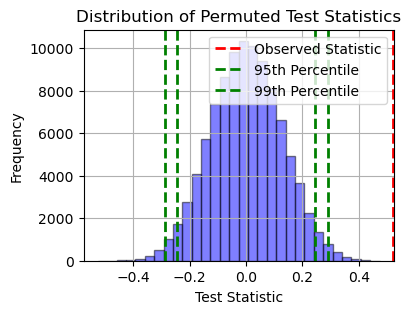

- p-value: 0.0
- 99th percentile of permuted statistics: 0.28962773329414193
- Observed Test Statistic: 0.5198639917680165
cohens d = 2.8145362289994527
------------------


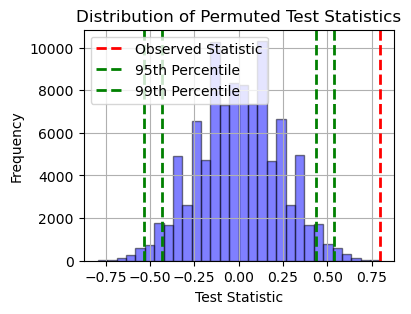

- p-value: 0.00025
- 99th percentile of permuted statistics: 0.5362844338176406
- Observed Test Statistic: 0.7937674270149195
cohens d = 5.2723039801951055


In [172]:

def cohens_d(x, y):
    """
    Compute Cohen's d for two independent samples.
    """
    x = np.array(x)
    y = np.array(y)
    nx = len(x)
    ny = len(y)
    # Pooled standard deviation
    pooled_std = np.sqrt(((nx-1)*x.std(ddof=1)**2 + (ny-1)*y.std(ddof=1)**2) / (nx + ny - 2))
    d = (x.mean() - y.mean()) / pooled_std
    return d

def permutation_test(list1, list2):
    # Define your test statistic function
    def test_statistic(list1, list2):
        return np.mean(list1) - np.mean(list2)

    # Compute the observed test statistic
    observed_statistic = test_statistic(list1, list2)

    # Combine the two lists
    combined_data = list1 + list2

    # Number of permutations
    num_permutations = 100000

    # Initialize an array to store the permuted test statistics
    permuted_statistics = np.zeros(num_permutations)

    # Permutation test
    for i in range(num_permutations):
        # Shuffle the combined data
        np.random.shuffle(combined_data)
        
        # Split the shuffled data back into two lists
        permuted_list1 = combined_data[:len(list1)]
        permuted_list2 = combined_data[len(list1):]
        
        # Compute the test statistic for the permuted data
        permuted_statistics[i] = test_statistic(permuted_list1, permuted_list2)

    # Calculate the p-value
    p_value = np.mean(permuted_statistics >= observed_statistic)


    plt.figure(figsize=(4, 3))
    plt.hist(permuted_statistics, bins=30, alpha=0.5, color='blue', edgecolor='black')
    plt.axvline(observed_statistic, color='red', linestyle='dashed', linewidth=2, label='Observed Statistic')
    plt.xlabel('Test Statistic')
    plt.ylabel('Frequency')
    plt.title('Distribution of Permuted Test Statistics')
    plt.axvline(np.percentile(permuted_statistics, 97.5), color='green', linestyle='dashed', linewidth=2, label='95th Percentile')
    plt.axvline(np.percentile(permuted_statistics, 2.5), color='green', linestyle='dashed', linewidth=2)
    plt.axvline(np.percentile(permuted_statistics, 99), color='green', linestyle='dashed', linewidth=2, label='99th Percentile')
    plt.axvline(np.percentile(permuted_statistics, 1), color='green', linestyle='dashed', linewidth=2)
    plt.xlabel('Test Statistic')
    plt.legend()
    plt.grid(True)
    plt.show()
    

    print("- p-value:", p_value)
    print('- 99th percentile of permuted statistics:',np.percentile(permuted_statistics, 99))
    print("- Observed Test Statistic:", observed_statistic)



    
    
list1 = [float(item[0]) for item in expert_master['ordered_misordered']] 
list2 = [float(item[1]) for item in expert_master['ordered_misordered']] 
list1= [x for x in list1 if not np.isnan(x)] 
list2= [x for x in list2 if not np.isnan(x)] 
permutation_test(list1, list2)
print(f'cohens d = {cohens_d(list1, list2)}')
# # Compute Cohen's d
# res = pg.compute_effsize(list1, list2, eftype='cohen')
# print(f"Cohen's d = {res:.3f}")
# delta = pg.compute_effsize(list1, list2, eftype='cliff')
# print("Cliff's delta =", delta)

print('------------------')
list1 = [float(item[0]) for item in learning_master['ordered_misordered']] 
list2 = [float(item[1]) for item in learning_master['ordered_misordered']] 
list1= [x for x in list1 if not np.isnan(x)] 
list2= [x for x in list2 if not np.isnan(x)] 
permutation_test(list1, list2)
print(f'cohens d = {cohens_d(list1, list2)}')

print('------------------')
list1 = [float(item[0]) for item in hlesion_master['ordered_misordered']] 
list2 = [float(item[1]) for item in hlesion_master['ordered_misordered']] 
list1= [x for x in list1 if not np.isnan(x)] 
list2= [x for x in list2 if not np.isnan(x)] 
permutation_test(list1, list2)
print(f'cohens d = {cohens_d(list1, list2)}')

stats - between groups 

In [173]:
list1 = [float(item[0]) for item in expert_master['ordered_misordered']] 
list2 = [float(item[1]) for item in expert_master['ordered_misordered']] 
list1= [x for x in list1 if not np.isnan(x)] 
list2= [x for x in list2 if not np.isnan(x)] 
print(scipy.stats.shapiro(list1))
print(scipy.stats.shapiro(list2))

list1 = [float(item[0]) for item in learning_master['ordered_misordered']] 
list2 = [float(item[1]) for item in learning_master['ordered_misordered']] 
list1= [x for x in list1 if not np.isnan(x)] 
list2= [x for x in list2 if not np.isnan(x)] 
print(scipy.stats.shapiro(list1))
print(scipy.stats.shapiro(list2))

list1 = [float(item[0]) for item in hlesion_master['ordered_misordered']] 
list2 = [float(item[1]) for item in hlesion_master['ordered_misordered']] 
list1= [x for x in list1 if not np.isnan(x)] 
list2= [x for x in list2 if not np.isnan(x)] 
print(scipy.stats.shapiro(list1))
print(scipy.stats.shapiro(list2))

# use non-parametric permanova since not all are normal


ShapiroResult(statistic=np.float64(0.8501660492808003), pvalue=np.float64(0.004275777782515545))
ShapiroResult(statistic=np.float64(0.850166049280801), pvalue=np.float64(0.004275777782515661))
ShapiroResult(statistic=np.float64(0.9402014901875838), pvalue=np.float64(0.4595166571342518))
ShapiroResult(statistic=np.float64(0.9402014901875838), pvalue=np.float64(0.4595166571342518))
ShapiroResult(statistic=np.float64(0.7568195318727229), pvalue=np.float64(0.014941651702752096))
ShapiroResult(statistic=np.float64(0.7568195318727227), pvalue=np.float64(0.01494165170275201))


In [174]:
import numpy as np
import pandas as pd
from scipy.spatial.distance import pdist, squareform
from skbio.stats.distance import DistanceMatrix, permanova

def permanova_ordered_misordered(nrem, rem):

    df = pd.DataFrame(nrem + rem, columns=['ordered','misordered'])
    df['group'] = ['nrem']*len(nrem) + ['rem']*len(rem)

    # drop any NaNs
    df = df.dropna()

    # compute distance matrix
    dm = DistanceMatrix(
        squareform(pdist(df[['ordered','misordered']].values, 'euclidean'))
    )

    # run PERMANOVA
    res = permanova(dm, grouping=df['group'].tolist(), permutations=999)
    print(res)
    
    #Compute R² manually (effect size)
    # ss_total = sum of squared distances / n
    D = dm.data        # <-- this is the fix
    n = len(df['group'].tolist())
    ss_total = np.sum(D**2) / n

    # ss_between: sum of squared group means
    group_labels = np.array(df['group'].tolist())
    unique_groups = np.unique(group_labels)
    ss_between = 0
    for g in unique_groups:
        idx = np.where(group_labels == g)[0]
        Di = D[np.ix_(idx, idx)]
        ss_between += len(idx) * (Di.mean() ** 2)

    r2 = ss_between / ss_total
    print(f"PERMANOVA effect size R²: {r2:.5f}")
    

    

permanova_ordered_misordered(expert_master['ordered_misordered'], learning_master['ordered_misordered'])
print('---------------------------------------------------')
permanova_ordered_misordered(expert_master['ordered_misordered'], hlesion_master['ordered_misordered'])


method name               PERMANOVA
test statistic name        pseudo-F
sample size                      34
number of groups                  2
test statistic            17.509105
p-value                       0.001
number of permutations          999
Name: PERMANOVA results, dtype: object
PERMANOVA effect size R²: 0.40118
---------------------------------------------------
method name               PERMANOVA
test statistic name        pseudo-F
sample size                      28
number of groups                  2
test statistic             1.298629
p-value                       0.249
number of permutations          999
Name: PERMANOVA results, dtype: object
PERMANOVA effect size R²: 0.49564


# task related 

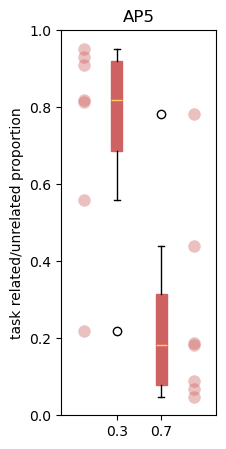

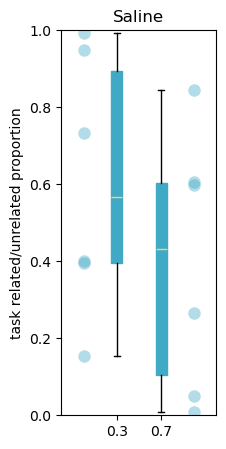

In [194]:

plot_ordered_misrodered(AP5_dict['task_nontask'],'AP5','task related/unrelated proportion','#CE6262')
# SaveFig('expert_task_related.pdf',r'C:\Users\Emmett Thompson\Documents\plots\\')
plot_ordered_misrodered(Saline_dict['task_nontask'],'Saline','task related/unrelated proportion','#40A9C6')
# SaveFig('learning_task_related.pdf',r'C:\Users\Emmett Thompson\Documents\plots\\')


stats

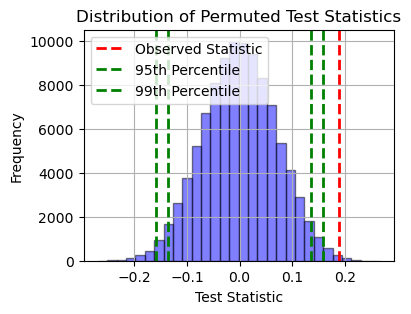

- p-value: 0.00259
- 99th percentile of permuted statistics: 0.15891417839632255
- Observed Test Statistic: 0.1878173237864238
cohens d = 0.9066336142773078
------------------


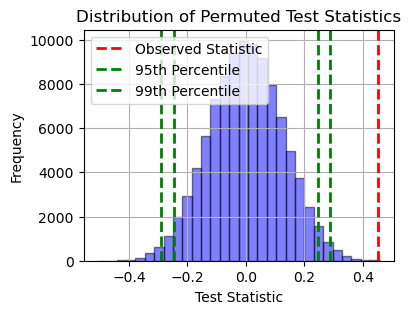

- p-value: 1e-05
- 99th percentile of permuted statistics: 0.2886909097248733
- Observed Test Statistic: 0.4530091076439036
cohens d = 1.8292287120721011
------------------


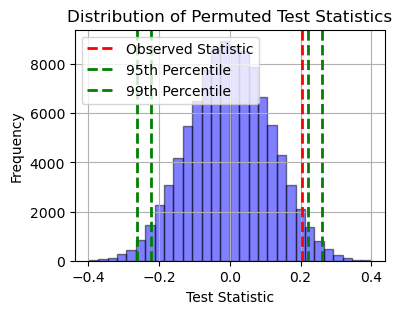

- p-value: 0.03749
- 99th percentile of permuted statistics: 0.2601918483882814
- Observed Test Statistic: 0.20309083127569588
cohens d = 0.8999170205608042


In [90]:

list1 = [float(item[0]) for item in expert_master['task_nontask']] 
list2 = [float(item[1]) for item in expert_master['task_nontask']] 
list1= [x for x in list1 if not np.isnan(x)] 
list2= [x for x in list2 if not np.isnan(x)] 
permutation_test(list1, list2)
print(f'cohens d = {cohens_d(list1, list2)}')


print('------------------')
list1 = [float(item[0]) for item in learning_master['task_nontask']] 
list2 = [float(item[1]) for item in learning_master['task_nontask']] 
list1= [x for x in list1 if not np.isnan(x)] 
list2= [x for x in list2 if not np.isnan(x)] 
permutation_test(list1, list2)
print(f'cohens d = {cohens_d(list1, list2)}')

print('------------------')
list1 = [float(item[0]) for item in hlesion_master['task_nontask']] 
list2 = [float(item[1]) for item in hlesion_master['task_nontask']] 
list1= [x for x in list1 if not np.isnan(x)] 
list2= [x for x in list2 if not np.isnan(x)] 
permutation_test(list1, list2)
print(f'cohens d = {cohens_d(list1, list2)}')

stats between groups

In [103]:
list1 = [float(item[0]) for item in expert_master['task_nontask']] 
list2 = [float(item[1]) for item in expert_master['task_nontask']] 
list1= [x for x in list1 if not np.isnan(x)] 
list2= [x for x in list2 if not np.isnan(x)] 
print(scipy.stats.shapiro(list1))
print(scipy.stats.shapiro(list2))

list1 = [float(item[0]) for item in learning_master['task_nontask']] 
list2 = [float(item[1]) for item in learning_master['task_nontask']] 
list1= [x for x in list1 if not np.isnan(x)] 
list2= [x for x in list2 if not np.isnan(x)] 
print(scipy.stats.shapiro(list1))
print(scipy.stats.shapiro(list2))

list1 = [float(item[0]) for item in hlesion_master['task_nontask']] 
list2 = [float(item[1]) for item in hlesion_master['task_nontask']] 
list1= [x for x in list1 if not np.isnan(x)] 
list2= [x for x in list2 if not np.isnan(x)] 
print(scipy.stats.shapiro(list1))
print(scipy.stats.shapiro(list2))

ShapiroResult(statistic=np.float64(0.8953354267474212), pvalue=np.float64(0.028443815924771326))
ShapiroResult(statistic=np.float64(0.8953354267474206), pvalue=np.float64(0.028443815924770622))
ShapiroResult(statistic=np.float64(0.8410312655652665), pvalue=np.float64(0.016817171171969254))
ShapiroResult(statistic=np.float64(0.8410312655652663), pvalue=np.float64(0.016817171171969122))
ShapiroResult(statistic=np.float64(0.9575214030355926), pvalue=np.float64(0.7720539483267331))
ShapiroResult(statistic=np.float64(0.9575214030355926), pvalue=np.float64(0.7720539483267331))


In [126]:
#permanova for late vs early
permanova_ordered_misordered(expert_master['task_nontask'], learning_master['task_nontask'])
print('---------------------------------------------------')

#manova for late vs hlesion 

from statsmodels.multivariate.manova import MANOVA

# Your data
data = {
    'group': ['control']*len(conactinate_nth_items(expert_master['task_nontask'])[0]) +
             ['lesion']*len(conactinate_nth_items(hlesion_master['task_nontask'])[0]),
    'TASK': conactinate_nth_items(expert_master['task_nontask'])[0] +
            conactinate_nth_items(hlesion_master['task_nontask'])[0],
    'NONTASK': conactinate_nth_items(expert_master['task_nontask'])[1] +
               conactinate_nth_items(hlesion_master['task_nontask'])[1],
}
df = pd.DataFrame(data)

# Perform MANOVA
manova = MANOVA.from_formula('TASK + NONTASK ~ group', data=df)
res = manova.mv_test()
print(res)

# Function to compute partial eta-squared from Wilks' Lambda
def compute_partial_eta_squared(manova_results):
    eta_dict = {}
    for effect, stats in manova_results.results.items():
        # Use the current effect, not always 'group'
        wilks_lambda = stats['stat'].loc["Wilks' lambda", 'Value']
        eta_p2 = 1 - wilks_lambda
        eta_dict[effect] = eta_p2
    return eta_dict




# Compute partial eta-squared
eta_squared = compute_partial_eta_squared(res)
print("Partial eta-squared for each effect:", eta_squared)



method name               PERMANOVA
test statistic name        pseudo-F
sample size                      35
number of groups                  2
test statistic             2.943737
p-value                       0.113
number of permutations          999
Name: PERMANOVA results, dtype: object
PERMANOVA effect size R²: 0.56526
---------------------------------------------------
                                 Multivariate linear model
                                                                                            
--------------------------------------------------------------------------------------------
       Intercept                Value          Num DF  Den DF         F Value         Pr > F
--------------------------------------------------------------------------------------------
          Wilks' lambda                -0.0000 2.0000 27.0000 -60798594969501712.0000 1.0000
         Pillai's trace                 1.0000 2.0000 27.0000 -60798594969501712.0000 1.0000
 Hotel

In [107]:
eta_squared

{'Intercept': np.float64(-26.0), 'group': np.float64(-26.0)}

# neuron involvement rate

In [205]:
def return_binned_neuron_awake_sleep_rel(awake_dat,sleep_dat):
    awake_sleep_relationship = {}
    for index_, item, in enumerate(awake_dat):
        for index, awake_mouse_data in enumerate(item):

            awake = awake_mouse_data
            sleep = np.array(sleep_dat[index_][index])

            min_neurons_filter = 0
            bins = [0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]    

            for bin_ in bins:
                mask = np.round(awake,1) == bin_
                if len(sleep[mask]) > min_neurons_filter:
                    if bin_ in awake_sleep_relationship:
                        awake_sleep_relationship[bin_] += [np.mean(sleep[mask])]
                    else:
                        awake_sleep_relationship[bin_] = [np.mean(sleep[mask])]

    return awake_sleep_relationship




def plot_awake_sleep_relationship(awake_sleep_relationship,color_,ax):




    keys = []
    e_means = []
    sem = []
    for key in awake_sleep_relationship:
        if len(awake_sleep_relationship[key]) > 0:
            keys += [key]
    #         ax.plot([key]* len(e_awake_sleep_relationship[key]),e_awake_sleep_relationship[key],'o', color = 'red')

            a_s_relationship = [x for x in awake_sleep_relationship[key] if not np.isnan(x)]

            e_means += [np.mean(a_s_relationship)]
            sem += [scipy.stats.tstd(a_s_relationship)]
    ax.plot(sorted(keys),np.array(e_means)[np.argsort(keys)],'o--', c = color_, alpha = 1, markeredgewidth = 0, markersize = 10)

    upper = np.array(e_means)[np.argsort(keys)] + sem
    lower = np.array(e_means)[np.argsort(keys)] - sem
    ax.fill_between(sorted(keys),(lower),(upper),
        alpha=0.2, edgecolor='None', facecolor=color_,
        linewidth=1, linestyle='dashdot', antialiased=True)

    x = np.linspace(0, 1, 10)  # Example x values
    y = x  # Since x equals y, y values are the same as x values
    plt.plot(x,y,'--')


    ax.set_ylim(0,0.8)


    ax.set_ylabel('replay proportion involvement')
    ax.set_xlabel('awake proportion involvement')

    #################################################

    from scipy.optimize import curve_fit
    from scipy.stats import t

    # Extract the bins and corresponding values
    bins = list(awake_sleep_relationship.keys())
    
    bin_centers = np.array(bins)[np.argsort(bins)]
    values = np.array([np.nanmean(awake_sleep_relationship[bin]) for bin in bins])[np.argsort(bins)]

    # Define the exponential function
    def exponential_model(x, a, b):
        return a * np.exp(b * x)

    # Fit the model to the data
    popt, pcov = curve_fit(exponential_model, bin_centers, values)

    # Extract the fitting parameters
    a, b = popt

    # Calculate the fitted values
    fitted_values = exponential_model(bin_centers, *popt)

    # Calculate R-squared
    residuals = values - fitted_values
    ss_res = np.sum(residuals**2)
    ss_tot = np.sum((values - np.mean(values))**2)
    r_squared = 1 - (ss_res / ss_tot)

    # Degrees of freedom
    dof = max(0, len(bin_centers) - len(popt))

    # Calculate standard errors of the parameters
    perr = np.sqrt(np.diag(pcov))

    # Calculate t-values for the parameters
    t_values = popt / perr

    # Calculate p-values for the parameters
    p_values = [2 * (1 - t.cdf(np.abs(t_val), dof)) for t_val in t_values]

    print(f'Fitted parameters: a = {a}, b = {b}')
    print(f'R-squared: {r_squared}')
    print(f'p-values: {p_values}')


    # Plot the original data and the fitted curve
    # plt.scatter(bin_centers, values, label='Data')
    # plt.plot(bin_centers, fitted_values, label='Fitted curve', color='red', alpha = 0.4)
    plt.xlabel('Bin Center')
    plt.ylabel('Value')




In [207]:
list(AP5_master)

['animals',
 'reactivations_per_min',
 'event_lens',
 'regression',
 'binned_rate',
 'bins_relative_so',
 'start_end',
 'ordered_misordered',
 'AP5_coactive_freqs',
 'Saline_coactive_freqs',
 'task_nontask',
 'Saline_awake_seqbyseq_neuron_involvements',
 'Saline_sleep_seqbyseq_neuron_involvements',
 'AP5_awake_seqbyseq_neuron_involvements',
 'AP5_sleep_seqbyseq_neuron_involvements',
 'neuron_rel_awake_positions_reverse',
 'neuron_rel_reverse_replay_positions',
 'neuron_rel_awake_positions_forwards',
 'neuron_rel_forward_replay_positions']

Fitted parameters: a = 0.03977890233710487, b = 3.051633541980589
R-squared: 0.9791753566011875
p-values: [np.float64(0.0003475351283395156), np.float64(5.114969048314322e-07)]
Fitted parameters: a = 0.03076737072814054, b = 3.3037839815794663
R-squared: 0.9825189177990326
p-values: [np.float64(0.000501013994355759), np.float64(3.890759081581763e-07)]


Text(0.5, 1.0, 'AP5 vs Saline')

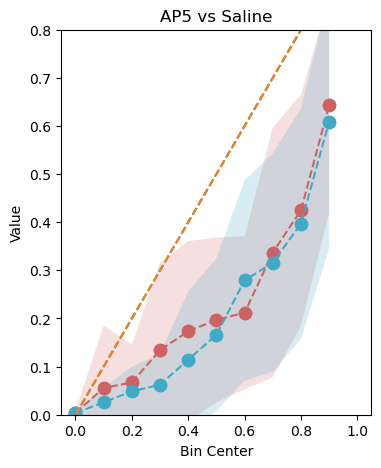

In [209]:


fig, ax = plt.subplots(1, 1,figsize=(4, 5))
late_awake_sleep_relationship = return_binned_neuron_awake_sleep_rel(AP5_master['AP5_awake_seqbyseq_neuron_involvements'],AP5_master['AP5_sleep_seqbyseq_neuron_involvements'])
plot_awake_sleep_relationship(late_awake_sleep_relationship,'#CE6262',ax)
early_awake_sleep_relationship = return_binned_neuron_awake_sleep_rel(AP5_master['Saline_awake_seqbyseq_neuron_involvements'],AP5_master['Saline_sleep_seqbyseq_neuron_involvements'])

plot_awake_sleep_relationship(early_awake_sleep_relationship,'#40A9C6',ax)
ax.set_title('AP5 vs Saline')
# SaveFig('expert_learning_neuron_awake_sleep_rel.pdf',r'C:\Users\Emmett Thompson\Documents\plots\\')



stats 

In [176]:
def manova_groups_neuron_involvement(data1,data2):

    nrem_means = []
    for key in data1:
        if len(data1[key]) > 0:
            nrem_means += [np.nanmean(data1[key])]
    rem_means = []       
    for key in data2:
        if len(data2[key]) > 0:
            rem_means += [np.nanmean(data2[key])]

    x = nrem_means
    y = sorted(data1)

    x2 = rem_means
    y2 = sorted(data2)

    import statsmodels.api as sm
    from statsmodels.multivariate.manova import MANOVA

    A = pd.DataFrame({'x': x,
                    'y': y,
                    'groups': ['A'] * len(x)})
    B = pd.DataFrame({'x': x2,
                    'y': y2,
                    'groups': ['B'] * len(x2)})
    # Combine the data into one DataFrame
    data = pd.concat([A, B], axis=0)


    # Perform MANOVA
    manova = MANOVA.from_formula('x + y ~ groups', data=data)

    # Print the MANOVA results
    print(manova.mv_test())
    
    return manova.mv_test()
    
m = manova_groups_neuron_involvement(late_awake_sleep_relationship,early_awake_sleep_relationship)
# Compute partial eta-squared
eta_squared = compute_partial_eta_squared(m)
print("Partial eta-squared for each effect:", eta_squared)

print('_________________________________________________________________________________________')
m = manova_groups_neuron_involvement(late_awake_sleep_relationship,hlesion_awake_sleep_relationship)
# Compute partial eta-squared
eta_squared = compute_partial_eta_squared(m)
print("Partial eta-squared for each effect:", eta_squared)




                 Multivariate linear model
                                                            
------------------------------------------------------------
       Intercept        Value  Num DF  Den DF F Value Pr > F
------------------------------------------------------------
          Wilks' lambda 0.3415 2.0000 17.0000 16.3933 0.0001
         Pillai's trace 0.6585 2.0000 17.0000 16.3933 0.0001
 Hotelling-Lawley trace 1.9286 2.0000 17.0000 16.3933 0.0001
    Roy's greatest root 1.9286 2.0000 17.0000 16.3933 0.0001
------------------------------------------------------------
                                                            
------------------------------------------------------------
         groups         Value  Num DF  Den DF F Value Pr > F
------------------------------------------------------------
          Wilks' lambda 0.9998 2.0000 17.0000  0.0016 0.9984
         Pillai's trace 0.0002 2.0000 17.0000  0.0016 0.9984
 Hotelling-Lawley trace 0.0002 2.0000 17.0